<a href="https://colab.research.google.com/github/koushikcs09/LDA-on-CFPB-complaint-dataset/blob/master/LDA_for_CFPB_Consumer_Complaints(CountVectorizer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required package Installation

In [ ]:
!pip install --upgrade gensim
!pip install pyLDAvis
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

     |████████████████████████████████| 24.2MB 1.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 19.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=0e3cff7fdbc9e2283e649ca20fbd39b081fa655a189598aae27572d085833761
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=375debca33b29fa3fdaccbcbab19a1d44fc0566ef31b7ef418245eb76e3dfd83
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


### Importing libraries

In [ ]:
# Import libraries
# This is used for fast string concatination
from io import StringIO
import pandas as pd
pd.options.display.max_colwidth = 1000
import os
import time
import datetime
from tqdm.gui import trange, tqdm
from pprint import pprint
from matplotlib import pyplot as plt
import re
import collections as co
import nltk
import numpy as np
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
nlp=spacy.load('en_core_web_sm')
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from tqdm.gui import trange, tqdm
from gensim.models.coherencemodel import CoherenceModel
import gensim
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora.dictionary import Dictionary
import pyLDAvis
import pyLDAvis.gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict

import pickle # for saving and loading objects
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Mount gdrive to import complaint text data excel


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Read input data excel from gdrive file location

In [ ]:
complain_data= pd.read_csv(r'/content/drive/My Drive/CFPB LDA/Credit_reporting_complaints_text_6k.csv')


Make index on unique complaint_id field and read only text attribute

Remove duplicate text

In [ ]:
print(complain_data.columns)
complain_data = complain_data.rename(columns={"Consumer complaint narrative": "Complain_text"})
complain_data = complain_data.set_index('Complaint ID')
complain_text = complain_data[['Complain_text']]
print(len(complain_text))
texts = complain_text.drop_duplicates()
print(len(texts))
df_texts=pd.DataFrame(texts,columns=['Complain_text'])
df_texts_bkp = df_texts
print(df_texts_bkp.shape)

Index(['Unnamed: 0', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Consumer disputed?', 'Complaint ID',
       'Text_Length'],
      dtype='object')
6000
5645
(5645, 1)


Make final deduplicated version of input data

In [ ]:
df_texts['Complaint ID'] = df_texts.index
df_texts = df_texts.reset_index(drop=True)
complain_data['Complaint ID'] = complain_data.index
complain_data = complain_data.reset_index(drop=True)
complain_data_dedup = pd.merge(df_texts, complain_data, how='inner', left_on = 'Complaint ID', right_on = 'Complaint ID')[['Complaint ID','Complain_text_x','Issue', 'Sub-issue']].rename(columns={'Complain_text_x':'Complain_text'})
complain_data_dedup = complain_data_dedup.set_index('Complaint ID')
print(complain_data_dedup.shape)

(5645, 3)


Text Cleansing functions

In [ ]:
# Removing / replacing non-meaningful text and convert incomplete short form text to complete form
def replace_incomplete_word():

    global text
    
    text=text.replace( ' int ' , '  interest  ' )
    text=text.replace( ' educatd ' , ' educate ')
    text=text.replace( ' p/o ' , ' payoff ')
    text=text.replace(' st ',' state ')
    text=text.replace(' th ',' ')
    text=text.replace(' nd ',' ')
    text=text.replace(' rd ',' ')
    text=text.replace(' on ',' ')
    text=text.replace(' llama ',' ')
    text=text.replace(' no ',' ')
    text=text.replace(' de ',' ')
    text=text.replace(' la ',' ')
    text=text.replace(' el ',' ')
    text=text.replace(' en ',' ')
    text=text.replace(' com ',' ')
    text=text.replace( ' cs ' , ' customer service ')
    text=text.replace( ' resisted ' , ' registered ')
    text=text.replace( ' recv ' , ' receive ')
    text=text.replace( ' ci ' , ' called in ')
    text=text.replace( ' paymnts ' , ' payment ')
    text=text.replace( ' cci ' , ' customer called in ')
    text=text.replace(' vsa ',' insurance_product ')
    text=text.replace(' gap ',' insurance_product ')
    text=text.replace(' tac ',' insurance_product ')
    text=text.replace(' ewu ',' insurance_product ')
    text=text.replace(' rsa ',' insurance_product ')
    text=text.replace(' cert ',' insurance_product ')
    text=text.replace(' tw ',' insurance_product ')
    text=text.replace(' vehicle service agreement ',' insurance_product ')
    text=text.replace(' guaranted auto protection ',' insurance_product ')
    text=text.replace(' total auto care ',' insurance_product ')
    text=text.replace(' excess wear and use ',' insurance_product ')
    text=text.replace(' roadside assistance ',' insurance_product ')
    text=text.replace(' certified warranty ',' insurance_product ')
    text=text.replace(' tire and wheel ',' insurance_product ')
    text=text.replace(' confpymt ',' confirm payment ')
    text=text.replace(' over pymt ',' overpayment ')
    text=text.replace(' over payment ',' overpayment ')
    text=text.replace(' wprev ',' with previous ')
    text=text.replace(' mos ',' months ')
    text=text.replace(' csx ',' customer ')
    text=text.replace(' customers ',' customer ')
    text=text.replace(' pmyt ',' payment ')
    text=text.replace(' payment ',' payment ')
    text=text.replace(' payments ',' payment ')
    text=text.replace(' paymetn ',' payment ')
    text=text.replace(' pymn ',' payment ')
    text=text.replace(' pymnnt ',' payment ')
    text=text.replace(' payument ',' payment ')
    text=text.replace(' paying ',' pay ')
    text=text.replace(' pamt ',' payment ')
    text=text.replace(' pays ',' payment ')
    text=text.replace(' payme ',' payment ')
    text=text.replace(' paymes ',' payment ')
    text=text.replace(' payms ',' payment ')
    text=text.replace(' paymens ',' payment ')
    text=text.replace(' account ',' account ')
    text=text.replace(' accountant ',' account ')
    text=text.replace(' accounts ',' account ')
    text=text.replace(' accoutn ',' account ')
    text=text.replace(' act ',' account ')
    text=text.replace(' making ',' make ')
    text=text.replace(' made ',' make ')
    text=text.replace(' make ',' make ')
    text=text.replace(' accidental ',' accident ')
    text=text.replace(' accidentally ',' accident ')
    text=text.replace(' added ',' add ')
    text=text.replace(' adding ',' add ')
    text=text.replace(' agencies ',' add ')
    text=text.replace(' agency ',' add ')
    text=text.replace(' agent ',' add ')
    text=text.replace(' apply ',' apply ')
    text=text.replace(' approved ',' approve ')
    text=text.replace(' asking ',' ask ')
    text=text.replace(' august ',' agust ')
    text=text.replace(' authorize ',' authorize ')
    text=text.replace(' authorized ',' authorize ')
    text=text.replace(' automated ',' automatic ')
    text=text.replace(' automatic ',' automatic ')
    text=text.replace(' automatically ',' automatic ')
    text=text.replace(' banking ',' bank ')
    text=text.replace(' banks ',' bank ')
    text=text.replace(' billed ',' bill ')
    text=text.replace(' billing ',' bill ')
    text=text.replace(' bills ',' bill ')
    text=text.replace(' bureaus ',' bureau ')
    text=text.replace(' buyer ',' buy ')
    text=text.replace(' buying ',' buy ')
    text=text.replace(' buyout ',' buy ')
    text=text.replace(' cancelaci ',' cancel ')
    text=text.replace(' cancelar ',' cancel ')
    text=text.replace(' cancelation ',' cancel ')
    text=text.replace(' canceled ',' cancel ')
    text=text.replace(' canceling ',' cancel ')
    text=text.replace(' cancellation ',' cancel ')
    text=text.replace(' cant ',' cannot ')
    text=text.replace(' cars ',' car ')
    text=text.replace(' cashed ',' cash ')
    text=text.replace(' causing ',' cause ')
    text=text.replace(' certified ',' certificate ')
    text=text.replace(' changed ',' change ')
    text=text.replace(' changes ',' change ')
    text=text.replace(' changing ',' change ')
    text=text.replace(' charged ',' charge ')
    text=text.replace(' charges ',' charge ')
    text=text.replace(' charging ',' charge ')
    text=text.replace(' checked ',' checked ')
    text=text.replace(' checking ',' check ')
    text=text.replace(' checks ',' check ')
    text=text.replace(' claiming ',' claim ')
    text=text.replace(' closed ',' close ')
    text=text.replace(' closing ',' close ')
    text=text.replace(' codes ',' code ')
    text=text.replace(' complaint ',' complain ')
    text=text.replace(' completed ',' complete ')
    text=text.replace(' completely ',' complete ')
    text=text.replace(' concern ',' concern ')
    text=text.replace(' concerned ',' concern ')
    text=text.replace(' concerning ',' concern ')
    text=text.replace(' concerns ',' concern ')
    text=text.replace(' confirmation ',' confirm ')
    text=text.replace(' confirming ',' confirm ')
    text=text.replace(' confusion ',' confuse ')
    text=text.replace(' contacted ',' contact ')
    text=text.replace(' contrato ',' contract ')
    text=text.replace(' copy ',' copy ')
    text=text.replace(' corrected ',' correct ')
    text=text.replace(' correction ',' correct ')
    text=text.replace(' correctly ',' correct ')
    text=text.replace(' deduction ',' deduct ')
    text=text.replace(' deferment ',' defer ')
    text=text.replace(' deferral ',' defer ')
    text=text.replace(' deferred ',' defer ')
    text=text.replace(' def ',' defer ')
    text=text.replace(' difficulties ',' difficult ')
    text=text.replace(' difficulty ',' difficult ')
    text=text.replace(' direct ',' direct ')
    text=text.replace(' documentation ',' document ')
    text=text.replace(' documents ',' document ')
    text=text.replace(' early ',' early ')
    text=text.replace(' emails ',' email ')
    text=text.replace(' endorsed ',' endorse ')
    text=text.replace(' endorsement ',' endorse ')
    text=text.replace(' erroneously ',' error ')
    text=text.replace(' fees ',' fee ')
    text=text.replace(' finally ',' final ')
    text=text.replace(' financed ',' finance ')
    text=text.replace(' financial ',' finance ')
    text=text.replace(' financing ',' finance ')
    text=text.replace(' fixed ',' fix ')
    text=text.replace(' fraudulent ',' fraud ')
    text=text.replace(' happened ',' happen ')
    text=text.replace(' happens ',' happen ')
    text=text.replace(' incorrectly ',' incorrect ')
    text=text.replace(' information ',' inform ')
    text=text.replace(' informed ',' inform ')
    text=text.replace(' inquiries ',' inquiry ')
    text=text.replace(' inquiry ',' inquiry ')
    text=text.replace(' issued ',' issue ')
    text=text.replace(' issues ',' issue ')
    text=text.replace(' keeps ',' keep ')
    text=text.replace(' kept ',' keep ')
    text=text.replace(' leased ',' lease ')
    text=text.replace(' leases ',' lease ')
    text=text.replace(' leasing ',' lease ')
    text=text.replace(' locked ',' lock ')
    text=text.replace(' lockout ',' lock ')
    text=text.replace(' lein ',' lien ')
    text=text.replace(' logged ',' login ')
    text=text.replace(' logging ',' login ')
    text=text.replace(' login ',' login ')
    text=text.replace(' loss ',' loss ')
    text=text.replace(' lost ',' loss ')
    text=text.replace(' mailed ',' mail ')
    text=text.replace(' mailing ',' mail ')
    text=text.replace(' messages ',' message ')
    text=text.replace(' missing ',' miss ')
    text=text.replace(' mis ',' miss ')
    text=text.replace(' mistakenly ',' mistake ')
    text=text.replace(' monthly ',' month ')
    text=text.replace(' months ',' month ')
    text=text.replace(' moving ',' move ')
    text=text.replace(' notices ',' notice ')
    text=text.replace(' notified ',' notify ')
    text=text.replace(' notify ',' notify ')
    text=text.replace(' notifying ',' notify ')
    text=text.replace(' obtaining ',' obtain ')
    text=text.replace(' opened ',' open ')
    text=text.replace(' option ',' option ')
    text=text.replace(' options ',' option ')
    text=text.replace(' originally ',' original ')
    text=text.replace(' owed ',' owe ')
    text=text.replace(' owes ',' owe ')
    text=text.replace(' passed ',' pass ')
    text=text.replace(' payed ',' pay ')
    text=text.replace(' personal ',' personal ')
    text=text.replace(' posted ',' post ')
    text=text.replace(' posting ',' post ')
    text=text.replace(' previously ',' previous ')
    text=text.replace(' principle ',' principle ')
    text=text.replace(' problemas ',' problem ')
    text=text.replace(' problems ',' problem ')
    text=text.replace(' process ',' process ')
    text=text.replace(' processed ',' process ')
    text=text.replace(' processing ',' process ')
    text=text.replace(' property ',' proper ')
    text=text.replace(' purchased ',' purchase ')
    text=text.replace(' purchasing ',' purchase ')
    text=text.replace(' questioned ',' question ')
    text=text.replace(' questions ',' question ')
    text=text.replace(' reasons ',' reason ')
    text=text.replace(' received ',' receive ')
    text=text.replace(' receiving ',' receive ')
    text=text.replace(' recently ',' recent ')
    text=text.replace(' refinancing ',' refinance ')
    text=text.replace(' refunded ',' refund ')
    text=text.replace(' refunds ',' refund ')
    text=text.replace(' regards ',' regard ')
    text=text.replace(' registered ',' register ')
    text=text.replace(' registering ',' register ')
    text=text.replace(' registration ',' register ')
    text=text.replace(' released ',' release ')
    text=text.replace(' releasing ',' release ')
    text=text.replace(' remove ',' remove ')
    text=text.replace(' removed ',' remove ')
    text=text.replace(' removing ',' remove ')
    text=text.replace(' repair ',' repair ')
    text=text.replace(' repairs ',' repair ')
    text=text.replace(' reported ',' report ')
    text=text.replace(' reporting ',' report ')
    text=text.replace(' requested ',' request ')
    text=text.replace(' requesting ',' request ')
    text=text.replace(' requirement ',' require ')
    text=text.replace(' requirements ',' require ')
    text=text.replace(' responsible ',' response ')
    text=text.replace(' returned ',' return ')
    text=text.replace(' returning ',' return ')
    text=text.replace(' scheduled ',' schedule ')
    text=text.replace(' services ',' service ')
    text=text.replace(' servicio ',' service ')
    text=text.replace(' settings ',' setting ')
    text=text.replace(' showing ',' show ')
    text=text.replace(' shows ',' show ')
    text=text.replace(' signature ',' sign ')
    text=text.replace(' signed ',' sign ')
    text=text.replace(' signer ',' sign ')
    text=text.replace(' signing ',' sign ')
    text=text.replace(' stated ',' state ')
    text=text.replace(' stating ',' state ')
    text=text.replace(' taking ',' take ')
    text=text.replace(' talked ',' talk ')
    text=text.replace(' taxes ',' tax ')
    text=text.replace(' terms ',' term ')
    text=text.replace(' times ',' time ')
    text=text.replace(' timing ',' time ')
    text=text.replace(' totaled ',' total ')
    text=text.replace(' traded ',' trade ')
    text=text.replace(' trading ',' trade ')
    text=text.replace(' transferred ',' transfer ')
    text=text.replace(' transferring ',' transfer ')
    text=text.replace(' turning ',' turn ')
    text=text.replace(' unable ',' unable ')
    text=text.replace(' updated ',' update ')
    text=text.replace(' updating ',' update ')
    text=text.replace(' user ',' use ')
    text=text.replace(' using ',' use ')
    text=text.replace(' vehicle ',' vehicle ')
    text=text.replace(' vehicles ',' vehicle ')
    text=text.replace(' verify ',' verify ')
    text=text.replace(' verifying ',' verify ')
    text=text.replace(' waited ',' wait ')
    text=text.replace(' waiting ',' wait ')
    text=text.replace(' wanting ',' wait ')
    text=text.replace(' warranty ',' warranty ')
    text=text.replace(' warrenty ',' warranty ')
    text=text.replace(' website ',' website ')
    text=text.replace(' weeks ',' week ')
    text=text.replace(' withdrawal ',' withdraw ')
    text=text.replace(' withdrawals ',' withdraw ')
    text=text.replace(' withdrawn ',' withdraw ')
    text=text.replace(' working ',' work ')
    text=text.replace(' accnout ',' account ')
    text=text.replace(' addres ',' address ')
    text=text.replace(' confrim ',' confirmed ')
    text=text.replace(' ml ',' mail ')
    text=text.replace(' apymnt ',' payment ')
    text=text.replace(' paytmnt ',' payment ')
    text=text.replace(' ppmt ',' payment ')
    text=text.replace(' pptax ',' personal property tax ')
    text=text.replace(' srv ',' schedule ')
    text=text.replace(' transferrerd ',' transfer ')
    text=text.replace(' warrantys ',' warranty ')
    text=text.replace(' auto check ',' autocheque ')
    text=text.replace(' recrrung ',' recurring ')
    text=text.replace(' onin ',' online ')
    text=text.replace(' lbx ',' lockbox ')
    text=text.replace(' cr card ',' credit card ')
    text=text.replace(' reoccurring payments ',' recurring payment ')
    text=text.replace(' opts ',' options ')
    text=text.replace(' pho ',' phone ')
    text=text.replace(' ccard ',' credit card ')
    text=text.replace(' ppal ',' principle ')
    text=text.replace(' princple ',' recurring ')
    text=text.replace(' on line ',' online ')
    text=text.replace(' recuriing ',' recurring ')
    text=text.replace(' dbl ',' double ')
    text=text.replace(' nfo ',' new fund offered ')
    text=text.replace(' pmt opts ',' payment options ')
    text=text.replace(' nfs ',' national financial switch ')
    text=text.replace(' pop ',' principle only payment ')
    text=text.replace(' dbc ',' debit card ')
    text=text.replace(' agust ',' august ')
    text=text.replace(' confrimed ',' confirmed ')
    text=text.replace(' exl ',' excel ')
    text=text.replace(' overpmt ',' overpayment ')
    text=text.replace(' accndtl ',' account detail ')
    text=text.replace(' advcised ',' advised ')
    text=text.replace(' amke ',' make ')
    text=text.replace(' avaiable ',' available ')
    text=text.replace(' debitting ',' debit ')
    text=text.replace(' exchnage ',' exchange ')
    text=text.replace(' splst ',' specialist ')
    text=text.replace(' aboutt ',' about ')
    text=text.replace(' accep ',' accept ')
    text=text.replace(' advcs ',' advances ')
    text=text.replace(' advissed ',' advised ')
    text=text.replace(' alway ',' always ')
    text=text.replace(' presentacion ',' presentation ')
    text=text.replace(' presente ',' presentation ')
    text=text.replace(' represente ',' represent ')
    text=text.replace(' representar ',' representation ')
    text=text.replace(' dosent ',' doce not ')
    text=text.replace(' presentado ',' present ')
    text=text.replace(' 3rd ',' third ')
    text=text.replace(' revd ',' reviewed ')
    text=text.replace(' bos ',' boston ')
    text=text.replace(' trans ',' transfer ')
    text=text.replace(' apprvd ',' approved ')
    text=text.replace(' maild ',' mailed ')
    text=text.replace(' emaild ',' emailed ')
    text=text.replace(' processd ',' processed ')
    text=text.replace(' histry ',' history ')
    text=text.replace(' snd ',' send ')
    text=text.replace(' faxd ',' faxed ')
    text=text.replace(' retrn ',' return ')
    text=text.replace(' govt ',' government ')
    text=text.replace(' prinp ',' principal ')
    text=text.replace(' titlereg ',' title registration ')
    text=text.replace(' overpmt ',' overpayment ')
    text=text.replace(' tmrrw ',' tomorrow ')
    text=text.replace(' lbx ',' lockbox ')
    text=text.replace(' rem ',' remain ')
    text=text.replace(' canceld ',' cancelled ')
    text=text.replace(' cashd ',' cashed ')
    text=text.replace(' exchg ',' exchange ')
    text=text.replace(' assited ',' assisted ')
    text=text.replace(' registerd ',' registered ')
    text=text.replace(' etitle ',' electronic title ')
    text=text.replace(' le ',' lease end ')
    text=text.replace(' ia ',' Iowa ')
    text=text.replace(' act ',' account ')
    text=text.replace(' loa ',' leave of absence ')
    text=text.replace(' fu ',' follow up ')
    text=text.replace(' lh ',' lienholder ')
    text=text.replace(' needd ',' need ')
    text=text.replace(' hd ',' help desk ')
    text=text.replace(' 3rd party ',' third party ')
    text=text.replace(' disc ',' disconnected ')
    text=text.replace(' ds docs ',' direct sales documents ')
    text=text.replace(' fu ',' follow up ')
    text=text.replace(' fin chg ',' financial change ')
    text=text.replace(' ls opt ',' overpayment refund ')
    text=text.replace(' mat date ',' maturity date ')
    text=text.replace(' leos ',' lease end options ')
    text=text.replace( 'advs ' , '  advise  ' )
    text=text.replace( 'adv ' , '  advise  ' )
    text=text.replace( 'advised ' , '  advise  ' )
    text=text.replace( ' advised ' , '  advise  ' )
    text=text.replace( ' assistance ' , '  assist  ' )
    text=text.replace( 'assistance ' , '  assist  ' )
    text=text.replace( ' assisted ' , '  assist  ' )
    text=text.replace( 'assisted ' , '  assist  ')
    text=text.replace( 'confirmed ' , '  confirm  ')
    text=text.replace( ' confirmed ' , '  confirm  ')
    text=text.replace( 'rep ' , '  representative  ' )
    text=text.replace( ' rep ' , '  representative  ' )
    text=text.replace( 'rs ' , '  representative  ' )
    text=text.replace( ' rs ' , '  representative  ' )
    text=text.replace( 'rscrs ' , '  representative  ' )
    text=text.replace( ' rscrs ' , '  representative  ' )
    text=text.replace( ' rscsr ' , '  representative  ' )
    text=text.replace( 'rscsr ' , '  representative  ' )
    text=text.replace( ' conf.pymt ' , '  confirm payment  ' )
    text=text.replace( ' pd ' , '  payment due  ' )
    text=text.replace( ' nxt ' , '  next  ' )
    text=text.replace( ' p/o ' , '  payoff  ' )
    text=text.replace( ' npd ' , '  next payment due  ' )
    text=text.replace( ' bal ' , '  balance  ' )
    text=text.replace( ' amt ' , '  amount  ' )
    text=text.replace( ' refi ' , '  refinance  ' )
    text=text.replace( ' refin ' , '  refinance  ' )
    text=text.replace( ' refiancing ' , '  refinance  ' )
    text=text.replace( ' payout ' , '  payoff  ' )
    text=text.replace( ' over pymt ' , '  overpayment  ' )
    text=text.replace( ' ovrpymnt ' , '  overpayment  ' )
    text=text.replace( ' overpays ' , '  overpayment  ' )
    text=text.replace( ' overpay ' , '  overpayment  ' )
    text=text.replace( ' overpay ' , '  overpayment  ' )
    text=text.replace( ' rfnd ' , '  refund  ' )
    text=text.replace( ' dd ' , '  due date  ' )
    text=text.replace( ' amd ' , '  amount  ' )
    text=text.replace( ' xfereed ' , '  transferred  ' )
    text=text.replace( ' recvc ' , '  receive  ' )
    text=text.replace( ' pmts ' , '  payment  ' )
    text=text.replace( ' prncpl ' , '  principal  ' )
    text=text.replace( ' pif ' , '  paidinfull  ' )
    text=text.replace( ' overpayments ' , '  overpayment  ' )
    text=text.replace( ' ach ' , '  auto_cheque  ' )
    text=text.replace( ' inq ' , '  inquire  ' )
    text=text.replace( ' allw ' , '  allow  ' )
    text=text.replace( ' pyoff ' , '  payoff  ' )
    text=text.replace( ' intrest ' , '  interest  ' )
    text=text.replace( ' overpaym ' , '  overpayment  ' )
    text=text.replace( ' autopay ' , '  autopay  ' )
    text=text.replace( ' stmt ' , '  statement  ' )
    text=text.replace( ' overpymnt ' , '  overpayment  ' )
    text=text.replace( ' pym ' , '  payment  ' )
    text=text.replace( ' paidoff ' , '  payoff  ' )
    text=text.replace( ' overpymt ' , '  overpayment  ' )
    text=text.replace( ' stmt ' , '  statement  ' )
    text=text.replace( ' pytmt ' , '  payment  ' )
    text=text.replace( ' % ' , '  prcnt  ' )
    text=text.replace( ' ovrpymnt ' , '  overpayment  ' )
    text=text.replace( ' autopayments ' , '  auto payment  ' )
    text=text.replace( ' paidoff ' , '  payoff  ' )
    text=text.replace( ' pd ' , '  past_due_date  ' )
    text=text.replace( ' pdd ' , '  past_due_date  ' )
    text=text.replace( ' adv ' , '  advance  ' )
    text=text.replace( ' pif ' , '  paid_in_full  ' )
    text=text.replace("rec ' d", '  received  ' )
    text=text.replace( ' inqu ' , '  inquire  ' )
    text=text.replace( ' abuot ' , '  about  ' )
    text=text.replace( ' vhe ' , '  vehicle  ' )
    text=text.replace( ' refi ' , '  refinance  ' )
    text=text.replace( ' recvding ' , '  receieved  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' prvd ' , '  provide  ' )
    text=text.replace( ' overpaymnt ' , '  overpayment  ' )
    text=text.replace( ' conf ' , '  confirmation  ' )
    text=text.replace( ' bals ' , '  balance  ' )
    text=text.replace( ' pymnt ' , '  payment  ' )
    text=text.replace( ' 3p ' , '  3rd_party  ' )
    text=text.replace( ' thru ' , '  through  ' )
    text=text.replace( ' req ' , '  request  ' )
    text=text.replace( ' op ' , '  overpayment  ' )
    text=text.replace( ' overpayments ' , '  overpayment  ' )
    text=text.replace( ' ck ' , '  cheque  ' )
    text=text.replace( ' pp ' , '  property  ' )
    text=text.replace( ' dollars ' , '  dollar  ' )
    text=text.replace( ' reso ' , '  resolution  ' )
    text=text.replace( ' spc ' , '  spoc  ' )
    text=text.replace( ' dd ' , '  demand_draft  ' )
    text=text.replace( ' mpymnts ' , '  my payment  ' )
    text=text.replace( ' bc ' , '  because  ' )
    text=text.replace( ' hs ' , '  has  ' )
    text=text.replace( ' w/prev ' , '  withprevious  ' )
    text=text.replace( ' spk ' , '  speak  ' )
    text=text.replace( ' reso ' , '  resolution  ' )
    text=text.replace( ' spc ' , '  spoc  ' )
    text=text.replace( ' payt ' , '  payment  ' )
    text=text.replace( ' bus ' , '  business  ' )
    text=text.replace( ' adv ' , '  advance  ' )
    text=text.replace( ' veh. ' , '  vehicle  ' )
    text=text.replace( ' sys ' , '  system  ' )
    text=text.replace( ' rec. ' , '  received.  ' )
    text=text.replace( ' snt ' , '  text  ' )
    text=text.replace( ' im ' , '  messenger  ' )
    text=text.replace( ' csut ' , '  customer  ' )
    text=text.replace( ' cs ' , '  customer  ' )
    text=text.replace( ' inq ' , '  inquery  ' )
    text=text.replace( ' mos. ' , '  months  ' )
    text=text.replace( ' overpymnt ' , '  overpayment  ' )
    text=text.replace( ' acct ' , '  account  ' )
    text=text.replace( ' abt ' , '  about  ' )
    text=text.replace( ' inquir ' , '  inquiry  ' )
    text=text.replace( ' inquired ' , '  inquiry  ' )
    text=text.replace( ' inqy ' , '  inquiry  ' )
    text=text.replace( ' disco ' , '  discount  ' )
    text=text.replace( ' acc.t ' , '  account  ' )
    text=text.replace( ' bal ' , '  balance  ' )
    text=text.replace( ' reg ' , '  register  ' )
    text=text.replace( ' rec ' , '  receive  ' )
    text=text.replace( ' dispo ' , '  dispossision  ' )
    text=text.replace( ' shld ' , '  should  ' )
    text=text.replace( ' cb ' , '  cashback  ' )
    text=text.replace( ' bec ' , '  because  ' )
    text=text.replace( ' addtl ' , '  additional  ' )
    text=text.replace( ' accnt ' , '  account  ' )
    text=text.replace("didn ' t", '  didnot  ' )
    text=text.replace( ' shouldnt ' , '  shouldnot  ' )
    text=text.replace( ' srvc ' , '  servicing  ' )
    text=text.replace( ' acct ' , '  account  ' )
    text=text.replace( ' rpt ' , '  report  ' )
    text=text.replace( ' askd ' , '  asked  ' )
    text=text.replace( ' defferel ' , '  deffered  ' )
    text=text.replace( ' bck ' , '  back  ' )
    text=text.replace( ' lttr ' , '  letter  ' )
    text=text.replace( ' plcmnt ' , '  placement  ' )
    text=text.replace( ' bec ' , '  because  ' )
    text=text.replace( ' res ' , '  resolution  ' )
    text=text.replace( ' inqy ' , '  inquiry  ' )
    text=text.replace( ' payt ' , '  payment  ' )
    text=text.replace( ' recevieved ' , '  received  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' dealer ' , '  dealer  ' )
    text=text.replace( ' dealr ' , '  dealer  ' )
    text=text.replace( ' contraccount ' , '  contract_account  ' )
    text=text.replace( ' contaccount ' , '  contract_account  ' )
    text=text.replace( ' opt ' , '  opted  ' )
    text=text.replace( ' prvd ' , '  provide  ' )
    text=text.replace( ' paymentadv ' , '  payment_advanced  ' )
    text=text.replace( ' req ' , '  require  ' )
    text=text.replace( ' advncd ' , '  advanced  ' )
    text=text.replace( ' advn ' , '  advanced  ' )
    text=text.replace( ' advnce ' , '  advanced  ' )
    text=text.replace( ' pswrd ' , '  password  ' )
    text=text.replace( ' passwrd ' , '  password  ' )
    text=text.replace( ' psw ' , '  password  ' )
    text=text.replace( ' passwords ' , '  password  ' )
    text=text.replace( ' pw ' , '  password  ' )
    text=text.replace( ' updat ' , '  update  ' )
    text=text.replace( ' adv ' , '  advised  ' )
    text=text.replace( ' titl ' , '  title  ' )
    text=text.replace( ' compani ' , '  company  ' )
    text=text.replace( ' receiv ' , '  receive  ' )
    text=text.replace( ' advis ' , '  advised  ' )
    text=text.replace( ' provid ' , '  provide  ' )
    text=text.replace( ' vehicl ' , '  vehicle  ' )
    text=text.replace( ' inq ' , '  inquiry  ' )
    text=text.replace( ' thru ' , '  through  ' )
    text=text.replace( ' mobil ' , '  mobile  ' )
    text=text.replace( ' leas ' , '  lease  ' )
    text=text.replace( ' acct ' , '  account  ' )
    text=text.replace( ' inquir ' , '  inquiry  ' )
    text=text.replace( ' pleas ' , '  please  ' )
    text=text.replace( ' recur ' , '  recurring  ' )
    text=text.replace( ' thru ' , '  through  ' )
    text=text.replace( ' releas ' , '  release  ' )
    text=text.replace( ' approv ' , '  approve  ' )
    text=text.replace( ' verifi ' , '  verification  ' )
    text=text.replace( ' chang ' , '  change  ' )
    text=text.replace( ' onlin ' , '  online  ' )
    text=text.replace( ' ttl ' , '  title  ' )
    text=text.replace( ' mobil ' , '  mobile  ' )
    text=text.replace( ' recur ' , '  recurring  ' )
    text=text.replace( ' insur ' , '  insurance  ' )
    text=text.replace( ' quot ' , '  quote  ' )
    text=text.replace( ' waiv ' , '  waive  ' )
    text=text.replace( ' cust ' , '  customer  ' )
    text=text.replace( ' updat ' , '  update  ' )
    text=text.replace( ' advsd ' , '  advised  ' )
    text=text.replace( ' affili ' , '  affiliation  ' )
    text=text.replace( ' servic ' , '  service  ' )
    text=text.replace( ' abt ' , '  about  ' )
    text=text.replace( ' matur ' , '  mature  ' )
    text=text.replace( ' xfer ' , '  transfer  ' )
    text=text.replace( ' anoth ' , '  another  ' )
    text=text.replace( ' inquiri ' , '  inquiry  ' )
    text=text.replace( ' purchas ' , '  purchase  ' )
    text=text.replace( ' schedul ' , '  schedule  ' )
    text=text.replace( ' charg ' , '  charge  ' )
    text=text.replace( ' rec ' , '  receive  ' )
    text=text.replace( ' approv ' , '  approve  ' )
    text=text.replace( ' appli ' , '  application  ' )
    text=text.replace( ' dept ' , '  department  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' juli ' , '  julian  ' )
    text=text.replace( ' waivlate ' , '  waive_late  ' )
    text=text.replace( ' apprpt ' , '  appropiate  ' )
    text=text.replace( ' balanc ' , '  balance  ' )
    text=text.replace( ' regist ' , '  register  ' )
    text=text.replace( ' conf ' , '  confirm  ' )
    text=text.replace( ' didnt ' , '  didnot  ' )
    text=text.replace( ' edu ' , '  education  ' )
    text=text.replace( ' prov ' , '  proved  ' )
    text=text.replace( ' recvd ' , '  received  ' )
    text=text.replace( ' sys ' , '  system  ' )
    text=text.replace( ' websit ' , '  website  ' )
    text=text.replace( ' deni ' , '  denied  ' )
    text=text.replace( ' explain ' , '  explain  ' )
    text=text.replace( ' ext ' , '  extension  ' )
    text=text.replace( ' extens ' , '  extensions  ' )
    text=text.replace( ' parti ' , '  participate  ' )
    text=text.replace( ' rcvd ' , '  received  ' )
    text=text.replace( ' registr ' , '  register  ' )
    text=text.replace( ' resolut ' , '  resolution  ' )
    text=text.replace( ' sts ' , '  status  ' )
    text=text.replace( ' recommend ' , '  recommend  ' )
    text=text.replace( ' reg ' , '  register  ' )
    text=text.replace( ' remind ' , '  reminder  ' )
    text=text.replace( ' tri ' , '  tried  ' )
    text=text.replace( ' collect ' , '  collect  ' )
    text=text.replace( ' exclud ' , '  exclude  ' )
    text=text.replace( ' financ ' , '  finance  ' )
    text=text.replace( ' inqabt ' , '  inquiry  ' )
    text=text.replace( ' issu ' , '  issue  ' )
    text=text.replace( ' loyalti ' , '  loyalty  ' )
    text=text.replace( ' pmt ' , '  payment  ' )
    text=text.replace( ' recd ' , '  received  ' )
    text=text.replace( ' recv ' , '  received  ' )
    text=text.replace( ' residu ' , '  residue  ' )
    text=text.replace( ' warranti ' , '  warranty  ' )
    text=text.replace( ' amnt ' , '  amount  ' )
    text=text.replace( ' amt ' , '  amount  ' )
    text=text.replace( ' amts ' , '  amount  ' )
    text=text.replace( ' amnts ' , '  amount  ' )
    text=text.replace( ' doubl ' , '  double  ' )
    text=text.replace( ' escal ' , '  escalation  ' )
    text=text.replace( ' profil ' , '  profile  ' )
    text=text.replace( ' remov ' , '  remove  ' )
    text=text.replace( ' sinc ' , '  sincere  ' )
    text=text.replace( ' xfr ' , '  xfr  ' )
    text=text.replace( ' apr ' , '  aproved  ' )
    text=text.replace( ' complet ' , '  complete  ' )
    text=text.replace( ' financi ' , '  finance  ' )
    text=text.replace( ' histori ' , '  historical  ' )
    text=text.replace( ' mileag ' , '  mileage  ' )
    text=text.replace( ' bal ' , '  balance  ' )
    text=text.replace( ' earli ' , '  earlier  ' )
    text=text.replace( ' feb ' , '  februrary  ' )
    text=text.replace( ' medic ' , '  medical  ' )
    text=text.replace( ' reimburs ' , '  reimburse  ' )
    text=text.replace( ' unabl ' , '  unable  ' )
    text=text.replace( ' attn ' , '  attention  ' )
    text=text.replace( ' awar ' , '  aware  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' couldnt ' , '  could not  ' )
    text=text.replace( ' coupl ' , '  couple  ' )
    text=text.replace( ' courtesi ' , '  courtesy  ' )
    text=text.replace( ' disast ' , '  disaster  ' )
    text=text.replace( ' eff ' , '  effect  ' )
    text=text.replace( ' inf ' , '  inform  ' )
    text=text.replace( ' int ' , '  intial  ' )
    text=text.replace( ' nxt ' , '  next  ' )
    text=text.replace( ' pend ' , '  pending  ' )
    text=text.replace( ' recoveri ' , '  recovery  ' )
    text=text.replace( ' refin ' , '  refinance  ' )
    text=text.replace( ' replac ' , '  replace  ' )
    text=text.replace( ' rout ' , '  route  ' )
    text=text.replace( ' sched ' , '  schedule  ' )
    text=text.replace( ' septemb ' , '  september  ' )
    text=text.replace( ' valu ' , '  value  ' )
    text=text.replace( ' addr ' , '  address  ' )
    text=text.replace( ' blvd ' , '  beloved  ' )
    text=text.replace( ' busi ' , '  business  ' )
    text=text.replace( ' declin ' , '  decline  ' )
    text=text.replace( ' depart ' , '  departure  ' )
    text=text.replace( ' exp ' , '  experience  ' )
    text=text.replace( ' locat ' , '  location  ' )
    text=text.replace( ' princip ' , '  principle  ' )
    text=text.replace( ' provd ' , '  proved  ' )
    text=text.replace( ' refinanc ' , '  refinance  ' )
    text=text.replace( ' requir ' , '  require  ' )
    text=text.replace( ' sec ' , '  second  ' )
    text=text.replace( ' spk ' , '  speake  ' )
    text=text.replace( ' sup ' , '  supply  ' )
    text=text.replace( ' abat ' , '  abate  ' )
    text=text.replace( ' acc ' , '  account  ' )
    text=text.replace( ' activ ' , '  active  ' )
    text=text.replace( ' arriv ' , '  arrive  ' )
    text=text.replace( ' avd ' , '  advance  ' )
    text=text.replace( ' cert ' , '  certify  ' )
    text=text.replace( ' circl ' , '  circle  ' )
    text=text.replace( ' cls ' , '  close  ' )
    text=text.replace( ' delet ' , '  delete  ' )
    text=text.replace( ' deliveri ' , '  delivery  ' )
    text=text.replace( ' disput ' , '  dispute  ' )
    text=text.replace( ' dlrshp ' , '  dealership  ' )
    text=text.replace( ' educ ' , '  education  ' )
    text=text.replace( ' endors ' , '  endorse  ' )
    text=text.replace( ' enrol ' , '  enroll  ' )
    text=text.replace( ' ovrpymnt ' , '  overpayment  ' )
    text=text.replace( ' po ' , '  payoff  ' )
    text=text.replace( ' ddc ' , '  due_date_change  ' )
    text=text.replace( ' inq ' , '  inquiry  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' p/o ' , '  payoff  ' )
    text=text.replace( ' tol ' , '  total  ' )
    text=text.replace( ' ttl ' , '  title  ' )
    text=text.replace( ' bnk ' , '  bank  ' )
    text=text.replace( ' cs ' , '  customer  ' ).replace( ' csx ' , '  customer  ' ).replace( ' cus ' , '  customer  ' ).replace( ' cx ' , '  customer  ' ).replace( ' cst ' , '  customer  ' ).replace( ' custs ' , '  customer  ' ).replace( ' customer ' , '  customer  ' ).replace( ' customers ' , '  customer  ' ).replace( ' cst ' , '  customer  ' ).replace( ' custs ' , '  customer  ' ).replace( ' customer ' , '  customer  ' ).replace( ' customers ' , '  customer  ' ).replace( ' cst ' , '  customer  ' ).replace( '  custs ' , '  customer  ' ).replace( ' customer ' , '  customer  ' ).replace( ' customers ' , '  customer  ' )
    text=text.replace( ' acct ' , '  account  ' ).replace( ' accnt ' , '  account  ' ).replace( ' account ' , '  account  ' ).replace( ' account ' , '  account  ' ).replace( ' account ' , '  account  ' ).replace( ' accountant ' , '  account  ' ).replace( ' accountant ' , '  account  ' ).replace( ' accountant ' , '  account  ' ).replace( ' accounts ' , '  account  ' ).replace( ' accounts ' , '  account  ' ).replace( ' accounts ' , '  account  ' ).replace( ' accoutn ' , '  account  ' ).replace( ' accoutn ' , '  account  ' ).replace( ' accoutn ' , '  account  ' ).replace( ' acct ' , '  account  ' ).replace( ' acct ' , '  account  ' )
    text=text.replace( ' makes ' , '  make  ' ).replace( ' making ' , '  make  ' ).replace( ' made ' , '  make  ' ).replace( ' makes ' , '  make  ' ).replace( ' making ' , '  make  ' ).replace( ' made ' , '  make  ' ).replace( ' make ' , '  make  ' ).replace( ' makes ' , '  make  ' ).replace( ' making ' , '  make  ' ).replace( ' made ' , '  make  ' ).replace( ' make ' , '  make  ' ).replace( ' makes ' , '  make  ' ).replace( ' making ' , '  make  ' ).replace( ' made ' , '  make  ' ).replace( ' make ' , '  make  ' ).replace( ' makes ' , '  make  ' )
    text=text.replace( ' accoun ' , '  account  ' ).replace( ' account ' , '  account  ' )
    text=text.replace( ' accident ' , '  accident  ' ).replace( ' accidental ' , '  accident  ' ).replace( ' accidentally ' , '  accident  ' )
    text=text.replace( ' add ' , '  add  ' ).replace( ' added ' , '  add  ' ).replace( ' adding ' , '  add  ' )
    text=text.replace( ' aplicaci ' , '  application  ' ).replace( ' app ' , '  application  ' )
    text=text.replace( ' applied ' , '  apply  ' ).replace( ' apply ' , '  apply  ' )
    text=text.replace( ' approval ' , '  approve  ' ).replace( ' approved ' , '  approve  ' )
    text=text.replace( ' asked ' , '  ask  ' ).replace( ' asking ' , '  ask  ' )
    text=text.replace( ' aug ' , '  agust  ' ).replace( ' august ' , '  agust  ' )
    text=text.replace( ' authorization ' , '  authorize  ' ).replace( ' authorize ' , '  authorize  ' ).replace( ' authorized ' , '  authorize  ' )
    text=text.replace( ' auto ' , '  automatic  ' ).replace( ' autocheque ' , '  automatic  ' ).replace( ' automated ' , '  automatic  ' ).replace( ' automatic ' , '  automatic  ' ).replace( ' automatically ' , '  automatic  ' )
    text=text.replace( ' bank ' , '  bank  ' ).replace( ' banking ' , '  bank  ' ).replace( ' banks ' , '  bank  ' )
    #text=text.replace( ' bill ' , '  bank  ' ).replace( ' billed ' , '  bank  ' ).replace( ' billing ' , '  bank  ' ).replace( ' bills ' , '  bank  ' )
    text=text.replace( ' bureau ' , '  bureau  ' ).replace( ' bureaus ' , '  bureau  ' )
    text=text.replace( ' buy ' , '  buy  ' ).replace( ' buyer ' , '  buy  ' ).replace( ' buying ' , '  buy  ' ).replace( ' buyout ' , '  buy  ' )
    text=text.replace( ' cancel ' , '  cancel  ' ).replace( ' cancelaci ' , '  cancel  ' ).replace( ' cancelar ' , '  cancel  ' ).replace( ' cancelation ' , '  cancel  ' ).replace( ' canceled ' , '  cancel  ' ).replace( ' canceling ' , '  cancel  ' ).replace( ' cancellation ' , '  cancel  ' ).replace( ' cancelled ' , '  cancel  ' ).replace( ' cancelling ' , '  cancel  ' )
    text=text.replace( ' cannot ' , '  cannot  ' ).replace( ' cant ' , '  cannot  ' )
    text=text.replace( ' car ' , '  car  ' ).replace( ' cars ' , '  car  ' )
    text=text.replace( ' cash ' , '  cash  ' ).replace( ' cashed ' , '  cash  ' )
    text=text.replace( ' caused ' , '  cause  ' ).replace( ' causing ' , '  cause  ' )
    text=text.replace( ' certificate ' , '  certificate  ' ).replace( ' certified ' , '  certificate  ' )
    text=text.replace( ' change ' , '  change  ' ).replace( ' changed ' , '  change  ' ).replace( ' changes ' , '  change  ' ).replace( ' changing ' , '  change  ' )
    text=text.replace( ' charge ' , '  charge  ' ).replace( ' charged ' , '  charge  ' ).replace( ' charges ' , '  charge  ' ).replace( ' charging ' , '  charge  ' )
    #text=text.replace( ' check ' , '  cheque  ' ).replace( ' checked ' , '  cheque  ' ).replace( ' checking ' , '  cheque  ' ).replace( ' checks ' , '  cheque  ' )
    text=text.replace( ' claim ' , '  claim  ' ).replace( ' claiming ' , '  claim  ' )
    text=text.replace( ' close ' , '  close  ' ).replace( ' closed ' , '  close  ' ).replace( ' closing ' , '  close  ' )
    text=text.replace( ' code ' , '  code  ' ).replace( ' codes ' , '  code  ' )
    text=text.replace( ' complain ' , '  complain  ' ).replace( ' complaint ' , '  complain  ' )
    text=text.replace( ' complete ' , '  complete  ' ).replace( ' completed ' , '  complete  ' ).replace( ' completely ' , '  complete  ' )
    text=text.replace( ' con ' , '  concern ' ).replace( ' concern ' , '  concern ' ).replace( ' concerned ' , '  concern ' ).replace( ' concerning ' , '  concern ' ).replace( ' concerns ' , '  concern ' )
    text=text.replace( ' confirm ' , '  confirm  ' ).replace( ' confirmation ' , '  confirm  ' ).replace( ' confirmed ' , '  confirm  ' ).replace( ' confirming ' , '  confirm  ' )
    text=text.replace( ' confusing ' , '  confuse  ' ).replace( ' confusion ' , '  confuse  ' )
    text=text.replace( ' contact ' , '  contact  ' ).replace( ' contacted ' , '  contact  ' )
    text=text.replace( ' contract ' , '  contract  ' ).replace( ' contrato ' , '  contract  ' )
    text=text.replace( ' copies ' , '  copy  ' ).replace( ' copy ' , '  copy  ' )
    text=text.replace( ' correct ' , '  correct  ' ).replace( ' corrected ' , '  correct  ' ).replace( ' correction ' , '  correct  ' ).replace( ' correctly ' , '  correct  ' ).replace( ' correo ' , '  correct  ' )
    text=text.replace( ' deducted ' , '  deduct  ' ).replace( ' deduction ' , '  deduct  ' )
    text=text.replace( ' defer ' , '  defer  ' ).replace( ' deferment ' , '  defer  ' ).replace( ' deferral ' , '  defer  ' ).replace( ' deferred ' , '  defer  ' )
    text=text.replace( ' didn ' , '  did not  ' ).replace( ' didnot ' , '  did not  ' )
    text=text.replace( ' difficult ' , '  difficult  ' ).replace( ' difficulties ' , '  difficult  ' ).replace( ' difficulty ' , '  difficult  ' )
    text=text.replace( ' direcci ' , '  direct  ' ).replace( ' direct ' , '  direct  ' )
    text=text.replace( ' document ' , '  document  ' ).replace( ' documentation ' , '  document  ' ).replace( ' documents ' , '  document  ' )
    text=text.replace( ' doesn ' , '  does not  ' ).replace( ' doesnt ' , '  does not  ' )
    text=text.replace( ' earlier ' , '  early  ' ).replace( ' early ' , '  early  ' )
    text=text.replace( ' else ' , '  else  ' ).replace( ' elses ' , '  else  ' )
    text=text.replace( ' email ' , '  email  ' ).replace( ' emails ' , '  email  ' )
    text=text.replace( ' endorse ' , '  endorse  ' ).replace( ' endorsed ' , '  endorse  ' ).replace( ' endorsement ' , '  endorse  ' )
    text=text.replace( ' enform ' , '  inform  ' ).replace( ' inform ' , '  inform  ' )
    text=text.replace( ' erroneous ' , '  error  ' ).replace( ' erroneously ' , '  error  ' )
    text=text.replace( ' fee ' , '  fee  ' ).replace( ' fees ' , '  fee  ' )
    text=text.replace( ' final ' , '  final  ' ).replace( ' finally ' , '  final  ' )
    text=text.replace( ' finance ' , '  finance  ' ).replace( ' financed ' , '  finance  ' ).replace( ' financial ' , '  finance  ' ).replace( ' financing ' , '  finance  ' )
    text=text.replace( ' fix ' , '  fix  ' ).replace( ' fixed ' , '  fix  ' )
    text=text.replace( ' fraud ' , '  fraud  ' ).replace( ' fraudulent ' , '  fraud  ' )
    text=text.replace( ' happen ' , '  happen  ' ).replace( ' happened ' , '  happen  ' ).replace( ' happens ' , '  happen  ' )
    text=text.replace( ' incorrect ' , '  incorrect  ' ).replace( ' incorrectly ' , '  incorrect  ' )
    text=text.replace( ' inform ' , '  inform  ' ).replace( ' information ' , '  inform  ' ).replace( ' informed ' , '  inform  ' )
    text=text.replace( ' inquire ' , '  inquiry  ' ).replace( ' inquiries ' , '  inquiry  ' ).replace( ' inquiring ' , '  inquiry  ' ).replace( ' inquiry ' , '  inquiry  ' )
    text=text.replace( ' issue ' , '  issue  ' ).replace( ' issued ' , '  issue  ' ).replace( ' issues ' , '  issue  ' )
    text=text.replace( ' keep ' , '  keep  ' ).replace( ' keeps ' , '  keep  ' ).replace( ' kept ' , '  keep  ' )
    text=text.replace( ' lease ' , '  lease  ' ).replace( ' leased ' , '  lease  ' ).replace( ' leases ' , '  lease  ' ).replace( ' leasing ' , '  lease  ' )
    text=text.replace( ' lock ' , '  lock  ' ).replace( ' locked ' , '  lock  ' ).replace( ' lockout ' , '  lock  ' )
    text=text.replace( ' lien ' , '  lien  ' ).replace( ' lein ' , '  lien  ' )
    text=text.replace( ' log ' , '  login  ' ).replace( ' logged ' , '  login  ' ).replace( ' logging ' , '  login  ' ).replace( ' login ' , '  login  ' )
    text=text.replace( ' los ' , '  loss  ' ).replace( ' loss ' , '  loss  ' ).replace( ' lost ' , '  loss  ' )
    text=text.replace( ' mail ' , '  mail  ' ).replace( ' mailed ' , '  mail  ' ).replace( ' mailing ' , '  mail  ' )
    text=text.replace( ' message ' , '  message  ' ).replace( ' messages ' , '  message  ' )
    text=text.replace( ' missed ' , '  miss  ' ).replace( ' missing ' , '  miss  ' ).replace( ' mis ' , '  miss  ' )
    text=text.replace( ' mistake ' , '  mistake  ' ).replace( ' mistakenly ' , '  mistake  ' )
    text=text.replace( ' month ' , '  month  ' ).replace( ' monthly ' , '  month  ' ).replace( ' months ' , '  month  ' )
    text=text.replace( ' moved ' , '  move  ' ).replace( ' moving ' , '  move  ' )
    text=text.replace( ' notice ' , '  notice  ' ).replace( ' notices ' , '  notice  ' )
    text=text.replace( ' notification ' , '  notify  ' ).replace( ' notified ' , '  notify  ' ).replace( ' notify ' , '  notify  ' ).replace( ' notifying ' , '  notify  ' )
    text=text.replace( ' obtain ' , '  obtain  ' ).replace( ' obtaining ' , '  obtain  ' )
    text=text.replace( ' open ' , '  open  ' ).replace( ' opened ' , '  open  ' )
    text=text.replace( ' opted ' , '  option  ' ).replace( ' option ' , '  option  ' ).replace( ' options ' , '  option  ' )
    text=text.replace( ' original ' , '  original  ' ).replace( ' originally ' , '  original  ' )
    text=text.replace( ' overpaid ' , '  overpay  ' ).replace( ' overpayment ' , '  overpay  ' )
    text=text.replace( ' owe ' , '  owe  ' ).replace( ' owed ' , '  owe  ' ).replace( ' owes ' , '  owe  ' )
    text=text.replace( ' pass ' , '  pass  ' ).replace( ' passed ' , '  pass  ' )
    text=text.replace( ' pay ' , '  pay  ' ).replace( ' payed ' , '  pay  ' ).replace( ' paying ' , '  pay  ' )
    text=text.replace( ' paymen ' , '  payment  ' ).replace( ' payment ' , '  payment  ' )
    text=text.replace( ' person ' , '  personal  ' ).replace( ' personal ' , '  personal  ' )
    text=text.replace( ' post ' , '  post  ' ).replace( ' posted ' , '  post  ' ).replace( ' posting ' , '  post  ' )
    text=text.replace( ' previous ' , '  previous  ' ).replace( ' previously ' , '  previous  ' )
    text=text.replace( ' principal ' , '  principle  ' ).replace( ' principle ' , '  principle  ' )
    text=text.replace( ' problem ' , '  problem  ' ).replace( ' problemas ' , '  problem  ' ).replace( ' problems ' , '  problem  ' )
    text=text.replace( ' procedure ' , '  process  ' ).replace( ' process ' , '  process  ' ).replace( ' processed ' , '  process  ' ).replace( ' processing ' , '  process  ' )
    text=text.replace( ' properly ' , '  proper  ' ).replace( ' property ' , '  proper  ' )
    text=text.replace( ' purchase ' , '  purchase  ' ).replace( ' purchased ' , '  purchase  ' ).replace( ' purchasing ' , '  purchase  ' )
    text=text.replace( ' question ' , '  question  ' ).replace( ' questioned ' , '  question  ' ).replace( ' questions ' , '  question  ' )
    text=text.replace( ' reason ' , '  reason  ' ).replace( ' reasons ' , '  reason  ' )
    text=text.replace( ' receive ' , '  receive  ' ).replace( ' received ' , '  receive  ' ).replace( ' receiving ' , '  receive  ' )
    text=text.replace( ' recent ' , '  recent  ' ).replace( ' recently ' , '  recent  ' )
    text=text.replace( ' recieve ' , '  recieve  ' ).replace( ' recieved ' , '  recieve  ' )
    text=text.replace( ' refinance ' , '  refinance  ' ).replace( ' refinancing ' , '  refinance  ' )
    text=text.replace( ' refund ' , '  refund  ' ).replace( ' refunded ' , '  refund  ' ).replace( ' refunds ' , '  refund  ' )
    text=text.replace( ' regarding ' , '  regard  ' ).replace( ' regards ' , '  regard  ' )
    text=text.replace( ' register ' , '  register  ' ).replace( ' registered ' , '  register  ' ).replace( ' registering ' , '  register  ' ).replace( ' registration ' , '  register  ' )
    text=text.replace( ' release ' , '  release  ' ).replace( ' released ' , '  release  ' ).replace( ' releasing ' , '  release  ' )
    text=text.replace( ' removal ' , '  remove  ' ).replace( ' remove ' , '  remove  ' ).replace( ' removed ' , '  remove  ' ).replace( ' removing ' , '  remove  ' )
    text=text.replace( ' rep ' , '  repair  ' ).replace( ' repair ' , '  repair  ' ).replace( ' repairs ' , '  repair  ' )
    text=text.replace( ' report ' , '  report  ' ).replace( ' reported ' , '  report  ' ).replace( ' reporting ' , '  report  ' )
    text=text.replace( ' request ' , '  request  ' ).replace( ' requested ' , '  request  ' ).replace( ' requesting ' , '  request  ' )
    text=text.replace( ' required ' , '  require  ' ).replace( ' requirement ' , '  require  ' ).replace( ' requirements ' , '  require  ' )
    text=text.replace( ' response ' , '  response  ' ).replace( ' responsible ' , '  response  ' )
    text=text.replace( ' return ' , '  return  ' ).replace( ' returned ' , '  return  ' ).replace( ' returning ' , '  return  ' )
    text=text.replace( ' schedule ' , '  schedule  ' ).replace( ' scheduled ' , '  schedule  ' )
    text=text.replace( ' service ' , '  service  ' ).replace( ' services ' , '  service  ' ).replace( ' servicio ' , '  service  ' )
    text=text.replace( ' setting ' , '  setting  ' ).replace( ' settings ' , '  setting  ' )
    text=text.replace( ' showed ' , '  show  ' ).replace( ' showing ' , '  show  ' ).replace( ' shows ' , '  show  ' )
    text=text.replace( ' sign ' , '  sign ' ).replace( ' signature ' , '  sign ' ).replace( ' signed ' , '  sign ' ).replace( ' signer ' , '  sign ' ).replace( ' signing ' , '  sign ' )
    text=text.replace( ' state ' , '  state  ' ).replace( ' stated ' , '  state  ' ).replace( ' stating ' , '  state  ' )
    text=text.replace( ' taken ' , '  take  ' ).replace( ' taking ' , '  take  ' )
    text=text.replace( ' talk ' , '  talk  ' ).replace( ' talked ' , '  talk  ' )
    text=text.replace( ' tax ' , '  tax  ' ).replace( ' taxes ' , '  tax  ' )
    text=text.replace( ' term ' , '  term  ' ).replace( ' terms ' , '  term  ' )
    text=text.replace( ' timely ' , '  time  ' ).replace( ' times ' , '  time  ' ).replace( ' timing ' , '  time  ' )
    text=text.replace( ' total ' , '  total  ' ).replace( ' totaled ' , '  total  ' ).replace( ' totalled ' , '  total  ' )
    text=text.replace( ' trade ' , '  trade  ' ).replace( ' traded ' , '  trade  ' ).replace( ' trading ' , '  trade  ' )
    text=text.replace( ' transfer ' , '  transfer  ' ).replace( ' transferred ' , '  transfer  ' ).replace( ' transferring ' , '  transfer  ' )
    text=text.replace( ' turned ' , '  turn  ' ).replace( ' turning ' , '  turn  ' )
    text=text.replace( ' una ' , '  unable  ' ).replace( ' unable ' , '  unable  ' )
    text=text.replace( ' update ' , '  update  ' ).replace( ' updated ' , '  update  ' ).replace( ' updating ' , '  update  ' )
    text=text.replace( ' used ' , '  use  ' ).replace( ' user ' , '  use  ' ).replace( ' using ' , '  use  ' )
    text=text.replace( ' veh ' , '  vehicle  ' ).replace( ' vehicle ' , '  vehicle  ' ).replace( ' vehicles ' , '  vehicle  ' ).replace( ' vehiculo ' , '  vehicle  ' )
    text=text.replace( ' verification ' , '  verify  ' ).replace( ' verify ' , '  verify  ' ).replace( ' verifying ' , '  verify  ' )
    text=text.replace( ' wait ' , '  wait  ' ).replace( ' waited ' , '  wait  ' ).replace( ' waiting ' , '  wait  ' ).replace( ' wanting ' , '  wait  ' )
    text=text.replace( ' warranties ' , '  warranty  ' ).replace( ' warranty ' , '  warranty  ' ).replace( ' warrenty ' , '  warranty  ' )
    text=text.replace( ' web ' , '  website  ' ).replace( ' website ' , '  website  ' )
    text=text.replace( ' week ' , '  week  ' ).replace( ' weeks ' , '  week  ' )
    text=text.replace( ' withdraw ' , '  withdraw  ' ).replace( ' withdrawal ' , '  withdraw  ' ).replace( ' withdrawals ' , '  withdraw  ' ).replace( ' withdrawn ' , '  withdraw  ' )
    text=text.replace( ' worked ' , '  work  ' ).replace( ' working ' , '  work  ' )
    text=text.replace( ' acct ' , '  account  ' ).replace( ' accnt ' , '  account  ' ).replace( ' acc ' , '  account  ' ).replace( ' accnout ' , '  account  ' )
    text=text.replace( ' abt ' , '  about  ' )
    text=text.replace( ' acept ' , '  accept  ' )
    text=text.replace( ' addr ' , '  address  ' ).replace( ' addrss ' , '  address  ' ).replace( ' addres ' , '  address  ' ).replace( ' accnout ' , '  address  ' )
    text=text.replace( ' adv ' , '  advance  ' ).replace( ' advs ' , '  advance  ' )
    text=text.replace( ' advsd ' , '  advised  ' )
    text=text.replace( ' alltran ' , '  all transfer  ' )
    text=text.replace( ' allw ' , '  allow  ' )
    text=text.replace( ' app ' , '  application  ' )
    text=text.replace( ' assoc ' , '  associated  ' )
    text=text.replace( ' auth ' , '  authenticate  ' )
    text=text.replace( ' bankaccountname ' , '  bank_account_name  ' )
    text=text.replace( ' bankaccountnumber ' , '  bank_account_number  ' )
    text=text.replace( ' beccause ' , '  because  ' )
    text=text.replace( ' clld ' , '  called  ' ).replace( ' cld ' , '  called  ' ).replace( ' cll ' , '  called  ' )
    text=text.replace( ' caler ' , '  caller  ' )
    text=text.replace( ' callin ' , '  call in  ' )
    text=text.replace( ' cantonese ' , '  cantonese  ' )
    text=text.replace( ' cert ' , '  certify  ' )
    text=text.replace( ' chg ' , '  change  ' )
    text=text.replace( ' chk ' , '  cheque  ' ).replace( ' ck ' , '  cheque  ' ).replace( ' chck ' , '  cheque  ' )
    text=text.replace( ' citi ' , '  citi  ' )
    text=text.replace( ' conf ' , '  confirmed  ' ).replace( ' confrim ' , '  confirmed  ' )
    text=text.replace( ' cpy ' , '  copy  ' )
    text=text.replace( ' coudl ' , '  could  ' )
    text=text.replace( ' cred ' , '  credential  ' )
    text=text.replace( ' cr ' , '  credit  ' ).replace( ' crdt ' , '  credit  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' def ' , '  deffered  ' )
    text=text.replace( ' delq ' , '  delinquent  ' )
    text=text.replace( ' dd ' , '  demand draft  ' )
    text=text.replace( ' decrepency ' , '  descrepency  ' )
    text=text.replace( ' dispo ' , '  disposition  ' )
    text=text.replace( ' dont ' , '  do not  ' )
    text=text.replace( ' doesnt ' , '  does not  ' )
    text=text.replace( ' edu ' , '  education  ' )
    text=text.replace( ' emailed ' , '  email  ' )
    text=text.replace( ' educ ' , '  education  ' )
    text=text.replace( ' euw ' , '  ewu  ' ).replace( ' ewu ' , '  ewu  ' )
    text=text.replace( ' inq ' , '  inquiry  ' ).replace( ' inquir ' , '  inquiry  ' )
    text=text.replace( ' grs ' , '  groups  ' )
    text=text.replace( ' hlp ' , '  help  ' )
    text=text.replace( ' fwd ' , '  forward  ' )
    text=text.replace( ' hasnt ' , '  has not  ' )
    text=text.replace( ' havnet ' , '  have not  ' )
    text=text.replace( ' hrs ' , '  hours  ' )
    text=text.replace( ' infor ' , '  inform  ' )
    text=text.replace( ' instruc ' , '  instruction  ' )
    text=text.replace( ' isd ' , '  inside  ' )
    text=text.replace( ' pd ' , '  paid  ' )
    text=text.replace( ' insur ' , '  insurance  ' )
    text=text.replace( ' int ' , '  interest  ' ).replace( ' intrest ' , '  interest  ' )
    text=text.replace( ' kno ' , '  know  ' )
    text=text.replace( ' laptop ' , '  laptop  ' )
    text=text.replace( ' lmatured ' , '  matured  ' )
    text=text.replace( ' mai ' , '  mail  ' ).replace( ' ml ' , '  mail  ' )
    text=text.replace( ' needded ' , '  needed  ' )
    text=text.replace( ' needded ' , '  needed  ' )
    text=text.replace( ' req ' , '  request  ' ).replace( ' rqst ' , '  request  ' )
    text=text.replace( ' pymt ' , '  payment  ' ).replace( ' pmt ' , '  payment  ' ).replace( ' pymt ' , '  payment  ' ).replace( ' pmt ' , '  payment  ' ).replace( ' pymnt ' , '  payment  ' ).replace( ' pymts ' , '  payment  ' ).replace( ' paymnt ' , '  payment  ' ).replace( ' pmnt ' , '  payment  ' ).replace( ' pymnts ' , '  payment  ' ).replace( ' apymnt ' , '  payment  ' ).replace( ' paymnet ' , '  payment  ' ).replace( ' paytmnt ' , '  payment  ' ).replace( ' pmnts ' , '  payment  ' ).replace( ' ppmt ' , '  payment  ' )
    text=text.replace( ' rcvd ' , '  received  ' ).replace( ' recieved ' , '  received  ' ).replace( ' recvd ' , '  received  ' ).replace( ' rcv ' , '  received  ' ).replace( ' recd ' , '  received  ' ).replace( ' recv ' , '  received  ' ).replace( ' recvng ' , '  received  ' )
    text=text.replace( ' ques ' , '  question  ' )
    text=text.replace( ' prev ' , '  previous  ' )
    text=text.replace( ' ptax ' , '  payment tax  ' ).replace( ' pptax ' , '  payment tax  ' )
    text=text.replace("req ' d", '  required  ' )
    text=text.replace( ' rfd ' , '  referred  ' )
    text=text.replace( ' pst ' , '  past  ' )
    text=text.replace( ' pl ' , '  please  ' )
    text=text.replace( ' ppwrk ' , '  paper work  ' )
    text=text.replace( ' princ ' , '  prince  ' )
    text=text.replace( ' provd ' , '  provide  ' )
    text=text.replace( ' provd ' , '  provide  ' ).replace( ' prov ' , '  provide  ' )
    text=text.replace( ' pts ' , '  points  ' )
    text=text.replace( ' rebooked ' , '  rebuked  ' )
    text=text.replace( ' repo ' , '  reposission  ' )
    text=text.replace( ' rqst ' , '  request  ' )
    text=text.replace( ' schd ' , '  schedule  ' ).replace( ' sched ' , '  schedule  ' )
    text=text.replace( ' serv ' , '  schedule  ' ).replace( ' srv ' , '  schedule  ' )
    text=text.replace( ' veh ' , '  vehicle  ' )
    text=text.replace( ' xfer ' , '  transfer  ' ).replace( ' xfered ' , '  transfer  ' ).replace( ' xfrd ' , '  transfer  ' ).replace( ' transferrerd ' , '  transfer  ' ).replace( ' transfr ' , '  transfer  ' ).replace( ' trn ' , '  transfer  ' ).replace( ' xferd ' , '  transfer  ' ).replace( ' tran ' , '  transfer  ' ).replace( ' trnsfrd ' , '  transfer  ' )
    text=text.replace( ' th ' , '  the  ' )
    text=text.replace( ' tl ' , '  title  ' )
    text=text.replace( ' stmts ' , '  statement  ' ).replace( ' stmt ' , '  statement  ' )
    text=text.replace( ' std ' , '  standard  ' )
    text=text.replace( ' tht ' , '  that  ' )
    text=text.replace( ' tol ' , '  total  ' )
    text=text.replace( ' wnted ' , '  wanted  ' )
    text=text.replace( ' sprvision ' , '  supervission  ' )
    text=text.replace( ' supv ' , '  superve  ' )
    text=text.replace( ' timeframe ' , '  timeframe  ' )
    text=text.replace( ' timeline ' , '  timeline  ' )
    text=text.replace( ' topull ' , '  to pull  ' )
    text=text.replace( ' ttl ' , '  title  ' )
    text=text.replace( ' unauth ' , '  unauth  ' )
    text=text.replace( ' upd ' , '  update  ' )
    text=text.replace( ' ver ' , '  version  ' )
    text=text.replace( ' verif ' , '  verify  ' )
    text=text.replace( ' upd ' , '  update  ' )
    text=text.replace( ' ver ' , '  version  ' )
    text=text.replace( ' warr ' , '  warranty  ' ).replace( ' warrantys ' , '  warranty  ' )
    text=text.replace( ' ddc ' , '  due date cheque  ' )
    text=text.replace( ' phys ' , '  physics  ' )
    text=text.replace( ' dms ' , '  dms  ' )
    text=text.replace( ' phne ' , '  phone  ' )
    text=text.replace( ' sys ' , '  system  ' )
    text=text.replace( ' spk ' , '  speak  ' )
    text=text.replace( ' corp ' , '  corporation  ' )
    text=text.replace( ' othr ' , '  other  ' )
    text=text.replace( ' anothr ' , '  another  ' )
    text=text.replace( ' didnt ' , '  did not  ' )
    text=text.replace( ' irrate ' , '  interest rate  ' )
    text=text.replace( ' calld ' , '  called  ' )
    text=text.replace( ' rqstd ' , '  requested  ' )
    text=text.replace( ' pmts ' , '  payments  ' )
    text=text.replace( ' cu ' , '  customer  ' )
    text=text.replace( ' schedul ' , '  schedule  ' )
    text=text.replace( ' exp ' , '  experience  ' )
    text=text.replace( ' attrny ' , '  attorney  ' )
    text=text.replace( ' bak ' , '  back  ' )
    text=text.replace( ' gv ' , '  give  ' )
    text=text.replace( ' immediatly ' , '  immediate  ' )
    text=text.replace( ' wasnt ' , '  was not  ' )
    text=text.replace( ' authen ' , '  authenticate  ' )
    text=text.replace( ' accts ' , '  accounts  ' )
    text=text.replace( ' expl ' , '  explained  ' )
    text=text.replace( ' frm ' , '  form  ' )
    text=text.replace( ' lc ' , '  lease  ' )
    text=text.replace( ' aug ' , '  august  ' )
    text=text.replace( ' cont ' , '  content  ' )
    text=text.replace( ' currntly ' , '  currently  ' )
    text=text.replace( ' tx ' , '  tax  ' )
    text=text.replace( ' agn ' , '  assign  ' )
    text=text.replace( ' arrngmnts ' , '  arrangement  ' )
    text=text.replace( ' coll ' , '  collect  ' )
    text=text.replace( ' confrm ' , '  confirm  ' )
    text=text.replace( ' contrct ' , '  contract  ' )
    text=text.replace( ' endnd ' , '  end  ' )
    text=text.replace( ' mgt ' , '  management  ' )
    text=text.replace( ' sayng ' , '  saying  ' )
    text=text.replace( ' waivd ' , '  waive  ' )
    text=text.replace( ' waivng ' , '  waive  ' )
    text=text.replace( ' xfr ' , '  transfer  ' )
    text=text.replace( ' admin ' , '  administer  ' )
    text=text.replace( ' aftr ' , '  after  ' )
    text=text.replace( ' currnt ' , '  current  ' )
    text=text.replace( ' hh ' , '  house hold  ' )
    text=text.replace( ' hou ' , '  house  ' )
    text=text.replace( ' mgr ' , '  manager  ' )
    text=text.replace( ' paymnts ' , '  payments  ' )
    text=text.replace( ' ph ' , '  phone  ' )
    text=text.replace( ' advd ' , '  advanced  ' )
    text=text.replace( ' bck ' , '  back  ' )
    text=text.replace( ' escaltd ' , '  escalated  ' )
    text=text.replace( ' hve ' , '  have  ' )
    text=text.replace( ' misinformed ' , '  misinform  ' )
    text=text.replace( ' plns ' , '  plans  ' )
    text=text.replace( ' rtl ' , '  retail  ' )
    text=text.replace( ' submittd ' , '  submitted  ' )
    text=text.replace( ' transferee ' , '  transfer  ' )
    text=text.replace( ' extn ' , '  extension  ' )
    text=text.replace( ' lopez ' , '  loop  ' )
    text=text.replace( ' mins ' , '  minutes  ' )
    text=text.replace( ' plz ' , '  please  ' )
    text=text.replace( ' pptx ' , '  ppt  ' )
    text=text.replace( ' pytm ' , '  payment  ' )
    text=text.replace( ' rpt ' , '  report  ' )
    text=text.replace( ' sep ' , '  separate  ' )
    text=text.replace( ' servic ' , '  service  ' )
    text=text.replace( ' thn ' , '  than  ' )
    text=text.replace( ' turnd ' , '  turn  ' )
    text=text.replace( ' vm ' , '  voicemail  ' )
    text=text.replace( ' wrk ' , '  work  ' )
    text=text.replace("advs ' d", '  advised  ' )
    text=text.replace( ' apr ' , '  aprail  ' )
    text=text.replace( ' atty ' , '  attorney  ' )
    text=text.replace( ' befor ' , '  before  ' )
    text=text.replace( ' checkng ' , '  checking  ' )
    text=text.replace( ' customr ' , '  customer  ' )
    text=text.replace( ' diff ' , '  differ  ' )
    text=text.replace( ' ewum ' , '  ewu  ' )
    text=text.replace( ' ln ' , '  loan  ' )
    text=text.replace( ' providd ' , '  provided  ' )
    text=text.replace( ' shw ' , '  show  ' )
    text=text.replace( ' transfered ' , '  transfer  ' )
    text=text.replace( ' ws ' , '  was  ' )
    text=text.replace( ' advsng ' , '  advanced  ' )
    text=text.replace( ' askd ' , '  asked  ' )
    text=text.replace( ' askng ' , '  asked  ' )
    text=text.replace( ' attemptd ' , '  attempt  ' )
    text=text.replace( ' attmptd ' , '  attempt  ' )
    text=text.replace( ' bnk ' , '  bank  ' )
    text=text.replace( ' confirmd ' , '  confirmed  ' )
    text=text.replace( ' contct ' , '  contact  ' )
    text=text.replace( ' contctd ' , '  contact  ' )
    text=text.replace( ' contcts ' , '  contact  ' )
    text=text.replace( ' custmr ' , '  customer  ' )
    text=text.replace( ' deferrl ' , '  deferrel  ' )
    text=text.replace( ' deferrls ' , '  deferrel  ' )
    text=text.replace( ' deferrmnt ' , '  deferrel  ' )
    text=text.replace( ' disatis ' , '  dissatisfied  ' )
    text=text.replace( ' disconnctng ' , '  disconnect  ' )
    text=text.replace( ' dissatisfied ' , '  dissatisfied  ' )
    text=text.replace( ' dys ' , '  days  ' )
    text=text.replace( ' eligibl ' , '  elligible  ' )
    text=text.replace( ' endng ' , '  end  ' )
    text=text.replace( ' grantd ' , '  granted  ' )
    text=text.replace( ' inqrd ' , '  inquiry  ' )
    text=text.replace( ' managrs ' , '  manager  ' )
    text=text.replace( ' modesto ' , '  modest  ' )
    text=text.replace( ' offic ' , '  office  ' )
    text=text.replace( ' pertaind ' , '  pertain  ' )
    text=text.replace( ' possibl ' , '  possible  ' )
    text=text.replace( ' pulld ' , '  pulled  ' )
    text=text.replace( ' que ' , '  queue  ' )
    text=text.replace( ' referrd ' , '  refer  ' )
    text=text.replace( ' refinanc ' , '  refinance  ' )
    text=text.replace( ' reflct ' , '  reflect  ' )
    text=text.replace( ' refusd ' , '  refuse  ' )
    text=text.replace( ' refusng ' , '  refuse  ' )
    text=text.replace( ' resolvd ' , '  resolved  ' )
    text=text.replace( ' reviewng ' , '  reviewing  ' )
    text=text.replace( ' speakng ' , '  speak  ' )
    text=text.replace( ' specifcs ' , '  specifies  ' )
    text=text.replace( ' suprvrs ' , '  superviser  ' )
    text=text.replace( ' supvr ' , '  superviser  ' )
    text=text.replace( ' threatnd ' , '  threatened  ' )
    text=text.replace( ' tranfrrng ' , '  transfer  ' )
    text=text.replace( ' transferrd ' , '  transfer  ' )
    text=text.replace( ' unaccptble ' , '  unacceptable  ' )
    text=text.replace( ' violatng ' , '  violating  ' )
    text=text.replace( ' waivr ' , '  waive  ' )
    text=text.replace( ' waivs ' , '  waive  ' )
    text=text.replace( ' wantng ' , '  wanting  ' )
    text=text.replace( ' whn ' , '  when  ' )
    text=text.replace( ' workng ' , '  working  ' )
    text=text.replace( ' wrm ' , '  worm  ' )
    text=text.replace( ' asst ' , '  assist  ' )
    text=text.replace( ' blvd ' , '  be loved  ' )
    text=text.replace( ' byr ' , '  buyer  ' )
    text=text.replace( ' cl ' , '  close  ' )
    text=text.replace( ' confrmd ' , '  confirmed  ' )
    text=text.replace( ' dc ' , '  declare  ' )
    text=text.replace( ' decl ' , '  declare  ' )
    text=text.replace( ' experiencing ' , '  experience  ' )
    text=text.replace( ' expr ' , '  experience  ' )
    text=text.replace( ' misc ' , '  miscellaneous  ' )
    text=text.replace( ' otp ' , '  otp  ' )
    text=text.replace( ' promo ' , '  promotional  ' )
    text=text.replace("recv ' d", '  received  ' )
    text=text.replace( ' recving ' , '  received  ' )
    text=text.replace( ' reqsting ' , '  request  ' )
    text=text.replace( ' revw ' , '  review  ' )
    text=text.replace( ' shld ' , '  should  ' )
    text=text.replace( ' sts ' , '  status  ' )
    text=text.replace( ' tel ' , '  telephone  ' )
    text=text.replace( ' transf ' , '  transfer  ' )
    text=text.replace( ' trns ' , '  transfer  ' )
    text=text.replace( ' agt ' , '  aggregate  ' )
    text=text.replace( ' cking ' , '  checking  ' )
    text=text.replace( ' etc ' , '  etc  ' )
    text=text.replace( ' explnd ' , '  explained  ' )
    text=text.replace( ' extns ' , '  extension  ' )
    text=text.replace( ' happend ' , '  happened  ' )
    text=text.replace( ' inbox ' , '  inbox  ' )
    text=text.replace( ' jul ' , '  july  ' )
    text=text.replace( ' los ' , '  loss  ' )
    text=text.replace( ' mk ' , '  make  ' )
    text=text.replace( ' mngr ' , '  manager  ' )
    text=text.replace( ' paymt ' , '  payment  ' )
    text=text.replace( ' prevly ' , '  previously  ' )
    text=text.replace( ' prin ' , '  princple  ' )
    text=text.replace( ' proactive ' , '  proactive  ' )
    text=text.replace( ' prvd ' , '  provided  ' )
    text=text.replace( ' qual ' , '  quality  ' )
    text=text.replace("repo ' d", '  reported  ' )
    text=text.replace( ' repoed ' , '  reported  ' )
    text=text.replace( ' revwd ' , '  reviewed  ' )
    text=text.replace( ' rptd ' , '  reported  ' )
    text=text.replace( ' rtrn ' , '  return  ' )
    text=text.replace( ' spkn ' , '  spoken  ' )
    text=text.replace( ' stted ' , '  settled  ' )
    text=text.replace( ' stts ' , '  status  ' )
    text=text.replace( ' transperfect ' , '  tnasfer  ' )
    text=text.replace( ' updt ' , '  update  ' )
    text=text.replace( ' vhcl ' , '  vehicle  ' )
    text=text.replace( ' wouldnt ' , '  would not  ' )
    text=text.replace( ' yrs ' , '  years  ' )
    text=text.replace( ' acception ' , '  accept  ' )
    text=text.replace( ' acnt ' , '  account  ' )
    text=text.replace( ' addtl ' , '  additional  ' )
    text=text.replace( ' adr ' , '  address  ' )
    text=text.replace("advs ' g", '  advised  ' )
    text=text.replace( ' agreemnt ' , '  agreement  ' )
    text=text.replace( ' agrmnt ' , '  agreement  ' )
    text=text.replace( ' ammount ' , '  amount  ' )
    text=text.replace( ' apologizd ' , '  apologized  ' )
    text=text.replace( ' approx ' , '  approx  ' )
    text=text.replace( ' arent ' , '  are not  ' )
    text=text.replace( ' arrgmnt ' , '  arrange  ' )
    text=text.replace( ' arrgmnts ' , '  arrange  ' )
    text=text.replace( ' asddress ' , '  address  ' )
    text=text.replace( ' asso ' , '  association  ' )
    text=text.replace( ' att ' , '  attorney  ' )
    text=text.replace( ' attny ' , '  attorney  ' )
    text=text.replace( ' authed ' , '  authenticate  ' )
    text=text.replace( ' becuz ' , '  because  ' )
    text=text.replace( ' cahrges ' , '  charges  ' )
    text=text.replace( ' callig ' , '  calling  ' )
    text=text.replace("canc ' d", '  cancel  ' )
    text=text.replace( ' cec ' , '  cancel  ' )
    text=text.replace( ' chng ' , '  change  ' )
    text=text.replace( ' chrg ' , '  charge  ' )
    text=text.replace( ' cntr ' , '  center  ' )
    text=text.replace( ' cntrct ' , '  contract  ' )
    text=text.replace( ' collecting ' , '  collect  ' )
    text=text.replace( ' comming ' , '  come  ' )
    text=text.replace( ' conferencing ' , '  conference  ' )
    text=text.replace( ' confrmng ' , '  confirm  ' )
    text=text.replace( ' convienience ' , '  convenience  ' )
    text=text.replace( ' correctin ' , '  correct  ' )
    text=text.replace( ' cusotmer ' , '  customer  ' )
    text=text.replace( ' cyl ' , '  cycle  ' )
    text=text.replace( ' database ' , '  database  ' )
    text=text.replace( ' deceptive ' , '  deceptive  ' )
    text=text.replace( ' deealer ' , '  dealer  ' )
    text=text.replace( ' discussng ' , '  discuss  ' )
    text=text.replace( ' dlf ' , '  differ  ' )
    text=text.replace( ' dnt ' , '  did not  ' )
    text=text.replace( ' escalte ' , '  escalated  ' )
    text=text.replace("evidence ' ", '  evidence  ' )
    text=text.replace( ' exsper ' , '  experience  ' )
    text=text.replace( ' exten ' , '  extension  ' )
    text=text.replace( ' further ' , '  further  ' )
    text=text.replace("further ' ", '  further  ' )
    text=text.replace( ' girlfriends ' , '  girlfriends  ' )
    text=text.replace( ' giviing ' , '  give  ' )
    text=text.replace("haven ' t ' ", '  have not  ' )
    text=text.replace( ' hr ' , '  hour  ' )
    text=text.replace( ' humilated ' , '  humiliate  ' )
    text=text.replace( ' inconvient ' , '  inconvenience  ' )
    text=text.replace( ' informaton ' , '  information  ' )
    text=text.replace( ' informd ' , '  inform  ' )
    text=text.replace("inq ' g", '  inquiry  ' )
    text=text.replace( ' inv ' , '  involve  ' )
    text=text.replace( ' investigating ' , '  investigate  ' )
    text=text.replace( ' isue ' , '  issue  ' )
    text=text.replace( ' knw ' , '  know  ' )
    text=text.replace( ' lse ' , '  lease  ' )
    text=text.replace( ' nm ' , '  number  ' )
    text=text.replace( ' nmbr ' , '  number  ' )
    text=text.replace( ' notelong ' , '  note  ' )
    text=text.replace( ' nw ' , '  new  ' )
    text=text.replace( ' ofrd ' , '  offer  ' )
    text=text.replace( ' onc ' , '  once  ' )
    text=text.replace( ' opp ' , '  oppose  ' )
    text=text.replace( ' orig ' , '  origin  ' )
    text=text.replace( ' overnite ' , '  overnight  ' )
    text=text.replace( ' patmnt ' , '  payment  ' )
    text=text.replace( ' paymtn ' , '  payment  ' )
    text=text.replace( ' pendng ' , '  pending  ' )
    text=text.replace( ' postd ' , '  posted  ' )
    text=text.replace( ' ppty ' , '  ppt  ' )
    text=text.replace( ' prc ' , '  principle  ' )
    text=text.replace( ' prinicpal ' , '  principle  ' )
    text=text.replace( ' pyoff ' , '  payoff  ' )
    text=text.replace( ' rcving ' , '  receive  ' )
    text=text.replace( ' receovery ' , '  recovery  ' )
    text=text.replace( ' recieve ' , '  receive  ' )
    text=text.replace( ' recieving ' , '  receive  ' )
    text=text.replace( ' reciveved ' , '  receive  ' )
    text=text.replace("rec ' v", '  receive  ' )
    text=text.replace( ' recve ' , '  receive  ' )
    text=text.replace( ' regading ' , '  regarding  ' )
    text=text.replace( ' reinsbursed ' , '  reimbursed  ' )
    text=text.replace( ' reposessed ' , '  reposes  ' )
    text=text.replace( ' resp ' , '  response  ' )
    text=text.replace( ' returing ' , '  return  ' )
    text=text.replace( ' revolked ' , '  revoke  ' )
    text=text.replace( ' robotic ' , '  robot  ' )
    text=text.replace( ' rqstng ' , '  request  ' )
    text=text.replace( ' seperate ' , '  separate  ' )
    text=text.replace( ' shouldnt ' , '  should not  ' )
    text=text.replace( ' slowwe ' , '  slow  ' )
    text=text.replace( ' sp ' , '  speak  ' )
    text=text.replace( ' spking ' , '  speak  ' )
    text=text.replace( ' statments ' , '  statement  ' )
    text=text.replace( ' stenson ' , '  statement  ' )
    text=text.replace( ' submitt ' , '  submit  ' )
    text=text.replace("submt ' d", '  submit  ' )
    text=text.replace("tfs ' s", '  tfs  ' )
    text=text.replace( ' therone ' , '  there  ' )
    text=text.replace( ' throug ' , '  through  ' )
    text=text.replace( ' tite ' , '  title  ' )
    text=text.replace("toyota ' s", '  toyota  ' )
    text=text.replace( ' tranferd ' , '  transfer  ' )
    text=text.replace("transf ' d", '  transfer  ' )
    text=text.replace("transferee ' s", '  transfer  ' )
    text=text.replace( ' trnfrd ' , '  transfer  ' )
    text=text.replace( ' trsnfrd ' , '  transfer  ' )
    text=text.replace( ' updts ' , '  update  ' )
    text=text.replace( ' vhe ' , '  vehicle  ' )
    text=text.replace( ' vrfy ' , '  verify  ' )
    text=text.replace( ' wkend ' , '  weekend  ' )
    text=text.replace( ' wouldbe ' , '  would  ' )
    text=text.replace( ' accourding ' , '  according  ' )
    text=text.replace( ' acocunt ' , '  account  ' )
    text=text.replace( ' adrress ' , '  address  ' )
    text=text.replace("advd", '  advanced  ' )
    text=text.replace("advding", '  advice  ' )
    text=text.replace( ' adviced ' , '  advice  ' )
    text=text.replace( ' advse ' , '  advice  ' )
    text=text.replace( ' advsed ' , '  advice  ' )
    text=text.replace( ' agasint ' , '  again  ' )
    text=text.replace( ' aggreed ' , '  agreed  ' )
    text=text.replace( ' airbags ' , '  airbag  ' )
    text=text.replace( ' aleart ' , '  alert  ' )
    text=text.replace( ' ment ' , '  payment  ' )
    text=text.replace( ' ent ' , '  payment  ' )
    text=text.replace( ' advanc ' , '  advance  ' )
    text=text.replace( ' receiv ' , '  receive  ' )
    text=text.replace( ' advis ' , '  advise  ' )
    text=text.replace( ' inquiri ' , '  inquiry  ' )
    text=text.replace( ' titl ' , '  title  ' )
    text=text.replace( ' adv ' , '  advance  ' )
    text=text.replace( ' provid ' , '  provide  ' )
    text=text.replace( ' abt ' , '  about  ' )
    text=text.replace( ' acc ' , '  account  ' )
    text=text.replace( ' acc ' , '  account  ' )
    text=text.replace( ' acc ' , '  account  ' )
    text=text.replace( ' accidently ' , '  accidently  ' )
    text=text.replace( ' accnt ' , '  account  ' )
    text=text.replace( ' accnt ' , '  account  ' )
    text=text.replace( ' accoun ' , '  account  ' )
    text=text.replace( ' acct ' , '  account  ' )
    text=text.replace( ' accts ' , '  account  ' )
    text=text.replace( ' accts ' , '  account  ' )
    text=text.replace( ' ach ' , '  ach  ' )
    text=text.replace( ' ach ' , '  ach  ' )
    text=text.replace( ' ach ' , '  ach  ' )
    text=text.replace( ' ach ' , '  ach  ' )
    text=text.replace( ' acount ' , '  account  ' )
    text=text.replace( ' addr ' , '  address  ' )
    text=text.replace( ' addr ' , '  address  ' )
    text=text.replace( ' addrs ' , '  address  ' )
    text=text.replace( ' addrss ' , '  address  ' )
    text=text.replace( ' addtl ' , '  addtional  ' )
    text=text.replace( ' adr ' , '  address  ' )
    text=text.replace( ' adv ' , '  advance  ' )
    text=text.replace( ' advc ' , '  advance  ' )
    text=text.replace( ' advc ' , '  advance  ' )
    text=text.replace( ' advd ' , '  advance  ' )
    text=text.replace( ' advds ' , '  advised  ' )
    text=text.replace( ' advisd ' , '  advised  ' )
    text=text.replace( ' advs ' , '  advised  ' )
    text=text.replace( ' advs ' , '  advised  ' )
    text=text.replace( ' advs ' , '  advised  ' )
    text=text.replace( ' advsd ' , '  advised  ' )
    text=text.replace( ' advsd ' , '  advised  ' )
    text=text.replace( ' advsd ' , '  advised  ' )
    text=text.replace( ' advse ' , '  advised  ' )
    text=text.replace( ' allw ' , '  allow  ' )
    text=text.replace( ' american ' , '  america  ' )
    text=text.replace( ' amex ' , '  amex  ' )
    text=text.replace( ' amnt ' , '  amount  ' )
    text=text.replace( ' amnt ' , '  amount  ' )
    text=text.replace( ' apr ' , '  april  ' )
    text=text.replace( ' april ' , '  april  ' )
    text=text.replace( ' arrangment ' , '  arrangement  ' )
    text=text.replace( ' askd ' , '  asked  ' )
    text=text.replace( ' asstnc ' , '  assistance  ' )
    text=text.replace( ' atm ' , '  atm  ' )
    text=text.replace( ' auth ' , '  authenticate  ' )
    text=text.replace( ' auth ' , '  authenticate  ' )
    text=text.replace( ' auth ' , '  authenticate  ' )
    text=text.replace( ' autho ' , '  authenticate  ' )
    text=text.replace( ' autocheck ' , '  autocheque  ' )
    text=text.replace( ' autochecque ' , '  autocheque  ' )
    text=text.replace( ' autocheq ' , '  autocheque  ' )
    text=text.replace( ' autocheque ' , '  autocheque  ' )
    text=text.replace( ' autocheque ' , '  autocheque  ' )
    text=text.replace( ' autocheque ' , '  autocheque  ' )
    text=text.replace( ' autocheque ' , '  autocheque  ' )
    text=text.replace( ' autodraft ' , '  autodraft  ' )
    text=text.replace( ' autom ' , '  autopay  ' )
    text=text.replace( ' autopay ' , '  autopay  ' )
    text=text.replace( ' autopay ' , '  autopay  ' )
    text=text.replace( ' autopay ' , '  autopay  ' )
    text=text.replace( ' autopayment ' , '  autopayment  ' )
    text=text.replace( ' autopayments ' , '  autopayment  ' )
    text=text.replace( ' autopy ' , '  autopay  ' )
    text=text.replace( ' avd ' , '  avoid  ' )
    text=text.replace( ' bal ' , '  balance  ' )
    text=text.replace( ' bankaccountname ' , '  bank account name  ' )
    text=text.replace( ' bankaccountnumber ' , '  bank account number  ' )
    text=text.replace( ' billpay ' , '  billpayment  ' )
    text=text.replace( ' billpmt ' , '  billpayment  ' )
    text=text.replace( ' billpmts ' , '  billpayment  ' )
    text=text.replace( ' biwkly ' , '  biweekly  ' )
    text=text.replace( ' bll ' , '  bill  ' )
    text=text.replace( ' bnk ' , '  bank  ' )
    text=text.replace( ' bnking ' , '  bank  ' )
    text=text.replace( ' busi ' , '  business  ' )
    text=text.replace( ' calld ' , '  called  ' )
    text=text.replace( ' calle ' , '  called  ' )
    text=text.replace( ' canc ' , '  cancel  ' )
    text=text.replace( ' cancell ' , '  cancel  ' )
    text=text.replace( ' cancelled ' , '  cancel  ' )
    text=text.replace( ' cancelled ' , '  cancel  ' )
    text=text.replace( ' cancelled ' , '  cancel  ' )
    text=text.replace( ' cancelling ' , '  cancel  ' )
    text=text.replace( ' cancelling ' , '  cancel  ' )
    text=text.replace( ' cb ' , '  call back  ' )
    text=text.replace( ' chck ' , '  cheque  ' )
    text=text.replace( ' chckin ' , '  cheque  ' )
    text=text.replace( ' checkfree ' , '  cheque  ' )
    text=text.replace( ' checkfree ' , '  cheque  ' )
    text=text.replace( ' checkfreepay ' , '  cheque  ' )
    text=text.replace( ' checkfreepay ' , '  cheque  ' )
    text=text.replace( ' chek ' , '  cheque  ' )
    text=text.replace( ' cheq ' , '  cheque  ' )
    text=text.replace( ' cheque ' , '  cheque  ' )
    text=text.replace( ' chk ' , '  cheque  ' )
    text=text.replace( ' chk ' , '  cheque  ' )
    text=text.replace( ' chking ' , '  cheque  ' )
    text=text.replace( ' chkng ' , '  cheque  ' )
    text=text.replace( ' chng ' , '  change  ' )
    text=text.replace( ' chrg ' , '  change  ' )
    text=text.replace( ' cid ' , '  called  ' )
    text=text.replace( ' cking ' , '  cheque  ' )
    text=text.replace( ' cking ' , '  cheque  ' )
    text=text.replace( ' ckng ' , '  cheque  ' )
    text=text.replace( ' cld ' , '  called  ' )
    text=text.replace( ' cld ' , '  called  ' )
    text=text.replace( ' clg ' , '  college  ' )
    text=text.replace( ' clicktpay ' , '  click to pay  ' )
    text=text.replace( ' cll ' , '  called  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' cllng ' , '  calling  ' )
    text=text.replace( ' cllr ' , '  calling  ' )
    text=text.replace( ' cnfrmd ' , '  confirmed  ' )
    text=text.replace( ' cnl ' , '  cancel  ' )
    text=text.replace( ' cnnt ' , '  can not  ' )
    text=text.replace( ' cnt ' , '  can not  ' )
    text=text.replace( ' conf ' , '  confirm  ' )
    text=text.replace( ' conf ' , '  confirm  ' )
    text=text.replace( ' conf ' , '  confirm  ' )
    text=text.replace( ' conferenced ' , '  confirm  ' )
    text=text.replace( ' confir ' , '  confirm  ' )
    text=text.replace( ' confm ' , '  confirm  ' )
    text=text.replace( ' confo ' , '  confirm  ' )
    text=text.replace( ' confrm ' , '  confirm  ' )
    text=text.replace( ' confrmd ' , '  confirm  ' )
    text=text.replace( ' couldn ' , '  could not  ' )
    text=text.replace( ' couldnt ' , '  could not  ' )
    text=text.replace( ' couldnt ' , '  could not  ' )
    text=text.replace( ' cr ' , '  credit  ' )
    text=text.replace( ' crd ' , '  credit  ' )
    text=text.replace( ' crdt ' , '  credit  ' )
    text=text.replace( ' crdt ' , '  credit  ' )
    text=text.replace( ' cst ' , '  customer  ' )
    text=text.replace( ' cstmr ' , '  customer  ' )
    text=text.replace( ' cstok ' , '  customer  ' )
    text=text.replace( ' cus ' , '  customer  ' )
    text=text.replace( ' cus ' , '  customer  ' )
    text=text.replace( ' cus ' , '  customer  ' )
    text=text.replace( ' cust ' , '  customer  ' )
    text=text.replace( ' cust ' , '  customer  ' )
    text=text.replace( ' didn ' , '  did not  ' )
    text=text.replace( ' didn ' , '  did not  ' )
    text=text.replace( ' didn ' , '  did not  ' )
    text=text.replace( ' didnt ' , '  did not  ' )
    text=text.replace( ' didnt ' , '  did not  ' )
    text=text.replace( ' dispo ' , '  dispose  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' dlrship ' , '  dealer  ' )
    text=text.replace( ' dlrshp ' , '  dealer  ' )
    text=text.replace( ' dnt ' , '  do not  ' )
    text=text.replace( ' doesn ' , '  does not  ' )
    text=text.replace( ' doesn ' , '  does not  ' )
    text=text.replace( ' doesnt ' , '  does not  ' )
    text=text.replace( ' doesnt ' , '  does not  ' )
    text=text.replace( ' dont ' , '  do not  ' )
    text=text.replace( ' dont ' , '  do not  ' )
    text=text.replace( ' dsnt ' , '  does not  ' )
    text=text.replace( ' dup ' , '  duplicate  ' )
    text=text.replace( ' dys ' , '  days  ' )
    text=text.replace( ' edu ' , '  education  ' )
    text=text.replace( ' edu ' , '  education  ' )
    text=text.replace( ' edu ' , '  education  ' )
    text=text.replace( ' educatd ' , '  education  ' )
    text=text.replace( ' eductad ' , '  education  ' )
    text=text.replace( ' effec ' , '  effect  ' )
    text=text.replace( ' epay ' , '  epay  ' )
    text=text.replace( ' epay ' , '  epay  ' )
    text=text.replace( ' epy ' , '  epay  ' )
    text=text.replace( ' escl ' , '  esclated  ' )
    text=text.replace( ' ewu ' , '  ewu  ' )
    text=text.replace( ' ewu ' , '  ewu  ' )
    text=text.replace( ' explnd ' , '  explained  ' )
    text=text.replace( ' extn ' , '  extension  ' )
    text=text.replace( ' extn ' , '  extension  ' )
    text=text.replace( ' frm ' , '  from  ' )
    text=text.replace( ' gav ' , '  gave  ' )
    text=text.replace( ' gd ' , '  good  ' )
    text=text.replace( ' gv ' , '  gave  ' )
    text=text.replace( ' gve ' , '  gave  ' )
    text=text.replace( ' gve ' , '  gave  ' )
    text=text.replace( ' hasn ' , '  has not  ' )
    text=text.replace( ' hasnt ' , '  has not  ' )
    text=text.replace( ' havent ' , '  have not  ' )
    text=text.replace( ' hv ' , '  have  ' )
    text=text.replace( ' hve ' , '  have  ' )
    text=text.replace( ' hvng ' , '  having  ' )
    text=text.replace( ' infmd ' , '  having  ' )
    text=text.replace( ' infor ' , '  inform  ' )
    text=text.replace( ' infor ' , '  inform  ' )
    text=text.replace( ' infrmd ' , '  informed  ' )
    text=text.replace( ' ing ' , '  inquiry  ' )
    text=text.replace( ' inq ' , '  inquiry  ' )
    text=text.replace( ' inq ' , '  inquiry  ' )
    text=text.replace( ' inq ' , '  inquiry  ' )
    text=text.replace( ' inqry ' , '  inquiry  ' )
    text=text.replace( ' inquring ' , '  inquiry  ' )
    text=text.replace( ' inqy ' , '  inquiry  ' )
    text=text.replace( ' inqy ' , '  inquiry  ' )
    text=text.replace( ' interp ' , '  interept  ' )
    text=text.replace( ' invld ' , '  involved  ' )
    text=text.replace( ' isn ' , '  is not  ' )
    text=text.replace( ' isnt ' , '  is not  ' )
    text=text.replace( ' jst ' , '  just  ' )
    text=text.replace( ' kno ' , '  know  ' )
    text=text.replace( ' knw ' , '  know  ' )
    text=text.replace( ' lft ' , '  left  ' )
    text=text.replace( ' lockbox ' , '  lockbox  ' )
    text=text.replace( ' lockbox ' , '  lockbox  ' )
    text=text.replace( ' lockbox ' , '  lockbox  ' )
    text=text.replace( ' mak ' , '  make  ' )
    text=text.replace( ' mch ' , '  much  ' )
    text=text.replace( ' mde ' , '  made  ' )
    text=text.replace( ' mem ' , '  memory  ' )
    text=text.replace( ' mk ' , '  make  ' )
    text=text.replace( ' mke ' , '  make  ' )
    text=text.replace( ' mking ' , '  make  ' )
    text=text.replace( ' mking ' , '  make  ' )
    text=text.replace( ' mkng ' , '  make  ' )
    text=text.replace( ' mngr ' , '  manager  ' )
    text=text.replace( ' mnth ' , '  month  ' )
    text=text.replace( ' mnthly ' , '  monthly  ' )
    text=text.replace( ' msg ' , '  message  ' )
    text=text.replace( ' mth ' , '  month  ' )
    text=text.replace( ' mthd ' , '  method  ' )
    text=text.replace( ' mthly ' , '  monthly  ' )
    text=text.replace( ' nathing ' , '  nothing  ' )
    text=text.replace( ' nt ' , '  not  ' )
    text=text.replace( ' num ' , '  number  ' )
    text=text.replace( ' nvr ' , '  never  ' )
    text=text.replace( ' nxt ' , '  next  ' )
    text=text.replace( ' nxt ' , '  next  ' )
    text=text.replace( ' oppted ' , '  opt  ' )
    text=text.replace( ' optns ' , '  option  ' )
    text=text.replace( ' otp ' , '  option  ' )
    text=text.replace( ' overpayment ' , '  overpayment  ' )
    text=text.replace( ' overpymt ' , '  overpayment  ' )
    text=text.replace( ' payemnt ' , '  payement  ' )
    text=text.replace( ' paym ' , '  payement  ' )
    text=text.replace( ' paymen ' , '  payement  ' )
    text=text.replace( ' paymnet ' , '  payement  ' )
    text=text.replace( ' paymnt ' , '  payement  ' )
    text=text.replace( ' paymnt ' , '  payement  ' )
    text=text.replace( ' paymnts ' , '  payement  ' )
    text=text.replace( ' paymnts ' , '  payement  ' )
    text=text.replace( ' paymt ' , '  payement  ' )
    text=text.replace( ' paymts ' , '  payement  ' )
    text=text.replace( ' payt ' , '  payement  ' )
    text=text.replace( ' payts ' , '  payement  ' )
    text=text.replace( ' phn ' , '  phone  ' )
    text=text.replace( ' phy ' , '  physical  ' )
    text=text.replace( ' phy ' , '  physical  ' )
    text=text.replace( ' pls ' , '  please  ' )
    text=text.replace( ' plz ' , '  please  ' )
    text=text.replace( ' pmnt ' , '  payement  ' )
    text=text.replace( ' pmnt ' , '  payement  ' )
    text=text.replace( ' pmnts ' , '  payement  ' )
    text=text.replace( ' pmnts ' , '  payement  ' )
    text=text.replace( ' pmt ' , '  payement  ' )
    text=text.replace( ' pmt ' , '  payement  ' )
    text=text.replace( ' pmt ' , '  payement  ' )
    text=text.replace( ' pmts ' , '  payement  ' )
    text=text.replace( ' pmts ' , '  payement  ' )
    text=text.replace( ' pnts ' , '  payement  ' )
    text=text.replace( ' po ' , '  pay off  ' )
    text=text.replace( ' ppwk ' , '  paper work  ' )
    text=text.replace( ' prcss ' , '  process  ' )
    text=text.replace( ' prev ' , '  previous  ' )
    text=text.replace( ' prin ' , '  priciple  ' )
    text=text.replace( ' princ ' , '  priciple  ' )
    text=text.replace( ' princ ' , '  priciple  ' )
    text=text.replace( ' proc ' , '  process  ' )
    text=text.replace( ' provd ' , '  provided  ' )
    text=text.replace( ' provd ' , '  provided  ' )
    text=text.replace( ' prvd ' , '  provided  ' )
    text=text.replace( ' prvd ' , '  provided  ' )
    text=text.replace( ' prvdd ' , '  provided  ' )
    text=text.replace( ' prvdd ' , '  provided  ' )
    text=text.replace( ' prvded ' , '  provided  ' )
    text=text.replace( ' ptax ' , '  professional tax  ' )
    text=text.replace( ' pyament ' , '  payment  ' )
    text=text.replace( ' pyment ' , '  payment  ' )
    text=text.replace( ' pymnt ' , '  payment  ' )
    text=text.replace( ' pymnt ' , '  payment  ' )
    text=text.replace( ' pymnts ' , '  payment  ' )
    text=text.replace( ' pymnts ' , '  payment  ' )
    text=text.replace( ' pymt ' , '  payment  ' )
    text=text.replace( ' pymt ' , '  payment  ' )
    text=text.replace( ' pymt ' , '  payment  ' )
    text=text.replace( ' pymtn ' , '  payment  ' )
    text=text.replace( ' pymtns ' , '  payment  ' )
    text=text.replace( ' pymts ' , '  payment  ' )
    text=text.replace( ' pymts ' , '  payment  ' )
    text=text.replace( ' pynt ' , '  payment  ' )
    text=text.replace( ' pyoff ' , '  pay off  ' )
    text=text.replace( ' que ' , '  queue  ' )
    text=text.replace( ' rcrrng ' , '  recurring  ' )
    text=text.replace( ' rcv ' , '  receive  ' )
    text=text.replace( ' rcvd ' , '  receive  ' )
    text=text.replace( ' rcvd ' , '  receive  ' )
    text=text.replace( ' rcved ' , '  receive  ' )
    text=text.replace( ' reacurring ' , '  reacurring  ' )
    text=text.replace( ' recc ' , '  reacurring  ' )
    text=text.replace( ' recieve ' , '  recieve  ' )
    text=text.replace( ' recieved ' , '  recieve  ' )
    text=text.replace( ' recrrng ' , '  reacurring  ' )
    text=text.replace( ' recuring ' , '  recuring  ' )
    text=text.replace( ' recurr ' , '  reacurring  ' )
    text=text.replace( ' recurrentes ' , '  reacurring  ' )
    text=text.replace( ' recv ' , '  receive  ' )
    text=text.replace( ' recv ' , '  receive  ' )
    text=text.replace( ' recvd ' , '  receive  ' )
    text=text.replace( ' recvd ' , '  receive  ' )
    text=text.replace( ' recved ' , '  receive  ' )
    text=text.replace( ' recved ' , '  refinance  ' )
    text=text.replace( ' refi ' , '  refinance  ' )
    text=text.replace( ' reoccuring ' , '  reoccuring  ' )
    text=text.replace( ' reocurr ' , '  reoccuring  ' )
    text=text.replace( ' reocurring ' , '  reocurring  ' )
    text=text.replace( ' repo ' , '  repo  ' )
    text=text.replace( ' repo ' , '  repo  ' )
    text=text.replace( ' req ' , '  required  ' )
    text=text.replace( ' req ' , '  request  ' )
    text=text.replace( ' reqst ' , '  request  ' )
    text=text.replace( ' reqstd ' , '  request  ' )
    text=text.replace( ' requst ' , '  request  ' )
    text=text.replace( ' ret ' , '  return  ' )
    text=text.replace( ' returnreason ' , '  return  ' )
    text=text.replace( ' rprted ' , '  reported  ' )
    text=text.replace( ' rqst ' , '  requested  ' )
    text=text.replace( ' rqst ' , '  requested  ' )
    text=text.replace( ' rqstd ' , '  requested  ' )
    text=text.replace( ' rqstg ' , '  requested  ' )
    text=text.replace( ' rqt ' , '  required  ' )
    text=text.replace( ' sav ' , '  save  ' )
    text=text.replace( ' schd ' , '  schedule  ' )
    text=text.replace( ' sched ' , '  schedule  ' )
    text=text.replace( ' schld ' , '  schedule  ' )
    text=text.replace( ' seperate ' , '  seperate  ' )
    text=text.replace( ' serv ' , '  serve  ' )
    text=text.replace( ' servs ' , '  serve  ' )
    text=text.replace( ' shld ' , '  schedule  ' )
    text=text.replace( ' spanish ' , '  spanish  ' )
    text=text.replace( ' spk ' , '  speak  ' )
    text=text.replace( ' spk ' , '  speak  ' )
    text=text.replace( ' spk ' , '  speak  ' )
    text=text.replace( ' statment ' , '  statement  ' )
    text=text.replace( ' stmnt ' , '  statement  ' )
    text=text.replace( ' stmnt ' , '  statement  ' )
    text=text.replace( ' stmnts ' , '  statement  ' )
    text=text.replace( ' stmt ' , '  statement  ' )
    text=text.replace( ' stmt ' , '  statement  ' )
    text=text.replace( ' stmts ' , '  statement  ' )
    text=text.replace( ' svings ' , '  savings  ' )
    text=text.replace( ' sys ' , '  system  ' )
    text=text.replace( ' syst ' , '  system  ' )
    text=text.replace( ' thats ' , '  thats  ' )
    text=text.replace( ' ther ' , '  there  ' )
    text=text.replace( ' theres ' , '  there  ' )
    text=text.replace( ' thn ' , '  than  ' )
    text=text.replace( ' tht ' , '  that  ' )
    text=text.replace( ' thurs ' , '  thursday  ' )
    text=text.replace( ' thursday ' , '  thursday  ' )
    text=text.replace( ' timeframe ' , '  timeframe  ' )
    text=text.replace( ' tld ' , '  told  ' )
    text=text.replace( ' tmrw ' , '  tommorrow  ' )
    text=text.replace( ' tol ' , '  total  ' )
    text=text.replace( ' toyota ' , '  toyota  ' )
    text=text.replace( ' tp ' , '  tp  ' )
    text=text.replace( ' tran ' , '  transfer  ' )
    text=text.replace( ' tranferred ' , '  transfer  ' )
    text=text.replace( ' transf ' , '  transfer  ' )
    text=text.replace( ' transfered ' , '  transfer  ' )
    text=text.replace( ' transfrd ' , '  transfer  ' )
    text=text.replace( ' transperfect ' , '  transperfect  ' )
    text=text.replace( ' transperfect ' , '  transperfect  ' )
    text=text.replace( ' trn ' , '  transfer  ' )
    text=text.replace( ' trn ' , '  transfer  ' )
    text=text.replace( ' trns ' , '  transfer  ' )
    text=text.replace( ' trnsfrd ' , '  transfer  ' )
    text=text.replace( ' tuesday ' , '  tuesday  ' )
    text=text.replace( ' unauth ' , '  unautheticate  ' )
    text=text.replace( ' untill ' , '  untill  ' )
    text=text.replace( ' upst ' , '  upset  ' )
    text=text.replace( ' veh ' , '  vehicle  ' )
    text=text.replace( ' veh ' , '  vehicle  ' )
    text=text.replace( ' ver ' , '  version  ' )
    text=text.replace( ' verf ' , '  verification  ' )
    text=text.replace( ' verf ' , '  verification  ' )
    text=text.replace( ' verfd ' , '  verified  ' )
    text=text.replace( ' verif ' , '  verified  ' )
    text=text.replace( ' verif ' , '  verified  ' )
    text=text.replace( ' verifed ' , '  verified  ' )
    text=text.replace( ' vhcl ' , '  vehicle  ' )
    text=text.replace( ' vhl ' , '  vehicle  ' )
    text=text.replace( ' vrfd ' , '  verified  ' )
    text=text.replace( ' vrfd ' , '  verified  ' )
    text=text.replace( ' vrfy ' , '  verify  ' )
    text=text.replace( ' vrfyng ' , '  verify  ' )
    text=text.replace( ' walmart ' , '  walmart  ' )
    text=text.replace( ' wasn ' , '  was not  ' )
    text=text.replace( ' wasnt ' , '  was not  ' )
    text=text.replace( ' westernunion ' , '  western union  ' )
    text=text.replace( ' whn ' , '  when  ' )
    text=text.replace( ' wht ' , '  what  ' )
    text=text.replace( ' wil ' , '  will  ' )
    text=text.replace( ' wks ' , '  works  ' )
    text=text.replace( ' wld ' , '  would  ' )
    text=text.replace( ' wlkd ' , '  walkes  ' )
    text=text.replace( ' wnt ' ," won ' t ")
    text=text.replace( ' wntd ' , '  wanted  ' )
    text=text.replace( ' wnted ' , '  wanted  ' )
    text=text.replace( ' wnts ' , '  wanted  ' )
    text=text.replace( ' wouldn ' ," won ' t ")
    text=text.replace( ' wouldnt ' ," won ' t ")
    text=text.replace( ' wrk ' , '  work  ' )
    text=text.replace( ' wrkd ' , '  work  ' )
    text=text.replace( ' wth ' , '  with  ' )
    text=text.replace( ' wucc ' , '  western union payment  ' )
    text=text.replace( ' wucq ' , '  western union payment  ' )
    text=text.replace( ' wupbp ' , '  western union payment  ' )
    text=text.replace( ' wuqc ' , '  western union payment  ' )
    text=text.replace( ' wuqc ' , '  western union payment  ' )
    text=text.replace( ' wuqp ' , '  western union payment  ' )
    text=text.replace( ' wusp ' , '  western union payment  ' )
    text=text.replace( ' wusp ' , '  western union payment  ' )
    text=text.replace( ' xfer ' , '  transfer  ' )
    text=text.replace( ' xfer ' , '  transfer  ' )
    text=text.replace( ' xfered ' , '  transfer  ' )
    text=text.replace( ' xferred ' , '  transfer  ' )
    text=text.replace( ' xtr ' , '  transfer  ' )
    text=text.replace( ' prbably ' , '  probably  ' )
    text=text.replace( ' amnded ' , '  amended  ' )
    text=text.replace( ' accnts ' , '  accounts  ' )
    text=text.replace( ' accu ' , '  accuse  ' )
    text=text.replace( ' addrs ' , '  address  ' )
    text=text.replace( ' addtional ' , '  additional  ' )
    text=text.replace( ' adress ' , '  address  ' )
    text=text.replace( ' advisedate ' , '  advised  ' )
    text=text.replace( ' advisor ' , '  adviser  ' )
    text=text.replace( ' agressive ' , '  aggressive  ' )
    text=text.replace( ' ahold ' , '  hold  ' )
    text=text.replace( ' alos ' , '  also  ' )
    text=text.replace( ' anual ' , '  annual  ' )
    text=text.replace( ' appr ' , '  april  ' )
    text=text.replace( ' apprx ' , '  approx  ' )
    text=text.replace( ' appts ' , '  apps  ' )
    text=text.replace( ' appx ' , '  apex  ' )
    text=text.replace( ' aprox ' , '  approx  ' )
    text=text.replace( ' arround ' , '  around  ' )
    text=text.replace( ' assesed ' , '  assessed  ' )
    text=text.replace( ' att ' , '  attention  ' )
    text=text.replace( ' autonation ' , '  automation  ' )
    text=text.replace( ' autopayment ' , '  auto-payment  ' )
    text=text.replace( ' balise ' , '  valise  ' )
    text=text.replace( ' bcz ' , '  because  ' )
    text=text.replace( ' bernier ' , '  bernie  ' )
    text=text.replace( ' boch ' , '  both  ' )
    text=text.replace( ' calle ' , '  caller  ' )
    text=text.replace( ' calll ' , '  call  ' )
    text=text.replace( ' canc ' , '  cancel  ' )
    text=text.replace( ' carfax ' , '  car-fax  ' )
    text=text.replace( ' certificada ' , '  certificate  ' )
    text=text.replace( ' certificado ' , '  certification  ' )
    text=text.replace( ' chks ' , '  checks  ' )
    text=text.replace( ' chrg ' , '  charge  ' )
    text=text.replace( ' chrgd ' , '  charged  ' )
    text=text.replace( ' chrged ' , '  charged  ' )
    text=text.replace( ' cks ' , '  checks  ' )
    text=text.replace( ' cldl ' , '  called  ' )
    text=text.replace( ' clsd ' , '  clad clod lsd  ' )
    text=text.replace( ' cntrct ' , '  cotract  ' )
    text=text.replace( ' cnxl ' , '  cancel  ' )
    text=text.replace( ' coborrower ' , '  co-borrower  ' )
    text=text.replace( ' complant ' , '  complaint  ' )
    text=text.replace( ' comunica ' , '  communicate  ' )
    text=text.replace( ' confd ' , '  confide  ' )
    text=text.replace( ' confrmed ' , '  confirmed  ' )
    text=text.replace( ' conv ' , '  convesation  ' )
    text=text.replace( ' corrct ' , '  correct  ' )
    text=text.replace( ' correo ' , '  correct  ' )
    text=text.replace( ' costomer ' , '  customer  ' )
    text=text.replace( ' couldnt ' , '  could not  ' )
    text=text.replace( ' coverages ' , '  coverage  ' )
    text=text.replace( ' csrs ' , '  cars  ' )
    text=text.replace( ' csupset ' , '  cs upset  ' )
    text=text.replace( ' cts ' , '  acts  ' )
    text=text.replace( ' cusomter ' , '  customer  ' )
    text=text.replace( ' custs ' , '  customer  ' )
    text=text.replace( ' cux ' , '  customer  ' )
    text=text.replace( ' cuz ' , '  because  ' )
    text=text.replace( ' cyl ' , '  cycle  ' )
    text=text.replace( ' deale ' , '  deal  ' )
    text=text.replace( ' declaratoria ' , '  declaration  ' )
    text=text.replace( ' delt ' , '  delta  ' )
    text=text.replace( ' dep ' , '  dept  ' )
    text=text.replace( ' departamento ' , '  department  ' )
    text=text.replace( ' diego ' , '  diego  ' )
    text=text.replace( ' direccion ' , '  direction  ' )
    text=text.replace( ' dissapointed ' , '  disappointing  ' )
    text=text.replace( ' ebill ' , '  e bill  ' )
    text=text.replace( ' elses ' , '  else  ' )
    text=text.replace( ' entune ' , '  tune  ' )
    text=text.replace( ' estado ' , '  estate  ' )
    text=text.replace( ' expln ' , '  explain  ' )
    text=text.replace( ' fairfax ' , '  fair fax  ' )
    text=text.replace( ' falk ' , '  folk  ' )
    text=text.replace( ' furth ' , '  further  ' )
    text=text.replace( ' hable ' , '  able  ' )
    text=text.replace( ' hassel ' , '  hassle  ' )
    text=text.replace( ' hav ' , '  have has  ' )
    text=text.replace( ' hotline ' , '  hot line  ' )
    text=text.replace( ' indicar ' , '  indicator  ' )
    text=text.replace( ' inquirin ' , '  inquiring  ' )
    text=text.replace( ' intrest ' , '  interest  ' )
    text=text.replace( ' les ' , '  less  ' )
    text=text.replace( ' lt ' , '  let  ' )
    text=text.replace( ' lte ' , '  late  ' )
    text=text.replace( ' maine ' , '  mine  ' )
    text=text.replace( ' matt ' , '  mate  ' )
    text=text.replace( ' misadvised ' , '  misaddressed  ' )
    text=text.replace( ' missapplied ' , '  misapplied  ' )
    text=text.replace( ' mngr ' , '  manager  ' )
    text=text.replace( ' mnthly ' , '  monthly  ' )
    text=text.replace( ' mrs ' , '  mrs  ' )
    text=text.replace( ' mx ' , '  max  ' )
    text=text.replace( ' negativa ' , '  negative  ' )
    text=text.replace( ' nmbrs ' , '  numbers  ' )
    text=text.replace( ' noone ' , '  none  ' )
    text=text.replace( ' notificacion ' , '  notification  ' )
    text=text.replace( ' overdrafted ' , '  over drafted  ' )
    text=text.replace( ' overpayments ' , '  over payments  ' )
    text=text.replace( ' overpaymnts ' , '  over payments  ' )
    text=text.replace( ' overpyt ' , '  over payment  ' )
    text=text.replace( ' partes ' , '  parts  ' )
    text=text.replace( ' peticion ' , '  petition  ' )
    text=text.replace( ' pmts ' , '  payments  ' )
    text=text.replace( ' ppwrk ' , '  paper work  ' )
    text=text.replace( ' pretextacion ' , '  pretextation  ' )
    text=text.replace( ' pretexte ' , '  pretextation  ' )
    text=text.replace( ' pricipal ' , '  principal  ' )
    text=text.replace( ' protectn ' , '  protect  ' )
    text=text.replace( ' providd ' , '  provided  ' )
    text=text.replace( ' psswrd ' , '  password  ' )
    text=text.replace( ' recevied ' , '  received  ' )
    text=text.replace( ' recve ' , '  receive  ' )
    text=text.replace( ' redemptions ' , '  redemption  ' )
    text=text.replace( ' referd ' , '  refered  ' )
    text=text.replace( ' regist ' , '  register  ' )
    text=text.replace( ' reguarding ' , '  regarding  ' )
    text=text.replace( ' repod ' , '  reported  ' )
    text=text.replace( ' reposessed ' , '  repossessed  ' )
    text=text.replace( ' repretexte ' , '  repretext  ' )
    text=text.replace( ' returing ' , '  returning  ' )
    text=text.replace( ' reveiw ' , '  review  ' )
    text=text.replace( ' rfax ' , '  fax  ' )
    text=text.replace( ' rmvd ' , '  removed  ' )
    text=text.replace( ' rst ' , '  rest  ' )
    text=text.replace( ' rtrn ' , '  return  ' )
    text=text.replace( ' seperate ' , '  separate  ' )
    text=text.replace( ' signd ' , '  signed  ' )
    text=text.replace( ' solicito ' , '  solicit  ' )
    text=text.replace( ' solicitud ' , '  solicitude  ' )
    text=text.replace( ' spking ' , '  speaking  ' )
    text=text.replace( ' sucesion ' , '  succession  ' )
    text=text.replace( ' supvsr ' , '  superviser  ' )
    text=text.replace( ' thorugh ' , '  through  ' )
    text=text.replace( ' thur ' , '  thursday  ' )
    text=text.replace( ' tke ' , '  take  ' )
    text=text.replace( ' transferd ' , '  transfered  ' )
    text=text.replace( ' transunion ' , '  trans union  ' )
    text=text.replace( ' trnsfd ' , '  transferred  ' )
    text=text.replace( ' trnsfrd ' , '  transferred  ' )
    text=text.replace( ' unhapy ' , '  unhappy  ' )
    text=text.replace( ' unpleased ' , '  unreleased  ' )
    text=text.replace( ' verbage ' , '  verbiage  ' )
    text=text.replace( ' victima ' , '  victims  ' )
    text=text.replace( ' waranty ' , '  warranty  ' )
    text=text.replace( ' watertown ' , '  water town  ' )
    text=text.replace( ' webtop ' , '  web top  ' )
    text=text.replace( ' wilkie ' , '  willie  ' )
    text=text.replace( ' william ' , '  william  ' )
    text=text.replace( ' wnt ' , '  want  ' )
    text=text.replace( ' wntd ' , '  wanted  ' )
    text=text.replace( ' wrnty ' , '  waranty  ' )
    text=text.replace( ' wrrty ' , '  waranty  ' )
    text=text.replace( ' xferd ' , '  transferred  ' )
    text=text.replace( ' xferred ' , '  referred  ' )
    text=text.replace( ' xtra ' , '  xtra  ' )
    text=text.replace( ' abd ' , '  bad  ' )
    text=text.replace( ' advc ' , '  advice  ' )
    text=text.replace( ' afer ' , '  after  ' )
    text=text.replace( ' agnt ' , '  agent  ' )
    text=text.replace( ' aj ' , '  age  ' )
    text=text.replace( ' altran ' , '  alternate  ' )
    text=text.replace( ' anothr ' , '  another  ' )
    text=text.replace( ' appl ' , '  apply  ' )
    text=text.replace( ' appld ' , '  applied  ' )
    text=text.replace( ' askd ' , '  asked  ' )
    text=text.replace( ' aut ' , '  auto  ' )
    text=text.replace( ' autocheque ' , '  auto cheque  ' )
    text=text.replace( ' beleives ' , '  believes  ' )
    text=text.replace( ' cahrges ' , '  charges  ' )
    text=text.replace( ' cancelled ' , '  canceled  ' )
    text=text.replace( ' chck ' , '  cheque  ' )
    text=text.replace( ' chking ' , '  checking  ' )
    text=text.replace( ' chnge ' , '  change  ' )
    text=text.replace( ' confo ' , '  conform  ' )
    text=text.replace( ' consumerinfo ' , '  consumer info  ' )
    text=text.replace( ' contesta ' , '  contests  ' )
    text=text.replace( ' correcta ' , '  corrects  ' )
    text=text.replace( ' currnt ' , '  current  ' )
    text=text.replace( ' dana ' , '  data  ' )
    text=text.replace( ' dealrship ' , '  dealership  ' )
    text=text.replace( ' didnot ' , '  did not  ' )
    text=text.replace( ' disatisfied ' , '  dissatisfied  ' )
    text=text.replace( ' documentacion ' , '  documentation  ' )
    text=text.replace( ' electronico ' , '  electronic  ' )
    text=text.replace( ' esta ' , '  east  ' )
    text=text.replace( ' forma ' , '  forms  ' )
    text=text.replace( ' geneseo ' , '  genes  ' )
    text=text.replace( ' happend ' , '  happened  ' )
    text=text.replace( ' hve ' , '  have  ' )
    text=text.replace( ' inbd ' , '  inbound  ' )
    text=text.replace( ' invc ' , '  invoice  ' )
    text=text.replace( ' irrate ' , '  irritate  ' )
    text=text.replace( ' leasee ' , '  lessee  ' )
    text=text.replace( ' loy ' , '  lot  ' )
    text=text.replace( ' mgmt ' , '  management  ' )
    text=text.replace( ' mke ' , '  make  ' )
    text=text.replace( ' monitoreo ' , '  monitor  ' )
    text=text.replace( ' mutliple ' , '  multiple  ' )
    text=text.replace( ' nmbr ' , '  number  ' )
    text=text.replace( ' nonpymt ' , '  nonpayment  ' )
    text=text.replace( ' nota ' , '  not  ' )
    text=text.replace( ' notificar ' , '  notification  ' )
    text=text.replace( ' occassions ' , '  occasions  ' )
    text=text.replace( ' offrd ' , '  offerd  ' )
    text=text.replace( ' overpymnt ' , '  over payment  ' )
    text=text.replace( ' overpymts ' , '  over payment  ' )
    text=text.replace( ' posession ' , '  possession  ' )
    text=text.replace( ' proceder ' , '  procedure  ' )
    text=text.replace( ' provee ' , '  prove  ' )
    text=text.replace( ' reconizing ' , '  recognizing  ' )
    text=text.replace( ' refered ' , '  referred  ' )
    text=text.replace( ' refnd ' , '  refund  ' )
    text=text.replace( ' remarketing ' , '  re-marketing  ' )
    text=text.replace( ' remvd ' , '  removed  ' )
    text=text.replace( ' reoccuring ' , '  reoccurring  ' )
    text=text.replace( ' repretextar ' , '  repretextation  ' )
    text=text.replace( ' reqsted ' , '  requested  ' )
    text=text.replace( ' riverview ' , '  overview  ' )
    text=text.replace( ' serv ' , '  serve  ' )
    text=text.replace( ' srvc ' , '  service  ' )
    text=text.replace( ' staed ' , '  stated  ' )
    text=text.replace( ' statecodes ' , '  state codes  ' )
    text=text.replace( ' suggstd ' , '  suggested  ' )
    text=text.replace( ' supvr ' , '  supervise  ' )
    text=text.replace( ' surv ' , '  survey  ' )
    text=text.replace( ' suscribirse ' , '  subscribe  ' )
    text=text.replace( ' systm ' , '  system  ' )
    text=text.replace( ' sytem ' , '  system  ' )
    text=text.replace( ' tener ' , '  tender  ' )
    text=text.replace( ' totalled ' , '  totaled  ' )
    text=text.replace( ' toyotas ' , '  toyota  ' )
    text=text.replace( ' trax ' , '  tax  ' )
    text=text.replace( ' trbl ' , '  trouble  ' )
    text=text.replace( ' trnf ' , '  transfer  ' )
    text=text.replace( ' unautheticate ' , '  unauthenticated  ' )
    text=text.replace( ' untill ' , '  until  ' )
    text=text.replace( ' uspet ' , '  upset  ' )
    text=text.replace( ' valido ' , '  valid  ' )
    text=text.replace( ' vechile ' , '  vehicle  ' )
    text=text.replace( ' vehic ' , '  vehicle  ' )
    text=text.replace( ' vehilce ' , '  vehicle  ' )
    text=text.replace( ' verificado ' , '  verification  ' )
    text=text.replace( ' vhcls ' , '  vehicle  ' )
    text=text.replace( ' vmail ' , '  email  ' )
    text=text.replace( ' voicmail ' , '  voicemail  ' )
    text=text.replace( ' wantd ' , '  wanted  ' )
    text=text.replace( ' warrnty ' , '  warranty  ' )
    text=text.replace( ' whil ' , '  while  ' )
    text=text.replace( ' wrng ' , '  wrong  ' )
    text=text.replace( ' wtih ' , '  with  ' )
    text=text.replace( ' wud ' , '  wed  ' )
    text=text.replace( ' youri ' , '  your  ' )
    text=text.replace( ' accomodate ' , '  accommodate  ' )
    text=text.replace( ' accpt ' , '  accept  ' )
    text=text.replace( ' acknowledgement ' , '  acknowledgment  ' )
    text=text.replace( ' acreditativa ' , '  accreditation  ' )
    text=text.replace( ' amnt ' , '  amount  ' )
    text=text.replace( ' apay ' , '  away  ' )
    text=text.replace( ' assit ' , '  assist  ' )
    text=text.replace( ' attny ' , '  attn  ' )
    text=text.replace( ' bllng ' , '  billing  ' )
    text=text.replace( ' blnce ' , '  balance  ' )
    text=text.replace( ' brian ' , '  brain  ' )
    text=text.replace( ' calld ' , '  called  ' )
    text=text.replace( ' catena ' , '  concatenate  ' )
    text=text.replace( ' chek ' , '  cheque  ' )
    text=text.replace( ' cll ' , '  call  ' )
    text=text.replace( ' cobuyer ' , '  co-buyer  ' )
    text=text.replace( ' contrct ' , '  contract  ' )
    text=text.replace( ' crd ' , '  card  ' )
    text=text.replace( ' crdit ' , '  credit  ' )
    text=text.replace( ' cust ' , '  customer  ' )
    text=text.replace( ' didnt ' ,  '  did not  ' )
    text=text.replace( ' dl ' , '  dealer  ' )
    text=text.replace( ' dnt ' , '  did not  ' )
    text=text.replace( ' dte ' , '  date  ' )
    text=text.replace( ' enform ' , '  inform  ' )
    text=text.replace( ' estatements ' , '  statements  ' )
    text=text.replace( ' explnd ' , '  explained  ' )
    text=text.replace( ' harrassing ' , '  harassing  ' )
    text=text.replace( ' init ' , '  unit  ' )
    text=text.replace( ' liberacion ' , '  liberation  ' )
    text=text.replace( ' lista ' , '  lists  ' )
    text=text.replace( ' lttr ' , '  letter  ' )
    text=text.replace( ' necesita ' , '  necessity  ' )
    text=text.replace( ' notas ' , '  notes  ' )
    text=text.replace( ' orientar ' , '  oriental  ' )
    text=text.replace( ' overpayment ' , '  over payment  ' )
    text=text.replace( ' ovr ' , '  over  ' )
    text=text.replace( ' phn ' , '  phone  ' )
    text=text.replace( ' phne ' , '  phone  ' )
    text=text.replace( ' preasure ' , '  pressure  ' )
    text=text.replace( ' prncpl ' , '  principle  ' )
    text=text.replace( ' procede ' , '  proceed  ' )
    text=text.replace( ' promissed ' , '  promised  ' )
    text=text.replace( ' pswd ' , '  password  ' )
    text=text.replace( ' pymnt ' , '  payment  ' )
    text=text.replace( ' rcving ' , '  riving  ' )
    text=text.replace( ' rcvs ' , '  receiving  ' )
    text=text.replace( ' recibe ' , '  receiving  ' )
    text=text.replace( ' recving ' , '  receiving  ' )
    text=text.replace( ' recvng ' , '  receiving  ' )
    text=text.replace( ' reportng ' , '  reporting  ' )
    text=text.replace( ' reposession ' , '  repossession  ' )
    text=text.replace( ' resolucion ' , '  resolution  ' )
    text=text.replace( ' rlsd ' , '  result  ' )
    text=text.replace( ' rtrnd ' , '  returned  ' )
    text=text.replace( ' sido ' , '  side  ' )
    text=text.replace( ' stil ' , '  still  ' )
    text=text.replace( ' sttmnt ' , '  statement  ' )
    text=text.replace( ' abt ' , '  about  ' )
    text=text.replace( ' acc ' , '  account  ' )
    text=text.replace( ' accidently ' , '  accidentally  ' )
    text=text.replace( ' accnt ' , '  account  ' )
    text=text.replace( ' accs ' , '  account  ' )
    text=text.replace( ' accts ' , '  account  ' )
    text=text.replace( ' ach ' , '  auto cheque  ' )
    text=text.replace( ' achs ' , '  auto cheque  ' )
    text=text.replace( ' acount ' , '  account  ' )
    text=text.replace( ' activacion ' , '  activation  ' )
    text=text.replace( ' additionaldocs ' , '  additional docs  ' )
    text=text.replace( ' additonal ' , '  additional  ' )
    text=text.replace( ' addl ' , '  additional  ' )
    text=text.replace( ' addr ' , '  address  ' )
    text=text.replace( ' addrss ' , '  address  ' )
    text=text.replace( ' addt ' , '  additional  ' )
    text=text.replace( ' addtl ' , '  additional  ' )
    text=text.replace( ' addy ' , '  add  ' )
    text=text.replace( ' adr ' , '  address  ' )
    text=text.replace( ' advd ' , '  advised  ' )
    text=text.replace( ' advisd ' , '  advised  ' )
    text=text.replace( ' advs ' , '  advise  ' )
    text=text.replace( ' advsd ' , '  advised  ' )
    text=text.replace( ' aftr ' , '  after  ' )
    text=text.replace( ' agreemnt ' , '  agreement  ' )
    text=text.replace( ' agt ' , '  agent  ' )
    text=text.replace( ' alot ' , '  a lot  ' )
    text=text.replace( ' amnded ' , '  amended  ' )
    text=text.replace( ' amts ' , '  amount  ' )
    text=text.replace( ' anthr ' , '  another  ' )
    text=text.replace( ' apologzd ' , '  apologize  ' )
    text=text.replace( ' appt ' , '  apt  ' )
    text=text.replace( ' aren ' , '  are not  ' )
    text=text.replace( ' arent ' , '  are not  ' )
    text=text.replace( ' argmt ' , '  argument  ' )
    text=text.replace( ' argmts ' , '  arguments  ' )
    text=text.replace( ' assessd ' , '  assessed  ' )
    text=text.replace( ' auth ' , '  authenticate  ' )
    text=text.replace( ' authd ' , '  authenticate  ' )
    text=text.replace( ' autho ' , '  author  ' )
    text=text.replace( ' autopay ' , '  auto pay  ' )
    text=text.replace( ' avd ' , '  avoid  ' )
    text=text.replace( ' awr ' , '  war  ' )
    text=text.replace( ' bal ' , '  balance  ' )
    text=text.replace( ' bck ' , '  back  ' )
    text=text.replace( ' bcs ' , '  because  ' )
    text=text.replace( ' bcse ' , '  because  ' )
    text=text.replace( ' bcus ' , '  because  ' )
    text=text.replace( ' bcuz ' , '  because  ' )
    text=text.replace( ' becasue ' , '  because  ' )
    text=text.replace( ' becuz ' , '  because  ' )
    text=text.replace( ' bestcallback ' , '  best callback  ' )
    text=text.replace( ' billpay ' , '  bill pay  ' )
    text=text.replace( ' bilton ' , '  milton  ' )
    text=text.replace( ' bluetooth ' , '  bluetooth  ' )
    text=text.replace( ' bnk ' , '  bank  ' )
    text=text.replace( ' bocus ' , '  because  ' )
    text=text.replace( ' borr ' , '  bore  ' )
    text=text.replace( ' brwr ' , '  borrower  ' )
    text=text.replace( ' bt ' , '  but  ' )
    text=text.replace( ' bwr ' , '  beware  ' )
    text=text.replace( ' bz ' , '  because  ' )
    text=text.replace( ' callerid ' , '  caller id  ' )
    text=text.replace( ' camry ' , '  camry  ' )
    text=text.replace( ' cancelling ' , '  canceling  ' )
    text=text.replace( ' carta ' , '  carts  ' )
    text=text.replace( ' certificacion ' , '  certification  ' )
    text=text.replace( ' chgs ' , '  charges  ' )
    text=text.replace( ' chk ' , '  cheque  ' )
    text=text.replace( ' chng ' , '  change  ' )
    text=text.replace( ' chrge ' , '  charge  ' )
    text=text.replace( ' chrges ' , '  charges  ' )
    text=text.replace( ' cid ' , '  called  ' )
    text=text.replace( ' cld ' , '  called  ' )
    text=text.replace( ' cldn ' , '  could not  ' )
    text=text.replace( ' clld ' , '  called  ' )
    text=text.replace( ' clled ' , '  called  ' )
    text=text.replace( ' cllr ' , '  caller  ' )
    text=text.replace( ' cnt ' , '  count  ' )
    text=text.replace( ' compl ' , '  complain  ' )
    text=text.replace( ' conf ' , '  configure  ' )
    text=text.replace( ' conferenced ' , '  conference  ' )
    text=text.replace( ' confirma ' , '  confirms  ' )
    text=text.replace( ' confm ' , '  confirm  ' )
    text=text.replace( ' confrmd ' , '  confirmed  ' )
    text=text.replace( ' convo ' , '  convoy  ' )
    text=text.replace( ' corrolla ' , '  corolla  ' )
    text=text.replace( ' couldn ' , '  could not  ' )
    text=text.replace( ' crdt ' , '  credit  ' )
    text=text.replace( ' credito ' , '  credit  ' )
    text=text.replace( ' crs ' , '  cars  ' )
    text=text.replace( ' cst ' , '  customer  ' )
    text=text.replace( ' cstm ' , '  customer  ' )
    text=text.replace( ' cstmr ' , '  customer  ' )
    text=text.replace( ' cstr ' , '  customer  ' )
    text=text.replace( ' cus ' , '  customer  ' )
    text=text.replace( ' cusotmer ' , '  customer  ' )
    text=text.replace( ' custoemr ' , '  customer  ' )
    text=text.replace( ' custome ' , '  costume  ' )
    text=text.replace( ' customer ' , '  customer  ' )
    text=text.replace( ' ddc ' , '  dealer daily cheque  ' )
    text=text.replace( ' ddn ' , '  did not  ' )
    text=text.replace( ' ddnt ' , '  did not processed  ' )
    text=text.replace( ' dealship ' , '  dealership  ' )
    text=text.replace( ' debe ' , '  debt  ' )
    text=text.replace( ' defferal ' , '  deferral  ' )
    text=text.replace( ' delaer ' , '  dealer  ' )
    text=text.replace( ' delaership ' , '  dealership  ' )
    text=text.replace( ' depst ' , '  dept  ' )
    text=text.replace( ' depto ' , '  dept  ' )
    text=text.replace( ' depts ' , '  dept  ' )
    text=text.replace( ' dialer ' , '  dealer  ' )
    text=text.replace( ' didn ' , '  did not  ' )
    text=text.replace( ' diffrent ' , '  different  ' )
    text=text.replace( ' digitaliza ' , '  digital  ' )
    text=text.replace( ' digitalizan ' , '  digital  ' )
    text=text.replace( ' dispo ' , '  dipso  ' )
    text=text.replace( ' dissatified ' , '  dissatisfied  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' dlrs ' , '  dealer  ' )
    text=text.replace( ' dlrship ' , '  dealership  ' )
    text=text.replace( ' dlrshp ' , '  dealership  ' )
    text=text.replace( ' documento ' , '  document  ' )
    text=text.replace( ' documentos ' , '  documents  ' )
    text=text.replace( ' doesn ' , '  does not  ' )
    text=text.replace( ' doesnt ' , '  does not  ' )
    text=text.replace( ' dont ' , '  do not  ' )
    text=text.replace( ' dotext ' , '  doce not  ' )
    text=text.replace( ' downpayment ' , '  down payment  ' )
    text=text.replace( ' drl ' , '  dealer  ' )
    text=text.replace( ' drlshp ' , '  dealership  ' )
    text=text.replace( ' dsn ' , '  does not  ' )
    text=text.replace( ' dsnt ' , '  does not  ' )
    text=text.replace( ' dup ' , '  duplicate  ' )
    text=text.replace( ' dys ' , '  days  ' )
    text=text.replace( ' edu ' , '  due  ' )
    text=text.replace( ' eliminacion ' , '  elimination  ' )
    text=text.replace( ' envia ' , '  en via  ' )
    text=text.replace( ' envie ' , '  envied  ' )
    text=text.replace( ' envio ' , '  envious  ' )
    text=text.replace( ' escaltd ' , '  escalated  ' )
    text=text.replace( ' everytime ' , '  every time  ' )
    text=text.replace( ' evidencia ' , '  evidence  ' )
    text=text.replace( ' excss ' , '  excess  ' )
    text=text.replace( ' exper ' , '  expert  ' )
    text=text.replace( ' experiance ' , '  experience  ' )
    text=text.replace( ' experince ' , '  experience  ' )
    text=text.replace( ' expl ' , '  explain  ' )
    text=text.replace( ' expld ' , '  explained  ' )
    text=text.replace( ' expr ' , '  expression  ' )
    text=text.replace( ' extention ' , '  extension  ' )
    text=text.replace( ' extn ' , '  extension  ' )
    text=text.replace( ' extnd ' , '  extend  ' )
    text=text.replace( ' extns ' , '  extensions  ' )
    text=text.replace( ' fnal ' , '  final  ' )
    text=text.replace( ' forwrd ' , '  forward  ' )
    text=text.replace( ' fraude ' , '  fraud  ' )
    text=text.replace( ' frm ' , '  from  ' )
    text=text.replace( ' fustrated ' , '  frustrated  ' )
    text=text.replace( ' gve ' , '  gave  ' )
    text=text.replace( ' hadn ' , '  had not  ' )
    text=text.replace( ' hadnt ' , '  had not  ' )
    text=text.replace( ' harrassed ' , '  harassed  ' )
    text=text.replace( ' hasn ' , '  has not  ' )
    text=text.replace( ' hasnt ' , '  has not  ' )
    text=text.replace( ' havent ' , '  have not  ' )
    text=text.replace( ' helpdesk ' , '  help desk  ' )
    text=text.replace( ' hv ' , '  have  ' )
    text=text.replace( ' indica ' , '  indicator  ' )
    text=text.replace( ' infomation ' , '  information  ' )
    text=text.replace( ' informa ' , '  informs  ' )
    text=text.replace( ' informacion ' , '  information  ' )
    text=text.replace( ' inqrd ' , '  inquiried  ' )
    text=text.replace( ' insur ' , '  insure  ' )
    text=text.replace( ' intereses ' , '  interests  ' )
    text=text.replace( ' isnt ' , '  ins not  ' )
    text=text.replace( ' lme ' , '  lemon  ' )
    text=text.replace( ' lse ' , '  lease  ' )
    text=text.replace( ' ltr ' , '  later  ' )
    text=text.replace( ' maint ' , '  maintenance  ' )
    text=text.replace( ' md ' , '  made  ' )
    text=text.replace( ' milage ' , '  mileage  ' )
    text=text.replace( ' misinfo ' , '  mis information  ' )
    text=text.replace( ' misma ' , '  miasmatch  ' )
    text=text.replace( ' mlge ' , '  mileage  ' )
    text=text.replace( ' mls ' , '  miles  ' )
    text=text.replace( ' mnths ' , '  months  ' )
    text=text.replace( ' msgs ' , '  messages  ' )
    text=text.replace( ' mth ' , '  months  ' )
    text=text.replace( ' mths ' , '  months  ' )
    text=text.replace( ' notifica ' , '  notification  ' )
    text=text.replace( ' occured ' , '  occurred  ' )
    text=text.replace( ' offerred ' , '  offered  ' )
    text=text.replace( ' ofr ' , '  offer  ' )
    text=text.replace( ' orginal ' , '  original  ' )
    text=text.replace( ' overmileage ' , '  over mileage  ' )
    text=text.replace( ' overnighted ' , '  overnight  ' )
    text=text.replace( ' payement ' , '  payment  ' )
    text=text.replace( ' plsd ' , '  pleased  ' )
    text=text.replace( ' preffered ' , '  prefer ' )
    text=text.replace( ' preinspection ' , '  pre-inspection  ' )
    text=text.replace( ' preparado ' , '  prepared  ' )
    text=text.replace( ' pretextado ' , '  pretext  ' )
    text=text.replace( ' prev ' , '  previous  ' )
    text=text.replace( ' previas ' , '  previous  ' )
    text=text.replace( ' priciple ' , '  principle  ' )
    text=text.replace( ' proccess ' , '  process  ' )
    text=text.replace( ' procss ' , '  process  ' )
    text=text.replace( ' provid ' , '  provide  ' )
    text=text.replace( ' prty ' , '  party  ' )
    text=text.replace( ' prv ' , '  prove  ' )
    text=text.replace( ' prvs ' , '  prove  ' )
    text=text.replace( ' pst ' , '  past  ' )
    text=text.replace( ' ptax ' , '  tax  ' )
    text=text.replace( ' purch ' , '  purchase  ' )
    text=text.replace( ' pying ' , '  paying  ' )
    text=text.replace( ' pyt ' , '  payment  ' )
    text=text.replace( ' pyts ' , '  payments  ' )
    text=text.replace( ' qtr ' , '  quarter  ' )
    text=text.replace( ' rcv ' , '  receive  ' )
    text=text.replace( ' rcvd ' , '  received  ' )
    text=text.replace( ' rcvng ' , '  receiving  ' )
    text=text.replace( ' rebill ' , '  rebill  ' )
    text=text.replace( ' rebook ' , '  re book  ' )
    text=text.replace( ' rebooked ' , '  rebuked  ' )
    text=text.replace( ' reciept ' , '  receipt  ' )
    text=text.replace( ' recieve ' , '  receive  ' )
    text=text.replace( ' recieved ' , '  received  ' )
    text=text.replace( ' recieving ' , '  receiving  ' )
    text=text.replace( ' recived ' , '  received  ' )
    text=text.replace( ' recv ' , '  receive  ' )
    text=text.replace( ' recvd ' , '  received  ' )
    text=text.replace( ' refax ' , '  re fax  ' )
    text=text.replace( ' regis ' , '  register  ' )
    text=text.replace( ' registro ' , '  registry  ' )
    text=text.replace( ' repoed ' , '  repopend  ' )
    text=text.replace( ' reqst ' , '  request  ' )
    text=text.replace( ' reqsting ' , '  requesting  ' )
    text=text.replace( ' requestor ' , '  requester  ' )
    text=text.replace( ' reso ' , '  resolution  ' )
    text=text.replace( ' resol ' , '  resolution  ' )
    text=text.replace( ' responder ' , '  responded  ' )
    text=text.replace( ' retitle ' , '  re title  ' )
    text=text.replace( ' revisa ' , '  revise  ' )
    text=text.replace( ' rfrd ' , '  referred  ' )
    text=text.replace( ' rptd ' , '  reported  ' )
    text=text.replace( ' rqstng ' , '  request  ' )
    text=text.replace( ' rsrch ' , '  research  ' )
    text=text.replace( ' rtn ' , '  return  ' )
    text=text.replace( ' rtnd ' , '  returned  ' )
    text=text.replace( ' salesrep ' , '  sales-repretextative  ' )
    text=text.replace( ' shld ' , '  should  ' )
    text=text.replace( ' shouldn ' , '  should n  ' )
    text=text.replace( ' shouldnt ' , '  should n  ' )
    text=text.replace( ' shouldve ' , '  should have  ' )
    text=text.replace( ' spokewith ' , '  spoke with  ' )
    text=text.replace( ' statemnt ' , '  statement  ' )
    text=text.replace( ' stmts ' , '  statements  ' )
    text=text.replace( ' sts ' , '  status  ' )
    text=text.replace( ' sttd ' , '  stated  ' )
    text=text.replace( ' stted ' , '  stated  ' )
    text=text.replace( ' stts ' , '  status  ' )
    text=text.replace( ' sugg ' , '  suggest  ' )
    text=text.replace( ' sunday ' , '  sunday  ' )
    text=text.replace( ' surr ' , '  surrender  ' )
    text=text.replace( ' sus ' , '  such  ' )
    text=text.replace( ' svc ' , '  service  ' )
    text=text.replace( ' sys ' , '  system  ' )
    text=text.replace( ' syst ' , '  system  ' )
    text=text.replace( ' teh ' , '  the  ' )
    text=text.replace( ' testamento ' , '  testament  ' )
    text=text.replace( ' thr ' , '  through  ' )
    text=text.replace( ' throught ' , '  through  ' )
    text=text.replace( ' tht ' , '  that  ' )
    text=text.replace( ' timeframe ' , '  time frame  ' )
    text=text.replace( ' timeframes ' , '  time frames  ' )
    text=text.replace( ' tlk ' , '  talk  ' )
    text=text.replace( ' tlt ' , '  tiltle  ' )
    text=text.replace( ' todays ' , '  today  ' )
    text=text.replace( ' todos ' , '  today  ' )
    text=text.replace( ' tol ' , '  total  ' )
    text=text.replace( ' tommorrow ' , '  tomorrow  ' )
    text=text.replace( ' tradeline ' , '  trade line  ' )
    text=text.replace( ' tradelines ' , '  trade line  ' )
    text=text.replace( ' tranf ' , '  trans  ' )
    text=text.replace( ' transf ' , '  transfer  ' )
    text=text.replace( ' transferee ' , '  transfer  ' )
    text=text.replace( ' transfr ' , '  transfer  ' )
    text=text.replace( ' transperfect ' , '  trans-perfect  ' )
    text=text.replace( ' traves ' , '  travels  ' )
    text=text.replace( ' trfr ' , '  transfer  ' )
    text=text.replace( ' trnfr ' , '  transfer  ' )
    text=text.replace( ' trns ' , '  transfer  ' )
    text=text.replace( ' trnsfr ' , '  transfer  ' )
    text=text.replace( ' trsf ' , '  transfer  ' )
    text=text.replace( ' trsfrd ' , '  transfer  ' )
    text=text.replace( ' trsnfrd ' , '  transferred  ' )
    text=text.replace( ' tt ' , '  talk to  ' )
    text=text.replace( ' ttl ' , '  title  ' )
    text=text.replace( ' turnd ' , '  turned  ' )
    text=text.replace( ' tx ' , '  tax  ' )
    text=text.replace( ' uber ' , '  uber  ' )
    text=text.replace( ' unpd ' , '  unpaid  ' )
    text=text.replace( ' updt ' , '  update  ' )
    text=text.replace( ' valign ' , '  align  ' )
    text=text.replace( ' vchl ' , '  vehicle  ' )
    text=text.replace( ' vech ' , '  vehicle  ' )
    text=text.replace( ' veh ' , '  vehicle  ' )
    text=text.replace( ' vehc ' , '  vehicle  ' )
    text=text.replace( ' vehcile ' , '  vehicle  ' )
    text=text.replace( ' vehcle ' , '  vehicle  ' )
    text=text.replace( ' vehiculo ' , '  vehicle  ' )
    text=text.replace( ' vehile ' , '  vehicle  ' )
    text=text.replace( ' vehs ' , '  vehicle  ' )
    text=text.replace( ' ver ' , '  version  ' )
    text=text.replace( ' verificar ' , '  verification  ' )
    text=text.replace( ' vh ' , '  vehicle  ' )
    text=text.replace( ' vhcl ' , '  vehicle  ' )
    text=text.replace( ' vhcle ' , '  vehicle  ' )
    text=text.replace( ' wasn ' , '  was not  ' )
    text=text.replace( ' wasnt ' , '  was not  ' )
    text=text.replace( ' wcb ' , '  web  ' )
    text=text.replace( ' webiste ' , '  website  ' )
    text=text.replace( ' weren ' , '  were not  ' )
    text=text.replace( ' werent ' , '  were not  ' )
    text=text.replace( ' whn ' , '  when  ' )
    text=text.replace( ' wifes ' , '  wife  ' )
    text=text.replace( ' wld ' , '  wild  ' )
    text=text.replace( ' wldn ' , '  would not  ' )
    text=text.replace( ' wll ' , '  will  ' )
    text=text.replace( ' wnts ' , '  wants  ' )
    text=text.replace( ' wouldn ' , '  would not  ' )
    text=text.replace( ' wouldnt ' , '  would not  ' )
    text=text.replace( ' wouldve ' , '  would have  ' )
    text=text.replace( ' writting ' , '  writing  ' )
    text=text.replace( ' ws ' , '  was  ' )
    text=text.replace( ' wth ' , '  with  ' )
    text=text.replace( ' wvd ' , '  waived  ' )
    text=text.replace( ' wvr ' , '  waiver  ' )
    text=text.replace( ' xfer ' , '  transfer  ' )
    text=text.replace( ' xfered ' , '  refereed  ' )
    text=text.replace( ' xfr ' , '  transfer  ' )
    text=text.replace( ' xfrd ' , '  transferred  ' )
    text=text.replace( ' dispossision ' , '  dispossession  ' )
    text=text.replace( ' doesb ' , '  does  ' )
    text=text.replace( ' reposission ' , '  repossession  ' )
    text=text.replace( ' dispo ' , '  disposed  ' )
    text=text.replace( ' amnded ' , '  amended  ' )
    text=text.replace( ' chgs ' , '  charges  ' )
    text=text.replace( ' argmt ' , '  argument  ' )
    text=text.replace( ' dispo ' , '  disposed  ' )
    text=text.replace( ' nd ' , '  and  ' )
    text=text.replace( ' nss ' , '  national_security_strategy  ' )
    text=text.replace( ' abt ' , '  about  ' )
    text=text.replace( ' rsescalated ' , '  escalated  ' )
    text=text.replace( ' dlrshp ' , '  dealership  ' )
    text=text.replace( ' sts ' , '  status  ' )
    text=text.replace( ' rscust ' , '  customer  ' )
    text=text.replace( ' rsescalated ' , '  escalated  ' )
    text=text.replace( ' februrary ' , '  february  ' )
    text=text.replace( ' deffered ' , '  deferred  ' )
    text=text.replace( ' rsspoke ' , '  spoke  ' )
    text=text.replace( ' disp ' , '  dispossession  ' )
    text=text.replace( ' argmts ' , '  argument  ' )
    text=text.replace( ' dlr ' , '  dealer  ' )
    text=text.replace( ' rsupset ' , '  upset  ' )
    text=text.replace( ' supv ' , '  supervention  ' )
    text=text.replace( ' cidstated ' , '  customer stated  ' )
    text=text.replace( ' superve ' , '  supervention  ' )
    text=text.replace( ' aproved ' , '  approve  ' )
    text=text.replace( ' thats ' , '  that  ' )
    text=text.replace( ' xfer ' , '  transfer  ' )
    text=text.replace( ' esc ' , '  escalated  ' )
    text=text.replace( ' pyts ' , '  payment  ' )
    text=text.replace( ' rsescalated ' , '  rs-escalated  ' )
    text=text.replace( ' rcvd ' , '  received  ' )
    text=text.replace( ' chrges ' , '  charges  ' )
    text=text.replace( ' shouldnot ' , '  should not  ' )
    text=text.replace( ' advd ' , '  advanced  ' )
    text=text.replace( ' cidupset ' , '  upset  ' )
    text=text.replace( ' alltran ' , '  all transaction  ' )
    text=text.replace( ' experian ' , '  experience  ' )
    text=text.replace( ' exper ' , '  experience  ' )
    text=text.replace( ' explnd ' , '  explained  ' )
    text=text.replace( ' mgt ' , '  management  ' )
    text=text.replace( ' mult ' , '  multi  ' )
    text=text.replace( ' callfrustrated ' , '  frustrated  ' )
    text=text.replace( ' cidcomplained ' , '  complain  ' )
    text=text.replace( ' cidupset ' , '  upset  ' )
    text=text.replace( ' mlge ' , '  mileage  ' )
    text=text.replace( ' ach ' , '  auto_cheque  ' )
    text=text.replace( ' autocheque ' , '  auto_cheque  ' )
    text=text.replace( ' cst ' , '  customer  ' )
    text=text.replace( ' cx ' , '  customer  ' )
    text=text.replace( ' cx ' , '  customer  ' )
    text=text.replace( ' csr ' , '  customer  ' )
    text=text.replace( ' cld ' , '  could  ' )
    text=text.replace( ' ch ' , '  channel  ' )
    text=text.replace( ' dm ' , '  dealer  ' )
    text=text.replace( ' didb ' , '  did   ' )
    text=text.replace( ' bnot ' , '  not  ' )
    text=text.replace( ' reacurring ' , '  recurring  ' )
    text=text.replace( ' tbd ' , '  to be declared  ' )
    text=text.replace( ' vfy ' , '  verify  ' )
    text=text.replace( ' clicktpay ' , '  click_to_pay  ' )
    text=text.replace( ' qc ' , '  quarter  ' )
    text=text.replace( ' advwill ' , '  advance will  ' )
    text=text.replace( ' conffca ' , '  conflict  ' )
    text=text.replace( ' advmay ' , '  advance may  ' )
    text=text.replace( ' confcs ' , '  conflicts  ' )
    text=text.replace( ' cidwants ' , '  customer wants ' )
    text=text.replace( ' citibank ' , '  citi_bank ' )
    text=text.replace( ' csach ' , '  auto_cheque ' )
    text=text.replace( ' custadvsd ' , '  customer advised ' )
    text=text.replace( ' custinquiring ' , '  customer inquiring ' )
    text=text.replace( ' enrllmnt ' , '  enrollment ' )
    text=text.replace( ' enrollement ' , '  enrollment ' )
    text=text.replace( ' inforelinquished ' , '  info relinquished ' )
    text=text.replace( ' interept ' , '  interpret ' )
    text=text.replace( ' textform ' , '  text from ' )
    text=text.replace( ' walkedthru ' , '  walk through ' )
    text=text.replace( ' walkes ' , '  walk ' )
    text=text.replace( ' wusqc ' , '  western_union ' )
    text=text.replace( ' advsdach ' , '  advised auto cheque ' )
    text=text.replace( ' advsdwill ' , '  advised will ' )
    text=text.replace( ' cidwill ' , '  customer will ' )
    text=text.replace( ' cswill ' , '  customer will ' )
    text=text.replace( ' hu ' , '  he ' )
    text=text.replace( ' il ' , '  will ' )
    text=text.replace( ' infd ' , '  informed ' )
    text=text.replace( ' optionsstated ' , '  option stated ' )
    text=text.replace( ' optionswill ' , '  option will ' )
    text=text.replace( ' paymentcome ' , '  payment come ' )
    text=text.replace( ' recuring ' , '  recurring ' )
    text=text.replace( ' toyotafinancial ' , '  toyota_financial ' )
    text=text.replace( ' callcalled ' , '  called ' )
    text=text.replace( ' cardadv ' , '  card adnaced ' )
    text=text.replace( ' lst ' , '  last ' )
    text=text.replace( ' tnasfer ' , '  transfer ' )
    text=text.replace( ' cidasked ' , '  customer asked ' )
    text=text.replace( ' cidprovide ' , '  customer provide ' )
    text=text.replace( ' csabt ' , '  customer about ' )
    text=text.replace( ' makepayment ' , '  make payment ' )
    text=text.replace( ' reocurring ' , '  reoccurring ' )
    text=text.replace( ' submittedform ' , '  submitted form ' )
    text=text.replace( ' cidabt ' , '  customer about ' )
    text=text.replace( ' cidcx ' , '  customer ' )
    text=text.replace( ' paymentprovided ' , '  payment provided ' )
    text=text.replace( ' paymentwill ' , '  payment will ' )
    text=text.replace( ' acctwanted ' , '  account wanted ' )
    text=text.replace( ' cidinq ' , '  customer inquiring ' )
    text=text.replace( ' paymentadvanced ' , '  payment advanced ' )
    text=text.replace( ' setuprecurring ' , '  set up recurring ' )
    text=text.replace( ' cidto ' , '  customer to ' )
    text=text.replace( ' csd ' , '  customer ' )
    text=text.replace( ' cspayment ' , '  customer payment ' )
    text=text.replace( ' cidci ' , '  customer ' )
    text=text.replace( ' csr ' , '  customer ' )
    text=text.replace( ' cidcalled ' , '  customer called ' )
    text=text.replace( ' cidwanted ' , '  customer wanted ' )
    text=text.replace( ' billpayment ' , '  bill_payment ' )
    text=text.replace( ' wu ' , '  western_union ' )
    text=text.replace( ' cidcs ' , '  customer ' )
    text=text.replace( ' cuspayment ' , '  customer payment  ' )
    text=text.replace( ' inqrecurring ' , '  inquiry recurring  ' )
    text=text.replace( ' paymentstated ' , '  payment stated  ' )
    text=text.replace( ' setupach ' , '  set up auto cheque  ' )
    text=text.replace( ' vietnamese ' , '  vietname  ' )
    text=text.replace( ' wuqctbd ' , '  western_union  ' )
    text=text.replace( ' citipay ' , '  citi pay  ' )
    text=text.replace( ' adnaced ' , '  advance  ' )
    text=text.replace( ' advcan ' , '  advance  ' )
    text=text.replace( ' wu ' , '  western_union  ' )
    text=text.replace( ' acctrelinquished ' , '  account relinquish  ' )
    text=text.replace( ' cldlto ' , '  call to  ' )
    text=text.replace( ' curr ' , '  current  ' )
    text=text.replace( ' rscsr ' , '  request customer  ' )
    text=text.replace( ' veify ' , '  verify  ' )
    text=text.replace( ' vrf ' , '  verify  ' )
    text=text.replace( ' cldlt ' , '  call to  ' )
    text=text.replace( ' cidyes ' , '  customer yes  ' )
    text=text.replace( ' csregarding ' , '  customer regarding  ' )
    text=text.replace( ' taok ' , '  took  ' )
    text=text.replace( ' tdy ' , '  today  ' )
    text=text.replace( ' advpayment ' , '  advance payment  ' )
    text=text.replace( ' confrc ' , '  conference  ' )
    text=text.replace( ' ci ' , '  customer  ' )
    text=text.replace( ' iccust ' , '  customer  ' )
    text=text.replace(' 3rd party ',' third_party ')
    text=text.replace(' ach ',' autocheque ')
    text=text.replace(' addr ',' address ')
    text=text.replace(' admin ',' administration ')
    text=text.replace(' adv ',' advise ')
    text=text.replace(' advs ',' advise ')
    text=text.replace(' advised ',' advise ')
    text=text.replace(' called ',' call ')
    text=text.replace(' verified ',' verify ')
    text=text.replace(' locating ',' locate ')
    text=text.replace(' rep ',' representative ')
    text=text.replace(' agt ',' agent ')
    text=text.replace(' rscrs ',' agent ')
    text=text.replace(' amt ',' amount ')
    text=text.replace(' ans ',' answer ')
    text=text.replace(' asm ',' area_sales_manager ')
    text=text.replace(' attn ',' attention ')
    text=text.replace(' atty ',' attorney ')
    text=text.replace(' auth ',' authorized ')
    text=text.replace(' b/c ',' because ')
    text=text.replace(' bk ',' bankruptcy ')
    text=text.replace(' btw ',' back to work ')
    text=text.replace(' bus ',' business ')
    text=text.replace(' bz ',' busy ')
    text=text.replace(' c/b  ',' call back ').replace(' cb  ',' call back ')
    text=text.replace(' c/o ',' in care of ')
    text=text.replace(' c/u ',' credit_union ')
    text=text.replace(' cbp ',' check_by_phone ')
    text=text.replace(' cbr ',' can be reached ')
    text=text.replace(' ccbcad ',' call cannot be completed as dialed ')
    text=text.replace(' ccs ',' central recovery ')
    text=text.replace(' cid ',' caller id ')
    text=text.replace(' cio ',' customer called in office ')
    text=text.replace(' ck ',' check ')
    text=text.replace(' cld ',' could ')
    text=text.replace(' cnxx ',' cancel ')
    text=text.replace(' coi ',' city of industry ')
    text=text.replace(' coll ',' collections ')
    text=text.replace(' cont ',' continue ')
    text=text.replace(' cox ',' co_signer ')
    text=text.replace(' cr ',' credit_report ')
    text=text.replace(' cra ',' customer retention advisor ')
    text=text.replace(' crd ',' customer retention director ')
    text=text.replace(' cscc ',' central csc ')
    text=text.replace(' csce ',' eastern csc ')
    text=text.replace(' cscw ',' western csc ')
    text=text.replace(' cto ',' customer to call office ')
    text=text.replace(' cu ',' credit union ')
    text=text.replace(' cust ',' customer ')
    text=text.replace(' dc ',' disconnected ').replace(' disc ',' disconnected ')
    text=text.replace(' dd ',' dealer direct ')
    text=text.replace(' ddc  ',' due_date_change ').replace(' dd chg ',' due_date_change ')
    text=text.replace(' def ',' deferral ')
    text=text.replace(' dept ',' department ')
    text=text.replace(' dg ',' deferred gross ')
    text=text.replace(' dir ',' directed ')
    text=text.replace(' dlr ',' dealer ')
    text=text.replace(' dlrshp ',' dealership ')
    text=text.replace(' docs ',' documents ')
    text=text.replace(' dow ',' disclaimer_of_warranties ')
    text=text.replace(' dpd ',' drive_&_pay_or_days_past_due ')
    text=text.replace(' ds docs ',' direct_sales_documents ')
    text=text.replace(' dtd ',' dated ')
    text=text.replace(' edu ',' educated ')
    text=text.replace(' eol ',' end_of_lease ')
    text=text.replace(' eom ',' end_of_month ')
    text=text.replace(' ewt ',' excess_wear_and_tear ')
    text=text.replace(' f/u ',' follow up ')
    text=text.replace(' fin chg ',' financial change ')
    text=text.replace(' frs ',' file retrieval system ')
    text=text.replace(' frwd ',' forward ')
    text=text.replace(' gen ',' general ')
    text=text.replace(' hc ',' hard_copy ')
    text=text.replace(' hgt ',' height ')
    text=text.replace(' hrs ',' hours ')
    text=text.replace(' hu ',' hung up ')
    text=text.replace(' ibc ',' inbound_call ')
    text=text.replace(' iml ',' in mail to lockbox ')
    text=text.replace(' imo ',' in mail to office ')
    text=text.replace(' info ',' information ')
    text=text.replace(' ins ',' insurance ')
    text=text.replace(' int ',' interest ')
    text=text.replace(' io ',' in office ')
    text=text.replace(' its ',' inventory_tracking_system ')
    text=text.replace(' l/c ',' late_charge ')
    text=text.replace(' lckbx ',' lockbox ')
    text=text.replace(' leo ',' lease_end_options ')
    text=text.replace(' lm ',' left message ')
    text=text.replace(' lmom ',' left_message_on_machine ')
    text=text.replace(' log ',' letter_of_guarantee ')
    text=text.replace(' ls ',' lease ')
    text=text.replace(' ls opt ',' overpayment_refund ')
    text=text.replace(' lsrfd ',' security_deposit_refund ')
    text=text.replace(' mat date ',' maturity date ')
    text=text.replace(' mgr ',' manager ')
    text=text.replace(' mlg ',' mailing ')
    text=text.replace(' mo ',' money_order ')
    text=text.replace(' mth or mos ',' month_or_months ')
    text=text.replace(' msg ',' message ')
    text=text.replace(' mtcn ',' money_transfer_control_number ')
    text=text.replace(' nis ',' not in service ')
    text=text.replace(' nle ',' no longer employeed ')
    text=text.replace(' nml ',' no message left ')
    text=text.replace(' non-ops ',' non_operational_vehicle (ca only) ')
    text=text.replace(' nsf ',' non_sufficient_funds ')
    text=text.replace(' obc ',' outbound_call ')
    text=text.replace(' odo ',' odometer ')
    #text=text.replace(' on ',' overnight ')
    text=text.replace(' oot ',' out of town ')
    text=text.replace(' oow ',' out of work ')
    text=text.replace(' opt ',' over_payment ')
    text=text.replace(' pbp ',' pay by phone ')
    text=text.replace(' pd ',' past due or paid ')
    text=text.replace(' pg ',' partial_guarantee ')
    text=text.replace(' ph ',' phone ')
    text=text.replace(' ph# ',' phone_number ')
    text=text.replace(' pif ',' paid_in_full ')
    text=text.replace(' pim ',' put in mail ')
    text=text.replace(' pmt ',' payment ')
    text=text.replace(' po ',' payoff ')
    text=text.replace(' poe ',' place of employment ')
    text=text.replace(' ppt ',' personal_property_tax ')
    text=text.replace(' prev ',' previous ')
    text=text.replace(' prin ',' principal ')
    text=text.replace(' ptp ',' promise_to_pay ')
    text=text.replace(' pw ',' password ')
    text=text.replace(' pyoff ',' payoff ')
    text=text.replace(' repo ',' repossession ')
    text=text.replace(' reptd ',' reported credit ')
    text=text.replace(' ret ',' retention ')
    text=text.replace(' rfd ',' reason for delinquency ')
    text=text.replace(' rol ',' release of liability ')
    text=text.replace(' rt ',' return ').replace(' rtn ',' return ')
    text=text.replace(" rt'd ",' returned ')
    text=text.replace(' rtng ',' returning ')
    text=text.replace(' sif ',' security_interest_filing ')
    text=text.replace(' sld ',' should ')
    text=text.replace(' soa ',' status_of_account ')
    text=text.replace(' st ',' statement ')
    text=text.replace(' std ',' stated ')
    text=text.replace(' stx ',' sales_tax ')
    text=text.replace(' sub ',' submit ')
    text=text.replace(' svc ',' service ')
    text=text.replace(' tad ',' total_amount_due ')
    text=text.replace(' tt ',' talked to ')
    text=text.replace(' utd ',' up to date ')
    text=text.replace(' vaig ',' verified all info good ')
    text=text.replace(' vap ',' verified_all_personal  ')
    text=text.replace(' veh ',' vehicle ')
    text=text.replace(' vm ',' voicemail ')
    text=text.replace(' vv ',' verified ')
    text=text.replace(' wcb ',' will call back ')
    text=text.replace(' wnts ',' wants ')
    text=text.replace(' wupbp ',' western_union_pay_by_phone ')
    text=text.replace(' wuqc ',' western_union_quick_collect ')
    text=text.replace(' x10 ',' extension ')
    text=text.replace(' xfrd ',' transferred ')
    text=text.replace(' 3rd party ',' third_party ')
    text=text.replace(' ach ',' autocheque ')
    text=text.replace(' addr ',' address ')
    text=text.replace(' admin ',' administration ')
    text=text.replace(' adv ',' advised ')
    text=text.replace(' agt ',' agent ')
    text=text.replace(' amt ',' amount ')
    text=text.replace(' ans ',' answer ')
    text=text.replace(' asm ',' area_sales_manager ')
    text=text.replace(' attn ',' attention ')
    text=text.replace(' atty ',' attorney ')
    text=text.replace(' auth ',' authorized ')
    text=text.replace(' b/c ',' because ')
    text=text.replace(' bk ',' bankruptcy ')
    text=text.replace(' btw ',' back to work ')
    text=text.replace(' bus ',' business ')
    text=text.replace(' bz ',' busy ')
    text=text.replace(' c/b  ',' call back ').replace(' cb  ',' call back ')
    text=text.replace(' c/o ',' in care of ')
    text=text.replace(' c/u ',' credit_union ')
    text=text.replace(' cbp ',' check_by_phone ')
    text=text.replace(' cbr ',' can be reached ')
    text=text.replace(' ccbcad ',' call cannot be completed as dialed ')
    text=text.replace(' ccs ',' central_recovery ')
    text=text.replace(' cid ',' caller id ')
    text=text.replace(' cio ',' customer called in office ')
    text=text.replace(' ck ',' check ')
    text=text.replace(' cld ',' could ')
    text=text.replace(' cnxx ',' cancel ')
    text=text.replace(' coi ',' city of industry ')
    text=text.replace(' coll ',' collections ')
    text=text.replace(' cont ',' continue ')
    text=text.replace(' cox ',' co_signer ')
    text=text.replace(' cr ',' credit report ')
    text=text.replace(' cra ',' customer retention advisor ')
    text=text.replace(' crd ',' customer retention director ')
    text=text.replace(' cscc ',' central csc ')
    text=text.replace(' csce ',' eastern csc ')
    text=text.replace(' cscw ',' western csc ')
    text=text.replace(' cto ',' customer to call office ')
    text=text.replace(' cu ',' credit_union ')
    text=text.replace(' cust ',' customer ')
    text=text.replace(' dc ',' disconnected ').replace(' disc ',' disconnected ')
    text=text.replace(' dd ',' dealer direct ')
    text=text.replace(' ddc  ',' due_date_change ').replace(' dd chg ',' due_date_change ')
    text=text.replace(' def ',' deferral ')
    text=text.replace(' dept ',' department ')
    text=text.replace(' dg ',' deferred_gross ')
    text=text.replace(' dir ',' directed ')
    text=text.replace(' dlr ',' dealer ')
    text=text.replace(' dlrshp ',' dealership ')
    text=text.replace(' docs ',' documents ')
    text=text.replace(' dow ',' disclaimer_of_warranties ')
    text=text.replace(' dpd ',' days_past_due ')
    text=text.replace(' ds docs ',' direct_sales_documents ')
    text=text.replace(' dtd ',' dated ')
    text=text.replace(' edu ',' educated ')
    text=text.replace(' eol ',' end_of_lease ')
    text=text.replace(' eom ',' end_of_month ')
    text=text.replace(' ewt ',' excess_wear_and_tear ')
    text=text.replace(' f/u ',' follow up ')
    text=text.replace(' fin chg ',' financial_change ')
    text=text.replace(' frs ',' file retrieval system ')
    text=text.replace(' frwd ',' forward ')
    text=text.replace(' gen ',' general ')
    text=text.replace(' hc ',' hard copy ')
    text=text.replace(' hgt ',' height ')
    text=text.replace(' hrs ',' hours ')
    text=text.replace(' hu ',' hung up ')
    text=text.replace(' ibc ',' inbound_call ')
    text=text.replace(' iml ',' in mail to lockbox ')
    text=text.replace(' imo ',' in mail to office ')
    text=text.replace(' info ',' information ')
    text=text.replace(' ins ',' insurance ')
    text=text.replace(' int ',' interest ')
    text=text.replace(' io ',' in office ')
    text=text.replace(' its ',' inventory tracking system ')
    text=text.replace(' l/c ',' late_charge ')
    text=text.replace(' lckbx ',' lockbox ')
    text=text.replace(' leo ',' lease_end_options ')
    text=text.replace(' lm ',' left message ')
    text=text.replace(' lmom ',' left message on machine ')
    text=text.replace(' log ',' letter of guarantee ')
    text=text.replace(' ls ',' lease ')
    text=text.replace(' ls opt ',' overpayment_refund ')
    text=text.replace(' lsrfd ',' security_deposit_refund ')
    text=text.replace(' mat date ',' maturity_date ')
    text=text.replace(' mgr ',' manager ')
    text=text.replace(' mlg ',' mailing ')
    text=text.replace(' mo ',' money order ')
    text=text.replace(' mth or mos ',' month or months ')
    text=text.replace(' msg ',' message ')
    text=text.replace(' mtcn ',' money_transfer_control_number ')
    text=text.replace(' nis ',' not in service ')
    text=text.replace(' nle ',' no longer employeed ')
    text=text.replace(' nml ',' no message left ')
    text=text.replace(' non-ops ',' non_operational_vehicle (ca only) ')
    text=text.replace(' nsf ',' non_sufficient_funds ')
    text=text.replace(' obc ',' outbound_call ')
    text=text.replace(' odo ',' odometer ')
    #text=text.replace(' on ',' overnight ')
    text=text.replace(' oot ',' out of town ')
    text=text.replace(' oow ',' out of work ')
    text=text.replace(' opt ',' over_payment ')
    text=text.replace(' pbp ',' pay_by_phone ')
    text=text.replace(' pd ',' past_due ')
    text=text.replace(' pg ',' partial_guarantee ')
    text=text.replace(' ph ',' phone ')
    text=text.replace(' ph# ',' phone_number ')
    text=text.replace(' pif ',' paid_in_full ')
    text=text.replace(' pim ',' put in mail ')
    text=text.replace(' pmt ',' payment ')
    text=text.replace(' po ',' payoff ')
    text=text.replace(' poe ',' place of employment ')
    text=text.replace(' ppt ',' personal_property_tax ')
    text=text.replace(' prev ',' previous ')
    text=text.replace(' prin ',' principal ')
    text=text.replace(' ptp ',' promise_to_pay ')
    text=text.replace(' pw ',' password ')
    text=text.replace(' pyoff ',' payoff ')
    text=text.replace(' repo ',' repossession ')
    text=text.replace(' reptd ',' reported_credit ')
    text=text.replace(' ret ',' retention ')
    text=text.replace(' rfd ', ' reason or reason for delinquency ')
    text=text.replace(' rol ',' release_of_liability ')
    text=text.replace(' rt ',' return ').replace(' rtn ',' return ')
    text=text.replace(" rt'd ",' returned ')
    text=text.replace(' rtng ',' returning ')
    text=text.replace(' sif ',' security_interest_filing ')
    text=text.replace(' sld ',' should ')
    text=text.replace(' soa ',' status_of_account ')
    text=text.replace(' st ',' statement ')
    text=text.replace(' std ',' stated ')
    text=text.replace(' stx ',' sales_tax ')
    text=text.replace(' sub ',' submit ')
    text=text.replace(' svc ',' service ')
    text=text.replace(' tad ',' total_amount_due ')
    text=text.replace(' tt ',' talked_to ')
    text=text.replace(' utd ',' up_to_date ')
    text=text.replace(' vaig ',' verified_all_info_good ')
    text=text.replace(' vap ',' verified_all_personal  ')
    text=text.replace(' veh ',' vehicle ')
    text=text.replace(' vm ',' voicemail ')
    text=text.replace(' vv ',' verified ')
    text=text.replace(' wcb ',' will call back ')
    text=text.replace(' wnts ',' wants ')
    text=text.replace(' wupbp ',' western_union_pay_by_phone ')
    text=text.replace(' wuqc ',' western_union_quick_collect ')
    text=text.replace(' x10 ',' extension ')
    text=text.replace(' xfrd ',' transferred ')
    text=text.replace(' toe ',' transfer_of_equity ')
    text=text.replace(' tol ',' transfer_of_lease ')
    text=text.replace(' ddc ',' due_date_change ')
    text=text.replace(' 7k ',' sick:-d laugher ')
    text=text.replace(' a3 ',' anytime, anywhere, anyplace ')
    text=text.replace(' afaik ',' as far as i know ')
    text=text.replace(' afk ',' away from keyboard ')
    text=text.replace(' asap ',' as soon as possible ')
    text=text.replace(' asl ',' age, sex, location ')
    text=text.replace(' atk ',' at the keyboard ')
    text=text.replace(' atm ',' at the moment ')
    text=text.replace(' b4 ',' before ')
    text=text.replace(' b4n ',' bye for now ')
    text=text.replace(' b4n ',' bye for now ')
    text=text.replace(' bak ',' back at keyboard ')
    text=text.replace(' bbl ',' be back later ')
    text=text.replace(' bbs ',' be back soon ')
    text=text.replace(' bfn ',' bye for now ')
    text=text.replace(' brb ',' be right back ')
    text=text.replace(' brt ',' be right there ')
    text=text.replace(' btw ',' by the way ')
    text=text.replace(' cu ',' see you ')
    text=text.replace(' cul8r ',' see you later ')
    text=text.replace(' cya ',' see you ')
    text=text.replace(' faq ',' frequently asked questions ')
    text=text.replace(' fc ',' fingers crossed ')
    text=text.replace(' fwiw '," for what it's worth ")
    text=text.replace(' fyi ',' for your information ')
    text=text.replace(' g9 ',' genius ')
    text=text.replace(' gal ',' get a life ')
    text=text.replace(' gg ',' good game ')
    text=text.replace(' gmta ',' great minds think alike ')
    text=text.replace(' gn ',' good night ')
    text=text.replace(' gr8 ',' great! ')
    text=text.replace(' ic ',' i see ')
    text=text.replace(' icq ',' i seek you (also a chat program) ')
    text=text.replace(' ilu ',' ilu: i love you ')
    text=text.replace(' imho ',' in my honest/humble opinion ')
    text=text.replace(' imo ',' in my opinion ')
    text=text.replace(' iow ',' in other words ')
    text=text.replace(' irl ',' in real life ')
    text=text.replace(' kiss ',' keep it simple, stupid ')
    text=text.replace(' l8r ',' later ')
    text=text.replace(' ldr ',' long distance relationship ')
    text=text.replace(' lmao ',' laugh my a.. off ')
    text=text.replace(' lol ',' laughing out loud ')
    text=text.replace(' ltns ',' long time no see ')
    text=text.replace(' m8 ',' mate ')
    text=text.replace(' mte ',' my thoughts exactly ')
    text=text.replace(' nrn ',' no reply necessary ')
    text=text.replace(' oic ',' oh i see ')
    text=text.replace(' pita ',' pain in the a.. ')
    text=text.replace(' prt ',' party ')
    text=text.replace(' prw ',' parents are watching ')
    text=text.replace(' qpsa? que pasa? ','  ')
    text=text.replace(' rofl ',' rolling on the floor laughing ')
    text=text.replace(' roflol ',' rolling on the floor laughing out loud ')
    text=text.replace(' rotflmao ',' rolling on the floor laughing my a.. off ')
    text=text.replace(' sk8 ',' skate ')
    text=text.replace(' stats ',' your sex and age ')
    text=text.replace(' thx ',' thank you ')
    text=text.replace(' ttfn ',' ta-ta for now! ')
    text=text.replace(' ttyl ',' talk to you later ')
    text=text.replace(' u ',' you ')
    text=text.replace(' u2 ',' you too ')
    text=text.replace(' u4e ',' yours for ever ')
    text=text.replace(' w8 ',' wait... ')
    text=text.replace(' wb ',' welcome back ')
    text=text.replace(' wtf ',' what the f... ')
    text=text.replace(' wtg ',' way to go! ')
    text=text.replace(' wuf ',' where are you from? ')
    text=text.replace(' x ',' ')
    text=text.replace(' a ',' ')
    text=text.replace(' f ',' ')
    text=text.replace(' s ',' ')
    text=text.replace(" w ",' ')
    text=text.replace(" d ",' ')
    text=text.replace(" t ",' ')
    text=text.replace(" sak " ,' ')
    text=text.replace(" cep " ,' ')
    text=text.replace(" elt " ,' ')
    text=text.replace(" i " ,' ')
    text=text.replace(" b " , ' ')
    text=text.replace(" r " ,' ')
    text=text.replace(" c " ,' ')
    text=text.replace(" p " ,' ')
    text=text.replace(" l " ,' ')
    text=text.replace(" re " ,' ')
    text=text.replace(" cld " ,' ')
    text=text.replace(" o " , ' ')
    text=text.replace(" sk " , ' ')
    text=text.replace(" n " , ' ')
    text=text.replace(" x " ,' ')
    text=text.replace(" e " ,' ')
    text=text.replace(" k " ,' ')
    text=text.replace(" h " ,' ')
    text=text.replace(" th " ,' ')
    text=text.replace(" orde ",' ')
    text=text.replace(' adv ',' advise ')
    text=text.replace('adv ',' advise ')
    text=text.replace('nadv ',' advise ')
    text=text.replace(' rep ',' representative ')
    text=text.replace(' inquiring ',' inquiry ')
    text=text.replace(' tm ',' toyotamotor ')  
    text=text.replace(' tmcc ',' toyotamotor ') 
    text=text.replace(' rsc ',' representative ') 
    text=text.replace('rsc ',' representative ') 
    text=text.replace(' rcs ',' representative ')  
    text=text.replace( ' rscsr ' , ' representative ' )
    text=text.replace( ' cs ' , ' customer ' )
    text=text.replace( ' csr ' , ' customer ' )
    text=text.replace( ' cid ' , ' customerid ' )
    text=text.replace( ' csc ' , ' customerservice ' )
    text=text.replace( ' csrc ' , ' customerservice ' )
    text=text.replace( ' poa ' , ' payoff ' )
    text=text.replace( ' lr ' , ' lien_release ' )
    text=text.replace( ' rd ' , ' reccuring_deposit ' )
    text=text.replace( ' pmt ' , ' payment ' )
    text=text.replace( ' pay ' , ' payment ' )
    text=text.replace( ' pymt ' , ' payment ' )
    text=text.replace( ' paid ' , ' payment ' )
    text=text.replace( ' advsd ' , ' advise ' )
    text=text.replace( ' inq ' , ' inquiry ' )
    text=text.replace( ' inqy ' , ' inquiry ' )
    text=text.replace( ' apo ' , ' appointment ' )
    text=text.replace( ' apprv ' , ' approve ' )
    text=text.replace( ' vols ' , ' volume ' )
    text=text.replace( ' toe ' ,' transfer_of_equity ')
    text=text.replace( ' tol ' ,' transfer_of_lease ')
    text=text.replace( ' ddc ' ,' due_date_change ')
    text=text.replace( ' dlr ' ,' dealer ')
    text=text.replace( ' rcvd ' ,' recieve ')
    text=text.replace( ' pmts ' ,' payment ')
    text=text.replace( ' ptax ' ,' property_tax ')
    text=text.replace( ' extnsn ' ,' extension ')
    text=text.replace( ' cdrt ' ,' credit_return ')
    text=text.replace( ' rls ' ,' release ')
#    text=text.replace(' pif ',' paid_in_full ')
    text=text.replace( ' pif ' ,' full_payment ')
    text=text.replace( ' ilpo ' ,' payoff ')
    text=text.replace( ' veh ' ,' vehicle ')
    #text=text.replace( ' al ' , ' alabama ' )
    #text=text.replace( ' ak ' , ' alaska ' )
    #text=text.replace( ' az ' , ' arizona ' )
    #text=text.replace( ' ar ' ,' arkansas ')
    #text=text.replace( ' ca ' ,' california ')
    #text=text.replace( ' co ' ,' colorado ')
    #text=text.replace( ' ct ' ,' connecticut ')
    #text=text.replace( ' de ' ,' delaware ')
    #text=text.replace( ' dc ' ,' districtofcolumbia ')
    #text=text.replace( ' fm ' ,' micronesia ')
    #text=text.replace( ' fl ' ,' florida ')
    #text=text.replace( ' ga ' ,' georgia ')
    #text=text.replace( ' gu ' ,' guam ')
    #text=text.replace( ' il ' ,' illinois ')
    #text=text.replace( ' ks ' ,' kansas ')
    #text=text.replace( ' ky ' ,' kentucky ')
    #text=text.replace( ' la ' ,' louisiana ')
    #text=text.replace( ' md ' , ' maryland ' )
    #text=text.replace( ' ma ' ,' massachusetts ')
    #text=text.replace( ' mi ' ,' michigan ')
    #text=text.replace( ' mn ' ,' minnesota ')
    #text=text.replace( ' ms ' ,' missisipi ')
    #text=text.replace( ' mo ' ,' missouri ')
    #text=text.replace( ' mt ' ,' montana ')
    #text=text.replace( ' ne ' ,' nebraska ')
    #text=text.replace( ' nv ' ,' nevada ')
    #text=text.replace( ' nh ' ,' newhampshire ')
    #text=text.replace( ' nj ' ,' newjersey ')
    #text=text.replace( ' nm ' ,' newmexico ')
    ##text=text.replace( ' ny ' ,' newyork ')
    #text=text.replace( ' nc ' ,' northcarolina ')
    #text=text.replace( ' nd ' ,' northdakota ')
    #text=text.replace( ' oh ' ,' ohio ')
    #text=text.replace( ' pw ' ,' palau ')
    #text=text.replace( ' pa ' ,' pennsylvania ')
    #text=text.replace( ' pr ' ,' puertorico ')
    #text=text.replace( ' ri ' ,' rhodeisland ')
    #text=text.replace( ' sc ' , ' southcarolina ' )
    #text=text.replace( ' sd ' , ' southdakota ' )
    #text=text.replace( ' tn ' ,' tennessee ')
    #text=text.replace( ' tx ' ,' texas ')
    #text=text.replace( ' ut ' ,' utah ')
    #text=text.replace( ' vt ' ,' vermont ')
    #text=text.replace( ' vi ' ,' virginisland ')
    #text=text.replace( ' va ' ,' virginia ')
    #text=text.replace( ' wa ' ,' washington ')
    #text=text.replace( ' wv ' ,' westvirginia ')
    #text=text.replace( ' wi ' ,' wisconsin ')
    #text=text.replace( ' wy ' ,' wyoming ')
    text=text.replace( ' ss ' ,' social_security ')
    text=text.replace( ' dms ' ,' data_management_system ')
    text=text.replace( ' don ' ,' do not ')
    text=text.replace( ' fed ' ,' federal ')
    text=text.replace( ' ach ' ,' automated_clearing_house ')
    text=text.replace( ' ma ' ,' manual_assistant ')
    text=text.replace( ' va ' ,' virtual_assistant ')
    text=text.replace( ' ddc ' ,' due_date_change ')
    text=text.replace( ' dst ' ,' dst_statement_vendor ')
    text=text.replace( ' sts ' ,' state ')
    text=text.replace( ' mls ' ,' matured_lease_service ')
    text=text.replace( ' nsf ' ,' non_sufficient_funds ')
    text=text.replace( ' noi ' ,' net_operating_income ')
    text=text.replace( ' mva ' ,' motor_vehicle_accident ')
    text=text.replace( ' mfa ' ,' multi_factor_authentication ')
    text=text.replace( ' dbk ' ,' dutty_drawback ')
    text=text.replace( ' tmis ' ,' toyota_motor_insurance_service ')
    text=text.replace( ' dsd ' ,' direct_sale_document ')
    text=text.replace( ' dsds ' ,' direct_sale_document ')
    text=text.replace( ' lpw ' ,' loyalty ')
    text=text.replace( ' w/ ' ,' with ')
    text=text.replace(' auth ',' authenticate ').replace(' authentication ',' authenticate ').replace(' authenticated ',' authenticate ')
    text=text.replace( ' stmts ' , '  statement  ' ).replace( ' stmt ' , '  statement  ' ).replace( ' statements ' , '  statement  ' )
    text=text.replace( ' clr ' ,' clear ')
    text=text.replace( ' acct ' ,' account ').replace( ' accounts ' ,' account ')
    text=text.replace(' dmv ', ' department_motor_vehicles ')
    text=text.replace(' extended ',' extension ').replace(' extended',' extension')
    text=text.replace(' inq ',' inquiry ')
    text=text.replace(' vsa ',' vehicle_service_agreement ')
    text=text.replace(' diem ',' per_day ')
    text=text.replace(' dnc ',' direct_numerical_control ')
    text=text.replace(' cc ',' credit_card ')
    text=text.replace('cid',' ')
    text=text.replace(' st ',' state ')
    text=text.replace(' faxed ',' fax ')

def removeUnicode():
    global text
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
    text = re.sub(r'[^\x00-\x7f]',r' ',text)

def replaceURL():
    global text
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
#    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)

def replaceAtUser():
    global text
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+',' ',text)

def removeHashtagInFrontOfWord():
    global text
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)

def removeNumbers():
    global text
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         

def replaceMultiExclamationMark():
    global text
    """ Replaces repetitions of exlamation marks """
#    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    text = re.sub(r"(\!)\1+", ' ', text)

def replaceMultiQuestionMark():
    global text
    """ Replaces repetitions of question marks """
#    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    text = re.sub(r"(\?)\1+", ' ', text)

def replaceMultiStopMark():
    global text
    """ Replaces repetitions of stop marks """
#    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    text = re.sub(r"(\.)\1+", '.', text)

def replaceMultiMaskChar():
    global text
    """ Replaces repetitions of mask characters """    
    text = re.sub('[!@#$]','', text)

def remove_special_characters():
    global text
    '''
    Function to clean the text in a tweet by removing 
    links and special characters with regex.
    '''
    text = ' '.join(re.sub("(@[A-Za-z[0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\/S+)", " ", text).split())
    
def tokenize_text():
    global text
    global tokens
    tokens=text.split()
#    tokens = nltk.word_tokenize(text)

def stemming_text():
    global tokens
    ps_stem = PorterStemmer()
    for i in range(len(tokens)):
        tokens[i] = ps_stem.stem(tokens[i])

def lemmatize_text():
    global text
    global tokens
    
    tokens=text.split()
    lemma = WordNetLemmatizer()
    
    for t in tokens:
        t1 = lemma.lemmatize(t)
        t1 = " " + str(t1) + " "
        text=text.replace(t,t1)

    
def remove_system_words():
    global text
    global tokens
    
    tokens=text.split()
    
    rmv_wrd_lst1=[ " cid " ,' cid', " ptp " , " cx " , " tt " , " th " , " dpd " , " tt " , " ci " , " vap " , " cci " , " fca " , " cx " , " tbd " , " csr " , " ivr " , " tbd " , " ttc " , " cx " , " sd " , " feb " , " ver " , " mtcn " , " dm " , " sttd " , " tba " , " vap " , " ddc " , " ddc " , " bc " , " nd " , " cci " , " rscsr " , " dm " , " css " , " vap " , " ph " , " wll " , " pif " , " nss " , " nsf " , " ppt " , " trand " , " hu " , " wcb " , " nss " , " de " , " cxl " , " hm " , " wld " , " abt " , " py " , " cid " , " dpd " , " lc " , " ppal " , " ttc " , " inqrd " , " sttd " , " npd " , " cep " , " hu " , " bck " , " vfd " , " wucq " , " esc " , " wcb " , " pif " , " ppt " , " addy " , " snt " , " tmcc " , " billpay " , " reqt " , " ws " , " md " , " wu " , " se " , " na " , " pts " , " ltr " , " hw " , " pagos " , " pbp " , " tf " , " le " , " metodos " , " supv " , " wtd " , " cxld " , " sts " , " nded " , " tk " , " wd " , " elt " , " hs " , " lt " , " vyf " , " cscc " , " dbc " , " lbx " , " obc " , " rting " , " ttc " , " prvs " , " tm " , " dbt " , " rtng " , " fu " , " pw " , " xfrd " , " rvwd " , " gtd " , " lf " , " aok " , " dnc " , " ptp " , " cla " , " cn " , " cox " , " eoc " , " ot " , " ptax " , " pweb " , " ths " , " diem " , " epay " , " gv " , " othr " , " tf " , " expl " , " leasecactus " , " inquirin " , " mls " , " ovr " , " sys " , " ys " , " moneygram " , " ttcs " , " nsfs " , " pvapped " , " mtcn " , " svs " , " tada " , " xfr " , " nml " , " recc " , " stp " , " tx " , " vm " , " ba " , " fca " , " fml " , " lbxa " , " ort " , " rscsr " , " cldl " , " dmv " , " esc " , " inqrd " , " thur " , " tlking " , " tp " , " az " , " bs " , " dets " , " il " , " instrctns " , " instrctns " , " nov " , " vin " , " www " , " avd " , " bec " , " dbk " , " dmv " , " fargo " , " lme " , " mke " , " oct " , " pago " , " pda " , " pweb " , " rav " , " ssn " , " transperfect " , " vfy " , " xo " , " bef " , " cnf " , " csut " , " el " , " hlp " , " pty " , " rtg " , " agt " , " agt " , " bal " , " clsd " , " edc " , " hd " , " hv " , " im " , " mssg " , " rcv " , " snd " , " tht " , " cd " , " december " , " hsbc " , " pst " , " qc " , " rtn " , " scra " , " vsa " , " ws " , " ast " , " pts " , " pu " , " bd " , " beh " , " blld " , " bt " , " bwr " , " camry " , " canx " , " ccard " , " cci " , " cds " , " cep " , " ci " , " citi " , " citi " , " citi " , " citipay " , " citipay " , " crrnt " , " csr " , " cst " , " dec " , " del " , " dms " , " dms " , " dnc " , " dr " , " dsn " , " el " , " elt " , " february " , " fedex " , " fo " , " fri " , " friday " , " jan " , " january " , " june " , " lbx " , " lbxa " , " lckbx " , " libreta " , " los " , " lttr " , " mld " , " mls " , " mn " , " mon " , " monday " , " mr " , " nmbr " , " nmbr " , " noi " , " npd " , " obc " , " ofsc " , " otp " , " payarr " , " por " , " ppo " , " pptx " , " pre " , " rcsr " , " rf " , " rfax " , " rightfax " , " rtg " , " saturday " , " sm " , " ss " , " ssn " , " supv " , " sw " , " va " , " vap " , " ve " , " vin " , " wa " , " wph " , " xxxxxxxxxxxx " , " tt " , " cid " , " ci " , " rd " , " clld " , " cci " , " id " , " conf " , " rodriguez " , " ttcs " , " jose " , " bane " , " bdxl " , " bmdb " , " hernandez " , " inq " , " nss " , " perez " , " vap " , " authd " , " bgxc " , " bmmg " , " bppl " , " brxo " , " bjrz " , " blal " , " boxj " , " boxm " , " bqcg " , " cox " , " pbp " , " bdjs " , " bmxs " , " boxs " , " bwm " , " martinez " , " ndd " , " bcjp " , " blzo " , " bphr " , " brz " , " byxh " , " ttcustomer " , " deadair " , " customercustomer " , " ttc " , " vsa " , " tol " , " llama " , " carta " , " docustomer " , " ttcustomer " , " discustomer " , " les " , " p " , " authp " , " cama " , " cci " , " cid " , " tx " , " willu " , " lr " , " cst " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " addtl " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " fax " , " cid " , " false " , " null " , " ver " , " cci " , " cid " , " tx " , " willu " , " lr " , " cst " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " addtl " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " fax " , " cid " , " false " , " null " , " ver " , " cci " , " cid " , " tx " , " willu " , " lr " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " addtl " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " tt " , " cid " , " ci " , " rd " , " cci " , " id " , " rodriguez " , " ttcs " , " jose " , " bane " , " bdxl " , " bmdb " , " hernandez " , " inq " , " nss " , " perez " , " vap " , " authd " , " bgxc " , " bmmg " , " bppl " , " brxo " , " bjrz " , " blal " , " boxj " , " boxm " , " bqcg " , " cox " , " pbp " , " bdjs " , " bmxs " , " boxs " , " bwm " , " martinez " , " ndd " , " bcjp " , " blzo " , " bphr " , " brz " , " byxh "]
    rmv_wrd_lst2=[ " ttcustomer " , " deadair " , " customercustomer " , " ttc " , " vsa " , " llama " , " carta " , " docustomer " , " ttcustomer " , " discustomer " , " authp " , " cci " , " cid " , " willu " , " lr " , " d&m " , " mls " , " w/ " , " lme " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " ucst " , " pm " , " sc// " , " suv " , " poa " , " vsa " , " fax " , " cid " , " cs " , " false " , " null " , " ver " , " cci " , " cid " , " tx " , " willu " , " lr " , " cst " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " addtl " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " fax " , " cid " , " cs " , " false " , " null " , " ver " , " cci " , " cid " , " tx " , " willu " , " lr " , " cst " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " cx " , " tt " , " th " , " tt " , " ci " , " vap " , " cci " , " fca " , " cx " , " tbd " , " csr " , " ivr " , " ttc " , " cx " , " sd " , " feb " , " ver " , " mtcn " , " dm " , " sttd " , " tba " , " vap " , " bc " , " nd " , " cci " , " rscsr " , " dm " , " css " , " vap " , " ph " , " nss " , " nsf " , " ppt " , " trand " , " hu " , " wcb " , " nss " , " de " , " cxl " , " hm " , " wld " , " py " , " cid " , " lc " , " ttc " , " sttd " , " npd " , " cep " , " hu " , " vfd " , " esc " , " wcb " , " pif " , " ppt " , " addy " , " snt " , " tmcc " , " reqt " , " ws " , " md " , " se " , " na " , " pts " , " ltr " , " hw " , " pagos " , " pbp " , " tf " , " le " , " wtd " , " cxld " , " tk " , " wd " , " elt " , " hs " , " lt " , " vyf " , " cscc " , " dbc " , " lbx " , " obc " , " rting " , " ttc " , " tm " , " rtng " , " fu " , " pw " , " rvwd " , " gtd " , " lf " , " aok " , " dnc " , " ptp " , " cla " , " cn " , " cox " , " eoc " , " ot " , " ptax " , " pweb " , " ths " , " diem " , " gv " , " tf " , " leasecactus " , " mls " , " sys " , " ys " , " moneygram " , " ttcs " , " nsfs " , " pvapped " , " mtcn " , " svs " , " tada " , " nml " , " stp " , " tx " , " vm " , " ba " , " fca " , " fml " , " lbxa " , " ort " , " rscsr " , " cldl " , " dmv " , " thur " , " tp " , " az " , " bs " , " dets " , " il " , " instrctns " , " instrctns " , " nov " , " vin " , " www " , " avd " , " bec " , " dbk " , " dmv " , " fargo " , " pago " , " pweb " , " rav " , " ssn " , " transperfect " , " vfy " , " xo " , " bef " , " el " , " pty " , " rtg " , " agt " , " clsd " , " edc " , " hd " , " hv " , " im " , " snd " , " cd " , " hsbc " , " qc " , " scra " , " vsa " , " ws " , " pts " , " pu " , " bd " , " beh " , " blld " , " bwr " , " camry " , " canx " , " cci " , " cds " , " cep " , " ci " , " crrnt " , " csr " , " dec " , " del " , " dms " , " dnc " , " dr " , " dsn " , " el " , " elt " , " fedex " , " fo " , " fri " , " friday " , " jan " , " january " , " june " , " lbx " , " lbxa " , " lckbx " , " libreta " , " los " , " lttr " , " mld " , " mls " , " mn " , " mon " , " monday " , " mr " , " noi " , " obc " , " ofsc " , " otp " , " payarr " , " por " , " ppo " , " pptx " , " pre " , " rcsr " , " rf " , " rfax " , " rightfax " , " rtg " , " saturday " , " sm " , " ss " , " ssn " , " supv " , " sw " , " va " , " vap " , " ve " , " vin " , " wa " , " wph " , " xxxxxxxxxxxx " , " tt " , " cid " , " ci " , " rd " , " cci " , " id " , " rodriguez " , " ttcs " , " jose " , " bane " , " bdxl " , " bmdb " , " hernandez " , " inq " , " nss " , " perez " , " vap " , " bgxc " , " bmmg " , " bppl " , " brxo " , " bjrz " , " blal " , " boxj " , " boxm " , " bqcg " , " cox " , " pbp " , " bdjs " , " bmxs " , " boxs " , " bwm " , " martinez " , " ndd " , " bcjp " , " blzo " , " bphr " , " brz " , " byxh " , " ttcustomer " , " deadair " , " customercustomer " , " ttc " , " vsa " , " llama " , " carta " , " docustomer " , " ttcustomer " , " discustomer " , " les " , " authp " , " cci " , " willu " , " lr " , " cst " , " d&m " , " mls " , " w/ " , " lme " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " fax " , " cid " , " false " , " null " , " cci " , " cid " , " tx " , " willu " , " lr " , " cst " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " fax " , " cid " , " false " , " null " , " cci " , " cid " , " tx " , " willu " , " lr " , " d&m " , " mls " , " w/ " , " lme " , " veh " , " f/u " , " hsty " , " csld " , " ci " , " mat " , " ret " , " ucst " , " pm " , " ivr " , " sc// " , " suv " , " poa " , " vsa " , " $ " , " $ " , " $$ " , " $$$ " , " cust " , " cst " , " customr " , " customer " , " cust " , " cst " , " customr " , " customer " , " account " , " acct " , " acc " , " act " , " accounts " , " accts " , " accoun " , " account " , " acct " , " accts " , " accounts " , " accnt " , " acnt " , " accnts " , " fax " , " cid " , " cs " , " false " , " null " , " angela " , " david " , " exc " , " paul " , " ortiz " , " arturo " , " bernadine " , " bfa " , " cbp " , " cscw " , " des " , " diana " , " dianne " , " doris " , " edward " , " emaunel " , " findlay " , " harris " , " jim " , " judith " , " laura " , " lisa " , " lou " , " mexico " , " michael " , " milewski " , " moines " , " mssg " , " nathan " , " patti " , " salas " , " scct " , " sif " , " sokol " ]

    for t in tokens:
        print(t)
        if t in rmv_wrd_lst1:
            text=text.replace(t,"")

        if t in rmv_wrd_lst2:
            text=text.replace(t,"")
 
 def identify_payment_words():
    global text
    global tokens

    pmt_ptrn_1=["pymnnt","pymt","payument","paying","pmnt","pmt","payt","paymnt","pmnts","payments","pamt",
                "pymt","pymts","paymnts","pymnt","pymn","pays","payme","paymes","pmt","pmts","paymt",
                "paymts","pymt","pymts","pmt","pmts","paym","payms","paymen","paymens","pay","pays","pmnt",
                "pmnts","payt","payts","payments","pay","paym","pymtn","pymt","pmnt","pymt","pay...",
                "paymtn","pay.","pymnnt","pymt","payument","paying","pmnt","pmt","payt","paymnt","pmnts",
                "payments","pamt","pymt","pymts","paymnts","pymnt","pymn","pays","payme","paymes","pmt","pmts",
                "paymt","paymts","pymt","pymts","pmt","pmts","paym","payms","paymen","paymens","pay","pays",
                "pmnt","pmnts","payt","payts","payments","pay","paym","pymnnt","pymt","payument","paying","pmnt",
                "pmt","payt","paymnt","pmnts","payments","pamt","pymt","pymts","paymnts","pymnt","pymn","pays",
                "payme","paymes","pmt","pmts","paymt","paymts","pymt","pymts","pmt","pmts","paym","payms","paymen",
                "paymens","pay","pays","pmnt","pmnts","payt","payts","payments","pay","paym"]
    
    comments_list=["comments"]

    for t in tokens:
        if t in pmt_ptrn_1:
            text=text.replace(t," payment ")
        if t in comments_list:
            text=text.replace(t,"")

def smart_lemmatize():
        global text
        global tokens
        
        """Detects the part of speech for each word and then lemmatizes using that tag if available (default to Noun)
       Returns
       -------
       list
           list of lemmatized words
       Examples
       --------
       >>> self.smart_lemmatize(['testing','this','out'])
       ['test','this','out']
        """
        new_sentence = []
        lemma = WordNetLemmatizer()
        #print(text)
        text_split=text.split(" ")

        tagged_sentence = pos_tag([word for word in text_split if word])
        #print(tagged_sentence)
        for word, tag in tagged_sentence:
            if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
                pos = 'n'
            elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
                pos = 'v'
            elif tag in ['JJ', 'JJR', 'JJS']:
                pos = 'a'
            elif tag in ['RB', 'RBR', 'RBS']:
                pos = 'r'
            else:
                pos = 'n'
            lemma_word = lemma.lemmatize(word=word, pos=pos)
            
            new_sentence.append(lemma_word)

        #text=new_sentence
        text2=""
        for i in new_sentence:
            text2 = text2 + " " + i
        text=text2
        #print(text)

def remove_names():

        global text,nlp
        new_sentence = []
        #print(text)
        
        doc=nlp(text)
        for ent in doc.ents:
            #print(ent.text,ent.label_)
            text = text.replace(ent.text,"")


Text cleansing function calls step by step

In [ ]:
def clean_text_ngram(text1):
    global text
    global tokens
    
    text = text1
    remove_names()
    text=text.lower()
    text=text.replace("-","").replace(".com","")
    text=' '.join(re.sub("(@[A-Za-z[0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\/S+)", " ", text).split())
    text=" " + text + " "
    #stemming_text()
    #lemmatize_text()    
    smart_lemmatize()
    removeUnicode()
    replaceURL()
    replaceAtUser()
    removeHashtagInFrontOfWord()
    removeNumbers()
    remove_stop_words()
    text=text.replace(' th ',' ')
    text=text.replace(' nd ',' ')
    replaceMultiExclamationMark()
    replaceMultiQuestionMark()
    replaceMultiStopMark()
    replaceMultiMaskChar()
    remove_special_characters()
    #replace_incomplete_word()       
    text=text.replace(" soto "," ")
    text=text.replace(" sm "," ")
    text=text.replace(" apt "," ")
    text=text.replace(" dr "," ")
    text=text.replace(" st "," state ")
    text=text.replace(" payff " , " payoff ")
    text=text.replace(" uthenticate " , " authenticate ")
    text=text.replace(" reyes " , " ")
    text=text.replace(" mary " , " ")
    text=text.replace(" ake " , " ")
    text=text.replace(" nae " , " ")
    text=text.replace(" cci "," ")
    text=text.replace(" am "," ")
    text=text.replace(" pm "," ")
    text=text.replace(" in "," ")
    text=text.replace(" on "," ")
    text=text.replace(" of "," ")    
    text=text.replace(" for "," ")
    text=text.replace(" mer "," ")
    text=text.replace(" fl "," ")
    text=text.replace(" be "," ")
    text=text.replace(" te "," ")
    text=text.replace(" tr "," ")
    text=text.replace(" ew "," ")
    text=text.replace(" dv "," ")
    text=text.replace(" yment "," ")
    text=text.replace(" uth "," ")
    text=text.replace(" tio "," ")
    text=text.replace(" rel "," ")
    text=text.replace(" mation "," ")
    text=text.replace(" acct "," account ")
    text=text.replace(' st ',' state ')
    text=text.replace(' th ',' ')
    text=text.replace(' nd ',' ')
    text=text.replace(' rd ',' ')
    text=text.replace(' on ',' ')
    text=text.replace(' to ',' ')
    text=text.replace(' llama ',' ')
    text=text.replace(' no ',' ')
    text=text.replace(' de ',' ')
    text=text.replace(' la ',' ')
    text=text.replace(' el ',' ')
    text=text.replace(' en ',' ')
    text=text.replace(' com ',' ')
    text=text.replace(' go ',' ')
    text=text.replace(' if ',' ')
    text=text.replace(' else ',' ')
    text=text.replace(' for ',' ')
    text=text.replace(' then ',' ')
    text=text[0:4].replace('for ','')+text[4:]
    text=text[0:3].replace('on ','')+text[3:]
    text=text[0:3].replace('of ','')+text[3:]
    text=text[0:3].replace('be ','')+text[3:]
    text=text[0:3].replace('am ','')+text[3:]    
    text=text[0:3].replace('pm ','')+text[3:]
    text=text[0:3].replace('le ','')+text[3:]
    text=text[0:5].replace('acct ','account ')+text[5:]
    text=text[0:5].replace('wusp ','western_union_payment ')+text[5:]
    text=text[:-3] + text[-3:].replace(' pm','')
    text=text[:-3] + text[-3:].replace(' am','')
    text1 = text
    
    return text1

def tokenize_text(df_test):    
    global texts_cln,texts_mod

    texts_cln=[]
    texts_mod=[]
    
    for text1 in df_test.Complain_text:
        #texts_cln.append(gensim.utils.simple_preprocess(str((clean_text_ngram(text1)).split()),deacc=True))    
        #texts_mod.append(clean_text_ngram(text1))
        text1=clean_text_ngram(text1)
        s=StringIO()
        s.write(text1)
        k=s.getvalue()
        s.close()
        k=k.lower()
        k=k.split()        
        # Next only want valid strings
        words = co.Counter(nltk.corpus.words.words())
        stopWords =co.Counter( nltk.corpus.stopwords.words() )
        k=[i for i in k if i in words and i not in stopWords]
        s=" ".join(k)
        c = co.Counter(k)    
        texts_mod.append(s)       

Apply final text cleansing function on the input text and save the output text as 'Modified_text' new column, on the input coplain text excel 

In [ ]:
tokenize_text(df_texts)
df_mod=pd.DataFrame(texts_mod,columns=['modified_text'])
df_all=df_texts
df_all=df_all.join(df_mod)
df_all = df_all[['Complaint ID', 'Complain_text', 'modified_text']].rename(columns={'Complaint ID':'Complaint_ID','modified_text':'Modified_text'})
title_name="CFPB_text_vs_cnsd_text"
dt_stamp = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d_%H_%M_%S')
file_name=str(title_name)+str("_")+str(dt_stamp)+ str(".xlsx")
df_all.to_excel(file_name, header=True)
text_corpus=[]    
for text1 in df_all.Modified_text:
  text_corpus.append(gensim.utils.simple_preprocess(str((text1.split()))))

KeyError: ignored

Text to vector conversion in TfIdf(sklearn) format

### Hyper parameter tuning (n_topics,$\alpha$(doc_topic_prior),$\beta$(topic_word_prior), learning decay) [sklearn method]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if', 'in', 'into', 'is', 'isn', 'it', 'its', 'itself', 'just', 'll', 'ma', 'me', 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 'same', 'shan', 'she', 'should', 'shouldn', 'so', 'some', 'such', 'tha

Sparsicity:  0.5565076864138361 %
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -35958.63184768409
Model Perplexity:  1757.1621168431188


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmExperimentalWarning: GUI is experimental/alpha
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


 Topics  2
 Alpha  0.01
 Beta  0.01
 CV  0.43423843581552524


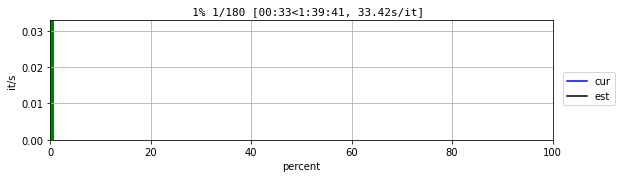

 Topics  2
 Alpha  0.01
 Beta  0.31
 CV  0.4450222773136282
 Topics  2
 Alpha  0.01
 Beta  0.61
 CV  0.43568713364294176
 Topics  2
 Alpha  0.01
 Beta  0.9099999999999999
 CV  0.5026707739013379
 Topics  2
 Alpha  0.01
 Beta  symmetric
 CV  0.464011334413992
 Topics  2
 Alpha  0.31
 Beta  0.01
 CV  0.41069098511315116
 Topics  2
 Alpha  0.31
 Beta  0.31
 CV  0.38597039270094796
 Topics  2
 Alpha  0.31
 Beta  0.61
 CV  0.3944150140953324
 Topics  2
 Alpha  0.31
 Beta  0.9099999999999999
 CV  0.4525714629643736
 Topics  2
 Alpha  0.31
 Beta  symmetric
 CV  0.37628750099757347
 Topics  2
 Alpha  0.61
 Beta  0.01
 CV  0.420802834386697
 Topics  2
 Alpha  0.61
 Beta  0.31
 CV  0.4887411413489401
 Topics  2
 Alpha  0.61
 Beta  0.61
 CV  0.4792506422108669
 Topics  2
 Alpha  0.61
 Beta  0.9099999999999999
 CV  0.406814942232797
 Topics  2
 Alpha  0.61
 Beta  symmetric
 CV  0.4860570677956293
 Topics  2
 Alpha  0.9099999999999999
 Beta  0.01
 CV  0.4377257056452075
 Topics  2
 Alpha  0.9099999

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word',stop_words=rmv_stop_word)
data_vectorized = vectorizer.fit_transform([' '.join(x) for x in text_corpus])
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
#GridSearch the best LDA model?
# Define Search Param
search_params = {'n_components': [5,10,15,20,25,30], 'learning_decay': [.3, .5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized)
# Best Model
best_lda_model = model.best_estimator_
print(best_lda_model)
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
#Scree graph (elbow method)
# transform sparse matrix into gensim corpus
corpus_vect_gensim = gensim.matutils.Sparse2Corpus(data_vectorized, documents_columns=False)
dictionary = Dictionary.from_corpus(corpus_vect_gensim,
        id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))
coherence_values = []
model_list = []
limit=8
start=2
step=1
topics_range = range(start, limit, step)
with open('Gensim LDA (Hypereparameter Tuning)_CountVectorizer.txt', 'a', encoding='utf-8') as file:
    file.write('Gensim LDA (Hypereparameter Tuning) [CountVectorizer]!')
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')

    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')

    model_results = {'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }
    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)))


        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    model = gensim.models.LdaMulticore(corpus=corpus_vect_gensim,
                                               id2word=dictionary,
                                               num_topics=k, 
                                               random_state=100,
                                               chunksize=100,
                                               passes=10,
                                               alpha=a,
                                               eta=b)

                    coherencemodel = CoherenceModel(model=model, texts=text_corpus,corpus=corpus_vect_gensim,dictionary=dictionary, coherence='c_v')
                    print(' Topics ' , k)
                    print(' Alpha ' , a)
                    print(' Beta ' , b)
                    print(' CV ' , coherencemodel.get_coherence())
                    coherence_values.append(coherencemodel.get_coherence())
                    model_list.append(k)

                    # Save the model results                    
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(coherencemodel.get_coherence())                
                    file.write(str(k)+str('-----')+str(a)+str('-----')+str(b)+str('-----')+str(coherencemodel.get_coherence())+str('-----'))
                    pbar.update(1)
        pd.DataFrame(model_results).to_csv('Gensim LDA (Hypereparameter Tuning) [TF-IDF]lda_tuning_results.csv', index=False)
        pbar.close()

### Hyper parameter tuning (n_topics,$\alpha$(doc_topic_prior),$\beta$(topic_word_prior), learning decay) [gensim method]

Number of Topics 2
 CV  0.38346013578520655
Number of Topics 7
 CV  0.3636298720982572
Number of Topics 12
 CV  0.36691190914591537
Number of Topics 17
 CV  0.36808532265656035
Number of Topics 22
 CV  0.36904585844116
Number of Topics 27
 CV  0.35798304111179313
Number of Topics 32
 CV  0.3570350896388621
Number of Topics 37
 CV  0.348596659839445


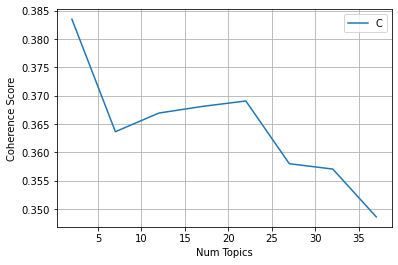

<Figure size 432x288 with 0 Axes>

In [ ]:
dictionary=corpora.Dictionary(text_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in text_corpus]
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
dictionary=corpora.Dictionary(text_corpus)

coherence_values = []
model_list = []
i_model_list = []
i_cv_list = []
limit=8
start=2
step=1
for num_topics in range(start, limit, step):
            print('Number of Topics', num_topics)            
            model = gensim.models.LdaModel(corpus_tfidf,num_topics=num_topics, id2word=dictionary,random_state=100,chunksize=10000,passes=2,alpha='auto',
                                           eta='auto')            
            coherencemodel = CoherenceModel(model=model, texts=text_corpus,corpus=corpus_tfidf,dictionary=dictionary, coherence='c_v')
            print(' CV ' , coherencemodel.get_coherence())
            coherence_values.append(coherencemodel.get_coherence())
            model_list.append(num_topics)
dt_stamp = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d_%H_%M_%S')    
limit=40
start=2
step=5          
get_ipython().run_line_magic('matplotlib', 'inline')
x=range(start,limit,step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend("Coherence_values",loc='best')
plt.grid()
work_dir=os.getcwd()
title_name="TFIDF_GENSIM_CFPB_complain_text_elbow_plot"
img_name=str(work_dir)+'/'+str(title_name)+str("_")+str(dt_stamp)+ str(".png")
#fig=plt.figure(figsize=(6,4))
plt.savefig(img_name,dpi=300,bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
corpus=corpus_vect_gensim
# Final LDA Model with optimized number of clusters as identified in the above coherence plot
lda_model =  gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=8,update_every=1,chunksize=10000,passes=1,random_state=100,
                                             alpha='auto', eta='auto', decay=0.3, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001,
                                             minimum_probability=0.01, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None)
# Saving the Final LDA Model and Data as Pickle file
with open ('TfIdf_text_corpus_CFPB_complaint_text_' + dt_stamp + 'pkl', 'wb') as pkl_fl:
        pickle.dump(text_corpus,pkl_fl)        
with open ('TfIdf_lda_model_CFPB_complaint_text_' + dt_stamp + 'pkl', 'wb') as pkl_fl:
        pickle.dump(lda_model,pkl_fl)
with open ('TfIdf_data_vectorized_CFPB_complaint_text_' + dt_stamp + 'pkl', 'wb') as pkl_fl:
        pickle.dump(data_vectorized,pkl_fl)        
# LDA Visualization
pyLDAvis.enable_notebook()
viz=pyLDAvis.gensim.prepare(lda_model,corpus,dictionary,sort_topics=False)
# save the LDA visualization
pyLDAvis.save_html(viz,'TfIdf_lda_visualization_CFPB_complaint_text_' + dt_stamp + '.html')
pyLDAvis.display(viz)

In [ ]:
freq_df = viz.topic_info
freq_df['prevalence'] = freq_df['Freq'] / freq_df['Total'] # calculates prevalence ratio (0 – 1)
freq_df = freq_df.loc[freq_df['Category'] != 'Default'] # filters out extra data
freq_df.to_excel('Countvectorizer_CFPB_COMPLAIN_TXT_keywords_' + dt_stamp + '.xlsx') # exports to excel

In [ ]:
sent_topics_df = pd.DataFrame()
for i,row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list  # get list of sentences
    row = sorted(row, key=lambda x: (x[1]), reverse=True)

    for j , (topic_num,prop_topic) in enumerate(row):
        if j == 0:
            wp =lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word,prop in wp])
            sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num),round(prop_topic,4),topic_keywords]),ignore_index=True)
        else:
            break
sent_topics_df.columns = ['Dominant_Topic','Perc_Contribution','Topic_Keywords']
contents = pd.Series(texts_mod)
texts=texts.reset_index(drop=True)
contents_act = pd.Series(texts['Complain_text'])
gensim_lda_eta = pd.Series(lda_model.eta)
sent_topics_df = pd.concat([sent_topics_df,contents_act,contents,gensim_lda_eta],axis =1)

df_dominant_topic = sent_topics_df.reset_index()
df_dominant_topic.columns = ['Document_No' ,'Dominant_Topic','Topic_Perc_Contrib','keywords','Original Text','Clean Text','eta/beta']
lda_alpha = pd.Series(lda_model.alpha)
lda_topic = pd.Series(range(0,15))
comb_topic_alpha = pd.concat([lda_topic,lda_alpha],axis =1)
comb_topic_alpha.columns = ['Dominant_Topic','alpha/theta']
df_dominant_topic  = pd.merge(df_dominant_topic,comb_topic_alpha, on = 'Dominant_Topic', how = 'left')
#Adding Issue and Sub-issue from complain_data_dedup dataframe on resultset
indx = list(complain_data_dedup.Complaint_ID)
df_dominant_topic = df_dominant_topic.set_index([indx])
df_dominant_topic = df_dominant_topic.join(complain_data_dedup[['Issue', 'Sub-issue']])
df_dominant_topic.to_excel('CountVectorizer_CFPB_COMPLAIN_TXT_topic_by_document_' + dt_stamp + '.xlsx')

Find the most representative document for each topic

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic[['Dominant_Topic','Topic_Perc_Contrib','keywords','Original Text']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.to_excel('CountVectorizer_CFPB_COMPLAIN_TXT_most_representative_document_' + dt_stamp + '.xlsx')

Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
sent_topics_sorteddf_mallet.to_excel('CountVectorizer_CFPB_COMPLAIN_TXT_topic_dist_accros_doc_' + dt_stamp + '.xlsx')

NameError: ignored